#**Dynamic Two-Stage Early Warning System for Sepsis-Induced Coagulopathy and Progression to Disseminated Intravascular Coagulation: A MIMIC-IV Study**

**Contributors:** Amisha Kelkar, Chaitali Deshmukh, Pratik Mahajan, Rinaldo Brendon Patel

# Data Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report,precision_recall_curve, roc_curve, average_precision_score, confusion_matrix, brier_score_loss
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
import shap
import optuna
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from fairlearn.metrics import selection_rate, false_positive_rate, true_positive_rate
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency, fisher_exact
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from sklearn.calibration import calibration_curve
from scipy.stats import chi2
from scipy.stats import ttest_ind
from google.cloud import bigquery
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Data Cleaning

In [ ]:
df = pd.read_csv("rework_final_table_with_label.csv")

In [ ]:
df.shape

(143167, 112)

In [ ]:
df["sic_next_day"].value_counts()

sic_next_day
0    139960
1      3207
Name: count, dtype: int64

In [ ]:
df = df[df["min_spo2"] > 40]

In [ ]:
df = df[df["max_heart_rate"] < 240]

In [ ]:
df.shape

(142706, 112)

In [ ]:
df = df[df["min_mbp"] > 20]

In [ ]:
df.shape

(141437, 112)

In [ ]:
df[df["bmi"]> 60].count()

subject_id                  1003
stay_id                     1003
chart_date                  1003
suspected_infection_time    1003
infection_date              1003
                            ... 
inr_score                    865
sofa_indicator              1003
sic_today                    860
sic_tomorrow                1003
sic_next_day                1003
Length: 112, dtype: int64

Fixing unrealistic values, recalculating needed measures, replacing invalid entries, and removing temporary columns used along the way.

In [ ]:
df_clean = df.copy()

df_clean.loc[(df_clean["height_final"] < 120) |
             (df_clean["height_final"] > 210), "height_final"] = np.nan

df_clean["height_m"] = df_clean["height_final"] / 100
df_clean["bmi_recalc"] = df_clean["weight_final"] / (df_clean["height_m"]**2)

df_clean["bmi"] = np.where(~df_clean["bmi_recalc"].isna(),
                           df_clean["bmi_recalc"],
                           df_clean["bmi"])

df_clean.loc[(df_clean["bmi"] < 10) | (df_clean["bmi"] > 60), "bmi"] = np.nan

df_clean = df_clean.drop(columns=["height_m","bmi_recalc"])

In [ ]:
df_clean.head()

subject_id   stay_id  chart_date suspected_infection_time infection_date  \
0    10001843  39698942  2134-12-05      2134-12-05 19:23:00     2134-12-05   
1    10001884  37510196  2131-01-14      2131-01-10 16:36:00     2131-01-10   
2    10001884  37510196  2131-01-12      2131-01-10 16:36:00     2131-01-10   
3    10001884  37510196  2131-01-16      2131-01-10 16:36:00     2131-01-10   
4    10001884  37510196  2131-01-11      2131-01-10 16:36:00     2131-01-10   

   sepsis_day  max_heart_rate  min_mbp  max_resp_rate  min_spo2  ...  \
0           0           155.0     61.0           26.0      88.0  ...   
1           4            79.0     90.0           29.5      96.0  ...   
2           2            85.0     81.0           28.0      89.0  ...   
3           6            79.0     81.0           26.5      85.0  ...   
4           1            78.0     46.0           26.0      89.0  ...   

   height_final  weight_final        bmi  average_sofa_score  platelet_score  \
0           NaN          76.8        NaN            4.166667             0.0   
1         157.0          65.0  26.370238            3.000000             0.0   
2         157.0          65.0  26.370238            2.208333             0.0   
3         157.0          65.0  26.370238            1.000000             0.0   
4         157.0          65.0  26.370238            3.000000             0.0   

   inr_score  sofa_indicator  sic_today  sic_tomorrow  sic_next_day  
0        2.0               1        0.0             0             0  
1        0.0               1        0.0             0             0  
2        0.0               1        0.0             0             0  
3        1.0               0        0.0             0             0  
4        1.0               1        0.0             0             0  

[5 rows x 112 columns]

In [ ]:
df_clean.shape

(141437, 112)

In [ ]:
df_clean[df_clean["sepsis_day"] > 40].count()

subject_id                  2060
stay_id                     2060
chart_date                  2060
suspected_infection_time    2060
infection_date              2060
                            ... 
inr_score                   1724
sofa_indicator              2060
sic_today                   1716
sic_tomorrow                2060
sic_next_day                2060
Length: 112, dtype: int64

In [ ]:
df_clean = df_clean[df_clean["sepsis_day"] <= 40]

In [ ]:
df_clean = df_clean[df_clean["max_resp_rate"] <= 60]

In [ ]:
df_clean.shape

(138913, 112)

In [ ]:
df_clean = df_clean[(df_clean["inr_avg"] >= 0.8) & (df_clean["inr_avg"] <= 10)]

In [ ]:
df_clean.shape

(115801, 112)

In [ ]:
(df_clean.isna().mean() * 100).round(2)

subject_id                  0.00
stay_id                     0.00
chart_date                  0.00
suspected_infection_time    0.00
infection_date              0.00
                            ... 
inr_score                   0.00
sofa_indicator              0.00
sic_today                   0.49
sic_tomorrow                0.00
sic_next_day                0.00
Length: 112, dtype: float64

In [ ]:
df_clean.isna().sum().sort_values(ascending= False).head(60)

rdwsd_avg               115801
thrombin_avg            115583
globulin_avg            115293
bicarbonate_avg         114606
total_protein_avg       114580
d_dimer_avg             113396
bg_aado2_avg            112316
globulin                107464
bg_chloride_avg         105864
vasopressin_use         105181
bg_hematocrit_avg       104478
bg_hemoglobin_avg       104477
bg_sodium_avg           103426
rrt                     101491
total_protein            97288
fio2_avg                 94980
fibrinogen_avg           92845
bg_temperature_avg       89185
bg_potassium_avg         89028
so2_avg                  87818
bg_glucose_avg           86868
aado2_avg                86592
albumin_avg              82688
plateau_pressure_avg     74904
bg_calcium_avg           66760
min_tidal_volume         65925
max_tidal_volume         65925
mean_tidal_volume        65925
bg_lactate_avg           57509
weight_daily             52836
sw_weight                52836
pao2fio2ratio_avg        52717
bilirubi

Removing columns with heavy missingness, simplifying the dataset and keeping only variables useful for modeling.

In [ ]:
cols_drop_95 = [
    "rdwsd_avg","thrombin_avg","globulin_avg","bicarbonate_avg",
    "total_protein_avg","d_dimer_avg","bg_aado2_avg","globulin",
    "bg_chloride_avg","vasopressin_use","bg_hematocrit_avg",
    "bg_hemoglobin_avg","bg_sodium_avg","rrt","total_protein",
    "fio2_avg","fibrinogen_avg","bg_temperature_avg",
    "bg_potassium_avg","so2_avg","bg_glucose_avg","aado2_avg",
    "albumin_avg","plateau_pressure_avg","bg_calcium_avg",
    "min_tidal_volume","max_tidal_volume","mean_tidal_volume",
    "bg_lactate_avg"]

df_clean = df_clean.drop(columns=cols_drop_95, errors="ignore")

In [ ]:
df_clean.isna().sum().sort_values(ascending= False).head(60)

sw_weight              52836
weight_daily           52836
pao2fio2ratio_avg      52717
bilirubin_total_avg    52262
alt_avg                52244
alp_avg                52076
ast_avg                51329
min_minute_volume      43177
max_minute_volume      43177
mean_minute_volume     43177
mean_peep              43062
min_peep               43062
max_peep               43062
urine_output_avg       39714
ph_avg                 39265
pco2_avg               39264
totalco2_avg           39264
baseexcess_avg         39264
po2_avg                39252
min_fio2               31840
max_fio2               31840
mean_fio2              31840
height                 27965
bmi                    20435
height_final           16486
weight_final            4578
max_temperature         4184
ptt_avg                 2637
rdw_avg                  750
aniongap_avg             677
mch_avg                  616
mchc_avg                 608
mcv_avg                  607
rbc_avg                  606
wbc_avg       

Creating flags for each blood-gas variable, marking whether a value is present. This is capturing measurement patterns, helping the model learn from when labs are taken as well as their actual values.

In [ ]:
bg_cols = [
    "ph_avg","pco2_avg","po2_avg",
    "baseexcess_avg","totalco2_avg"]

for col in bg_cols:
    df_clean[col + "_measured"] = df_clean[col].notna().astype(int)

Imputing missing blood-gas values with clinically typical defaults, keeping the dataset complete while avoiding unrealistic replacements.

In [ ]:
safe_impute_values = {
    "ph_avg": 7.40,
    "pco2_avg": 40,
    "po2_avg": 75,
    "baseexcess_avg": 0,
    "totalco2_avg": 24
}

for col, val in safe_impute_values.items():
    df_clean[col] = df_clean[col].fillna(val)

Filling missing FiO₂-related values with room-air levels (21%), keeping the variables usable and maintaining physiological plausibility when true measurements were not recorded.

In [ ]:
fio2_cols = ["max_fio2","min_fio2","mean_fio2"]

for col in fio2_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(21)

Filling missing PTT values using the median. Keeping the feature consistent without introducing outliers.


In [ ]:
if "ptt_avg" in df_clean.columns:
    df_clean["ptt_avg"] = df_clean["ptt_avg"].fillna(df_clean["ptt_avg"].median())

In [ ]:
df_clean.shape

(115801, 88)

In [ ]:
df_clean.columns

Index(['subject_id', 'stay_id', 'chart_date', 'suspected_infection_time',
       'infection_date', 'sepsis_day', 'max_heart_rate', 'min_mbp',
       'max_resp_rate', 'min_spo2', 'max_temperature', 'mean_heart_rate',
       'mean_mbp', 'mean_resp_rate', 'mean_fio2', 'max_fio2', 'min_fio2',
       'mean_peep', 'max_peep', 'min_peep', 'mean_minute_volume',
       'max_minute_volume', 'min_minute_volume', 'vasopressor_use',
       'avg_sofa_score_daily', 'po2_avg', 'pco2_avg', 'pao2fio2ratio_avg',
       'ph_avg', 'baseexcess_avg', 'totalco2_avg', 'mch_avg', 'mchc_avg',
       'mcv_avg', 'platelet_avg', 'rbc_avg', 'rdw_avg', 'wbc_avg',
       'aniongap_avg', 'bun_avg', 'creatinine_avg', 'inr_avg', 'pt_avg',
       'ptt_avg', 'alt_avg', 'alp_avg', 'ast_avg', 'bilirubin_total_avg', 'mi',
       'chf', 'malignant_cancer', 'metastatic_solid_tumor',
       'severe_liver_disease', 'chronic_pulmonary_disease',
       'mild_liver_disease', 'diabetes_with_cc', 'diabetes_without_cc',
       'renal_d

In [ ]:
df_clean.isna().sum().sort_values(ascending= False).head(60)

weight_daily                52836
sw_weight                   52836
pao2fio2ratio_avg           52717
bilirubin_total_avg         52262
alt_avg                     52244
alp_avg                     52076
ast_avg                     51329
min_minute_volume           43177
max_minute_volume           43177
mean_minute_volume          43177
max_peep                    43062
mean_peep                   43062
min_peep                    43062
urine_output_avg            39714
height                      27965
bmi                         20435
height_final                16486
weight_final                 4578
max_temperature              4184
rdw_avg                       750
aniongap_avg                  677
mch_avg                       616
mchc_avg                      608
mcv_avg                       607
rbc_avg                       606
wbc_avg                       583
platelet_score                570
platelet_avg                  570
sic_today                     570
bun_avg       

In [ ]:
df_clean = df_clean.drop(columns=["weight_daily", "sw_weight"], errors="ignore")

Creating indicators showing whether each ventilation value was recorded, then filling missing values with the median.

In [ ]:
vent_cols = [
    "min_minute_volume", "max_minute_volume", "mean_minute_volume",
    "min_peep", "max_peep", "mean_peep"
]

for col in vent_cols:
    df_clean[col + "_measured"] = df_clean[col].notna().astype(int)
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

Filling missing urine output values with the median, keeping the feature usable while avoiding skew from extreme measurements.


In [ ]:
df_clean["urine_output_avg"] = df_clean["urine_output_avg"].fillna(
    df_clean["urine_output_avg"].median()
)

Filling missing height and weight values with their medians to maintain completeness. Then recalculating BMI from those filled values to ensure consistency across the dataset.

In [ ]:
df_clean["height_final"] = df_clean["height_final"].fillna(df_clean["height_final"].median())
df_clean["weight_final"] = df_clean["weight_final"].fillna(df_clean["weight_final"].median())

df_clean["bmi"] = df_clean["weight_final"] / (df_clean["height_final"]/100)**2

Filling missing maximum temperature values with a typical normal temperature (36.8°C).

In [ ]:
df_clean["max_temperature"] = df_clean["max_temperature"].fillna(36.8)

In [ ]:
df_clean.to_csv("clean_rework_final_table.csv", index=False)

# **Sepsis Induced Coagulopathy (SIC)**

# EDA for SIC

In [ ]:
new_df = pd.read_csv("clean_rework_final_table.csv")

Selecting the top features most correlated with the target and building a focused correlation matrix from them. Plotting this matrix as a heatmap highlights key relationships among the strongest predictors and their connection to the outcome.


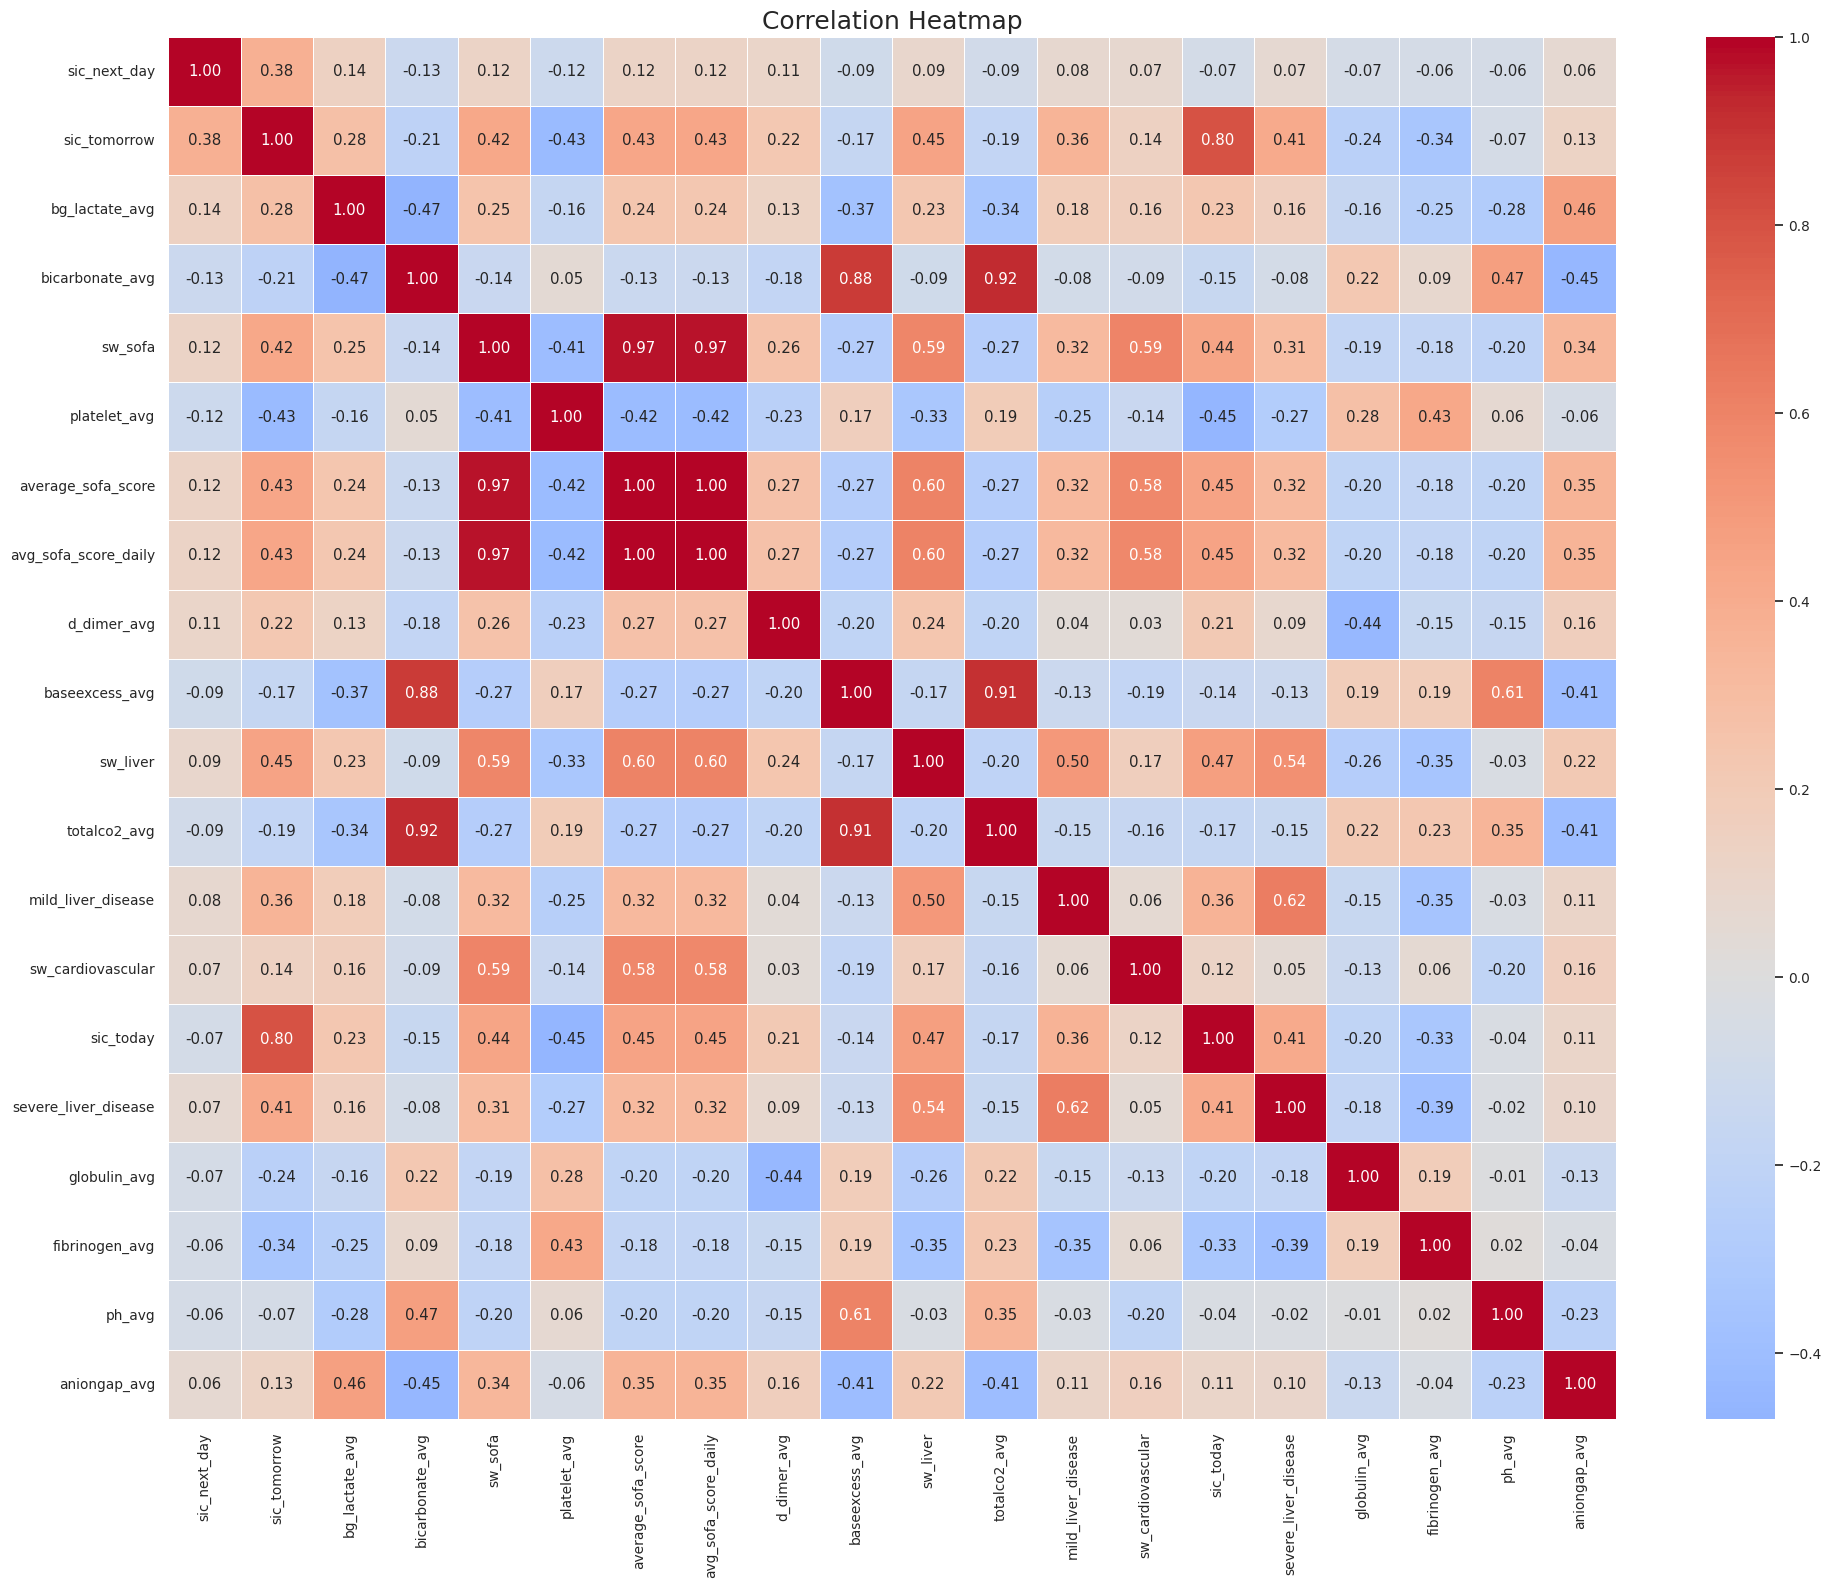

In [ ]:
target = 'sic_next_day'
corr_matrix = df.corr(numeric_only=True)
sorted_cols = corr_matrix[target].abs().sort_values(ascending=False).index[:20]
sorted_corr = corr_matrix.loc[sorted_cols, sorted_cols]

plt.figure(figsize=(20, 16))
sns.set(font_scale=0.9)

sns.heatmap(
    sorted_corr,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.4
)

plt.title("Correlation Heatmap", fontsize=18)
plt.tight_layout()
plt.show()



The heatmap shows the 20 variables most strongly correlated with next-day SIC. Each cell gives the correlation between two features, with color showing direction and strength. Red indicates positive correlation, blue indicates negative, and values near ±1 show strong relationships. The diagonal is dark red because each variable is perfectly correlated with itself. Clusters of strong correlations, such as SOFA items, liver markers, and acid–base measures, highlight related predictors and possible redundancy.


Plotting how INR values change across sepsis days, separating the curves by next-day SIC status. This highlights temporal differences between SIC and non-SIC groups and helps visualize whether INR trends diverge meaningfully over time.

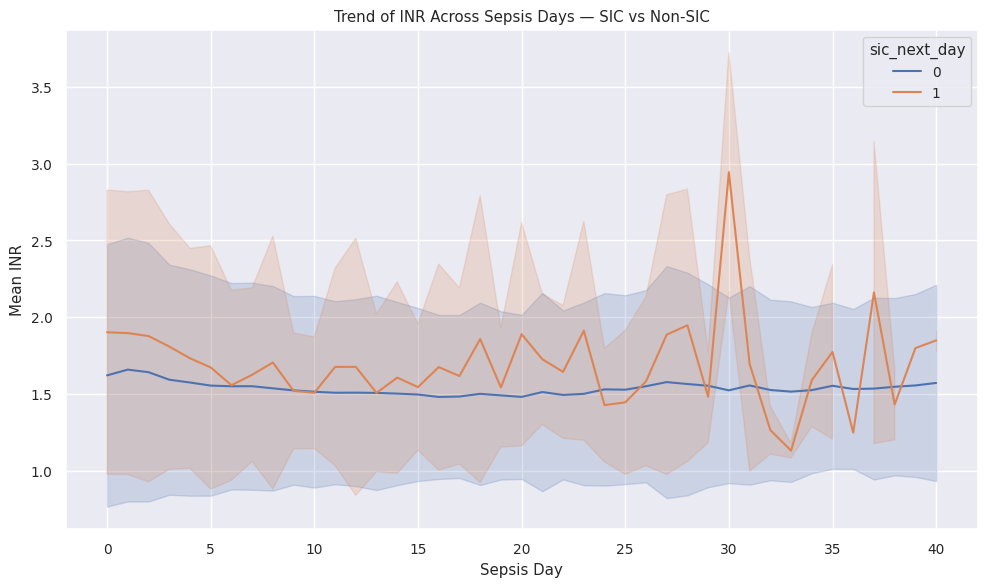

In [ ]:
plt.figure(figsize=(10,6))

sns.lineplot(
    data=new_df,
    x="sepsis_day",
    y="inr_avg",
    hue="sic_next_day",
    estimator="mean",
    errorbar="sd"
)

plt.title("Trend of INR Across Sepsis Days — SIC vs Non-SIC")
plt.xlabel("Sepsis Day")
plt.ylabel("Mean INR")
plt.tight_layout()
plt.show()

The plot shows INR over sepsis days for patients who develop SIC the next day (orange) and those who do not (blue). The SIC group has consistently higher and more variable INR, with noticeable spikes around days 25 to 35, indicating worsening coagulation. The non-SIC group stays lower and steadier. Overall, INR rises earlier and fluctuates more in patients who go on to develop SIC, suggesting it may serve as an early indicator of coagulopathy.

Plotting the mean SOFA score over sepsis days for SIC versus non-SIC patients. This visual reveals how organ dysfunction evolves differently between the two groups across time.


/var/tmp/ipykernel_6574/376844104.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


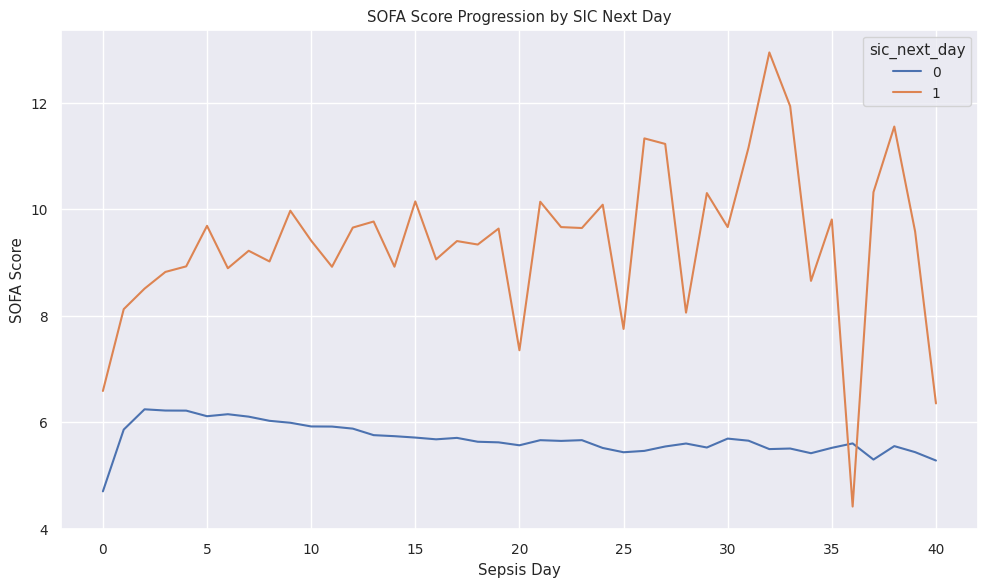

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=new_df,
    x='sepsis_day',
    y='average_sofa_score',
    hue='sic_next_day',
    estimator='mean',
    ci=None
)
plt.title("SOFA Score Progression by SIC Next Day")
plt.xlabel("Sepsis Day")
plt.ylabel("SOFA Score")
plt.tight_layout()
plt.show()


The plot shows SOFA scores over sepsis days for patients who will develop SIC the next day (orange) and those who will not (blue). The SIC group has higher and more variable scores, with peaks around days 20 to 35. The non-SIC group remains much lower and steadier. The widening gap indicates earlier and more severe organ dysfunction in patients who progress to SIC.


# Statistical Analysis for SIC

Filtering to SHAP-selected features and running separate univariate logistic regressions for each one. Extracting odds ratios, confidence intervals, and p-values to evaluate how strongly each variable relates to the outcome on its own.

In [ ]:
df_or = df_sic.copy()

outcome = 'sic_next_day'
df_or[outcome] = df_or[outcome].astype(int)

shap_features = [
    "platelet_avg",
    "inr_avg",
    "pt_avg",
    "average_sofa_score",
    "platelet_avg_delta1",
    "baseexcess_avg",
    "totalco2_avg",
    "sw_liver",
    "urine_output_avg",
    "alt_avg",
    "ph_avg",
    "platelet_avg_lag1",
    "mild_liver_disease",
    "aniongap_avg",
    "creatinine_avg_delta1",
    "urine_output_avg_lag1",
    "sw_renal",
    "pt_avg_delta1",
    "average_sofa_score_delta1",
    "sepsis_day"
]

shap_features = [c for c in shap_features if c in df_or.columns]

univariate_results = []

for var in shap_features:
    try:
        formula = f"{outcome} ~ {var}"
        model = smf.logit(formula=formula, data=df_or).fit(disp=0)

        OR = np.exp(model.params[var])
        CI_lower = np.exp(model.conf_int().loc[var][0])
        CI_upper = np.exp(model.conf_int().loc[var][1])
        p_value = model.pvalues[var]

        univariate_results.append({
            "Variable": var,
            "Odds Ratio": OR,
            "CI Lower": CI_lower,
            "CI Upper": CI_upper,
            "p-value": p_value
        })

    except Exception as e:
        pass

univariate_or_df = pd.DataFrame(univariate_results)
univariate_or_df = univariate_or_df.sort_values("p-value")
univariate_or_df

Variable  Odds Ratio  CI Lower  CI Upper        p-value
0                platelet_avg    0.975148  0.974308  0.975989   0.000000e+00
3          average_sofa_score    1.310613  1.297159  1.324206   0.000000e+00
7                    sw_liver    1.735997  1.694086  1.778945   0.000000e+00
11          platelet_avg_lag1    0.982950  0.982103  0.983798   0.000000e+00
12         mild_liver_disease    3.908462  3.630825  4.207329  7.156724e-288
5              baseexcess_avg    0.872517  0.865431  0.879662  1.284684e-235
6                totalco2_avg    0.875920  0.868142  0.883768  2.704415e-186
1                     inr_avg    1.663877  1.601329  1.728868  1.570261e-149
13               aniongap_avg    1.103550  1.095226  1.111936  1.612674e-143
10                     ph_avg    0.002670  0.001638  0.004350  4.385518e-125
2                      pt_avg    1.035621  1.032591  1.038661  3.501021e-121
4         platelet_avg_delta1    0.990767  0.989920  0.991614  2.416711e-100
18  average_sofa_score_delta1    1.246679  1.219512  1.274451   1.184446e-85
16                   sw_renal    1.266394  1.236740  1.296758   5.446991e-85
8            urine_output_avg    0.994548  0.993980  0.995117   2.070373e-78
19                 sepsis_day    0.952066  0.945839  0.958334   9.870500e-49
15      urine_output_avg_lag1    0.995707  0.995063  0.996353   9.919672e-39
9                     alt_avg    1.000289  1.000242  1.000337   6.514744e-33
17              pt_avg_delta1    1.011724  1.001692  1.021857   2.188110e-02
14      creatinine_avg_delta1    0.961854  0.885979  1.044228   3.535751e-01

Computing Cohen’s *d* for every numeric feature to measure how strongly the positive and negative outcome groups differ. This is filtering out unstable comparisons, calculating standardized effect sizes, and ranking variables by the magnitude of their separation to highlight the most discriminative predictors.


In [ ]:
def cohens_d(x_pos, x_neg):
    """Compute Cohen's d for two groups safely."""
    n1, n2 = len(x_pos), len(x_neg)
    s1, s2 = np.var(x_pos, ddof=1), np.var(x_neg, ddof=1)

    s_pooled = np.sqrt(((n1 - 1)*s1 + (n2 - 1)*s2) / (n1 + n2 - 2))

    if s_pooled == 0 or np.isnan(s_pooled):
        return np.nan

    return (np.mean(x_pos) - np.mean(x_neg)) / s_pooled

group_pos = df_or[df_or['sic_next_day'] == 1]
group_neg = df_or[df_or['sic_next_day'] == 0]

numeric_vars = df_or.select_dtypes(include='number').columns
numeric_vars = [v for v in numeric_vars if v != 'sic_next_day']

cohen_results = []

for var in numeric_vars:
    x1 = group_pos[var].dropna()
    x0 = group_neg[var].dropna()

    if len(x1) < 5 or len(x0) < 5:
        continue

    d = cohens_d(x1, x0)

    if np.isnan(d):
        continue

    cohen_results.append([var, d])


cohen_df = (
    pd.DataFrame(cohen_results, columns=["Variable", "Cohen_d"])
      .sort_values("Cohen_d", key=abs, ascending=False)
)

cohen_df

Variable   Cohen_d
24                 platelet_avg -1.055427
58           average_sofa_score  1.023857
59               platelet_score  0.942737
67            platelet_avg_lag1 -0.920846
49                     sw_liver  0.894905
77      average_sofa_score_lag1  0.863549
41         severe_liver_disease  0.754888
43           mild_liver_disease  0.716021
20               baseexcess_avg -0.587964
36          bilirubin_total_avg  0.552464
60                    inr_score  0.530451
21                 totalco2_avg -0.503612
31                      inr_avg  0.500606
50            sw_cardiovascular  0.491845
28                 aniongap_avg  0.472042
68          platelet_avg_delta1 -0.470694
32                       pt_avg  0.460088
78    average_sofa_score_delta1  0.451239
26                      rdw_avg  0.444284
19                       ph_avg -0.438111
69                 inr_avg_lag1  0.426572
71                  pt_avg_lag1  0.393965
22                      mch_avg  0.378881
52                     sw_renal  0.363491
23                     mchc_avg  0.357489
61               sofa_indicator  0.341710
54             urine_output_avg -0.339558
62              ph_avg_measured  0.320125
63            pco2_avg_measured  0.320085
64             po2_avg_measured  0.319884
8                      mean_mbp -0.309064
34                      alt_avg  0.307034
79        urine_output_avg_lag1 -0.302396
3                       min_mbp -0.278221
2                    sepsis_day -0.272569
17                     pco2_avg -0.270746
7               mean_heart_rate  0.260139
75          creatinine_avg_lag1  0.236927
15              vasopressor_use  0.225769
48               sw_respiration  0.212260
73                 ptt_avg_lag1  0.209039
39             malignant_cancer  0.205153
47                       stroke -0.200706
30               creatinine_avg  0.198225
33                      ptt_avg  0.196286
29                      bun_avg  0.174289
10                    mean_fio2  0.165007
25                      rbc_avg -0.160958
16                      po2_avg  0.146874
6               max_temperature -0.138383
27                      wbc_avg  0.125260
66           mean_peep_measured  0.118799
53                          age -0.118450
65  mean_minute_volume_measured  0.118442
11                    mean_peep  0.115596
40       metastatic_solid_tumor  0.090336
18            pao2fio2ratio_avg  0.089055
42    chronic_pulmonary_disease -0.088404
5                      min_spo2 -0.085390
80      urine_output_avg_delta1 -0.081692
14            min_minute_volume  0.077145
45          diabetes_without_cc -0.068130
70               inr_avg_delta1  0.066473
38                          chf -0.063841
44             diabetes_with_cc -0.055301
72                pt_avg_delta1  0.052555
37                           mi -0.050999
57                          bmi -0.047412
1                       stay_id  0.046002
4                 max_resp_rate -0.044723
12           mean_minute_volume  0.036642
46                renal_disease  0.027307
9                mean_resp_rate -0.025131
35                      alp_avg -0.022668
76        creatinine_avg_delta1 -0.021613
55                       height -0.013277
0                    subject_id  0.013097
74               ptt_avg_delta1 -0.011313
51                       sw_cns  0.006246
56                 height_final  0.003983
13            max_minute_volume -0.001076

Evaluating how each categorical variable relates to the outcome by computing Cramér’s V, a measure of association derived from the chi-square statistic. It builds contingency tables for every non-numeric column, filters out those without meaningful structure, and calculates how strongly each category distribution differs between outcome groups. The resulting ranked table highlights which categorical features show the strongest relationship to the target and may be most informative for downstream modeling.

In [ ]:
def cramers_v(confusion_matrix):
    """Compute Cramér's V for a contingency table."""
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r - 1, k - 1))))

categorical_vars = df_or.select_dtypes(exclude='number').columns

cramer_results = []

for var in categorical_vars:
    table = pd.crosstab(df_or[var], df_or['sic_next_day'])

    # Need at least a 2×2 table
    if table.shape[0] < 2 or table.shape[1] < 2:
        continue

    v = cramers_v(table.values)
    cramer_results.append([var, v])

cramer_df = (
    pd.DataFrame(cramer_results, columns=["Variable", "Cramers_V"])
      .sort_values("Cramers_V", ascending=False)
)

cramer_df

Variable  Cramers_V
1  suspected_infection_time   0.678322
0                chart_date   0.568523
2            infection_date   0.559830
3                      race   0.024989
4            admission_type   0.021723
5                    gender   0.000507



Combining top effect-size metrics from both numeric and categorical features, sorting them by strength, and visualizing their impact in a unified bar plot. This highlights which variables show the strongest overall relationship to the SIC outcome.


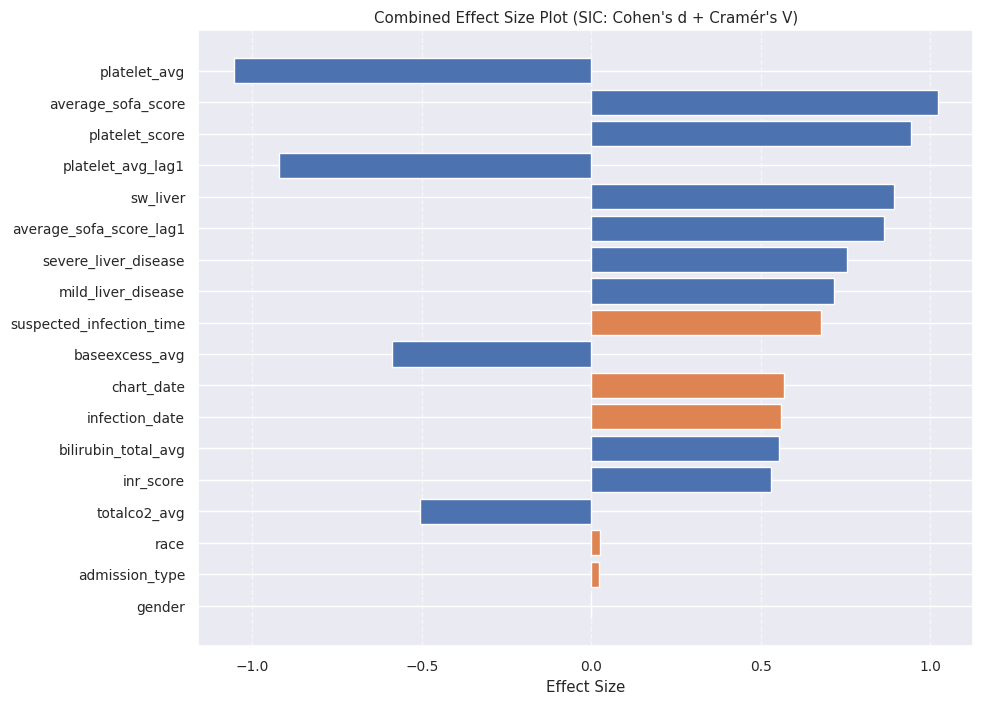

In [ ]:
cohend_sic = {
    "Variable": [
        "platelet_avg",
        "average_sofa_score",
        "platelet_score",
        "platelet_avg_lag1",
        "sw_liver",
        "average_sofa_score_lag1",
        "severe_liver_disease",
        "mild_liver_disease",
        "baseexcess_avg",
        "bilirubin_total_avg",
        "inr_score",
        "totalco2_avg"
    ],
    "Effect_Size": [
        -1.055,
        1.023,
        0.943,
        -0.921,
        0.894,
        0.864,
        0.755,
        0.716,
        -0.588,
        0.552,
        0.530,
        -0.504
    ],
    "Type": "Cohen_d"
}

cramersv_sic = {
    "Variable": [
        "suspected_infection_time",
        "chart_date",
        "infection_date",
        "race",
        "admission_type",
        "gender"
    ],
    "Effect_Size": [
        0.678,
        0.569,
        0.560,
        0.025,
        0.022,
        0.0003
    ],
    "Type": "Cramers_V"
}

df = pd.concat([pd.DataFrame(cohend_sic), pd.DataFrame(cramersv_sic)], ignore_index=True)

df["abs_effect"] = df["Effect_Size"].abs()
df = df.sort_values("abs_effect", ascending=False)

colors = ["#4c72b0" if t == "Cohen_d" else "#dd8452" for t in df["Type"]]

plt.figure(figsize=(10, 8))
plt.barh(df["Variable"], df["Effect_Size"], color=colors)
plt.xlabel("Effect Size")
plt.title("Combined Effect Size Plot (SIC: Cohen's d + Cramér's V)")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

This bar plot ranks the features most associated with SIC using effect sizes for continuous variables and Cramér’s V for categorical ones. Platelet measures show the strongest effects, followed by SOFA scores, liver markers, and acid–base variables. Among categorical features, suspected infection timing has moderate influence, while race, admission type, and gender contribute little. Overall, the plot highlights the predictors that best distinguish SIC from non-SIC patients.

Running both Mann-Whitney U and t-tests for each numeric feature to compare the two outcome groups. The resulting test statistics and p-values identify variables with the strongest group separation, helping prioritize features for modeling.


In [ ]:
label = "sic_next_day"
df = df_sic.copy()

numeric_vars = df.select_dtypes(include="number").columns
numeric_vars = [v for v in numeric_vars if v != label]

group_pos = df[df[label] == 1]
group_neg = df[df[label] == 0]

results = []

for var in numeric_vars:
    x1 = group_pos[var].dropna()
    x0 = group_neg[var].dropna()

    if len(x1) < 5 or len(x0) < 5:
        continue

    try:
        u_stat, mw_p = mannwhitneyu(x1, x0, alternative="two-sided")
    except:
        u_stat, mw_p = np.nan, np.nan

    try:
        t_stat, t_p = ttest_ind(x1, x0, equal_var=False, nan_policy='omit')
    except:
        t_stat, t_p = np.nan, np.nan

    results.append({
        "Variable": var,
        "MannWhitney_U": u_stat,
        "MW_p_value": mw_p,
        "t_statistic": t_stat,
        "ttest_p_value": t_p
    })

mw_ttest_df = pd.DataFrame(results).sort_values("MW_p_value")
mw_ttest_df

/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Variable  MannWhitney_U     MW_p_value  t_statistic  \
41         severe_liver_disease    175270200.0   0.000000e+00    24.782015   
59               platelet_score    187282448.5   0.000000e+00    30.310124   
58           average_sofa_score    221343438.5   0.000000e+00    51.384511   
49                     sw_liver    199914090.0   0.000000e+00    34.501863   
69            platelet_avg_lag1     24214114.5   0.000000e+00   -87.613450   
43           mild_liver_disease    184575262.0   0.000000e+00    29.323224   
24                 platelet_avg     35709286.5   0.000000e+00  -166.380594   
63                 sic_tomorrow    292338528.0   0.000000e+00          inf   
32                       pt_avg    201513738.5  2.372065e-281    20.824734   
31                      inr_avg    200911836.5  1.382824e-278    22.552455   
79      average_sofa_score_lag1     97619030.0  6.854860e-249    35.205461   
36          bilirubin_total_avg     76181231.5  6.374150e-227    18.024924   
20               baseexcess_avg     99839081.5  1.827255e-212   -29.246022   
60                    inr_score    187880332.0  4.138601e-186    32.400112   
21                 totalco2_avg    105109926.0  1.511358e-164   -28.842328   
50            sw_cardiovascular    181194046.0  4.078959e-139    24.114048   
70          platelet_avg_delta1     45257579.0  1.833661e-130   -25.199363   
73                  pt_avg_lag1     88222324.0  6.068858e-120    14.159928   
71                 inr_avg_lag1     87860169.0  2.960218e-117    15.362795   
26                      rdw_avg    180166991.5  6.583289e-113    21.129348   
54             urine_output_avg    112228795.5  3.409322e-111   -22.677972   
28                 aniongap_avg    179095160.0  6.021575e-110    21.237731   
52                     sw_renal    176175552.5   5.074729e-92    19.206813   
22                      mch_avg    176660471.0   3.215758e-88    19.371832   
23                     mchc_avg    175770439.0   2.837410e-83    19.576360   
2                    sepsis_day    116936751.0   9.810120e-81   -17.685236   
61               sofa_indicator    163463622.0   1.466726e-77    38.811147   
19                       ph_avg    118515868.5   1.708588e-75   -18.129360   
8                      mean_mbp    118195344.5   2.386131e-73   -18.645334   
64              ph_avg_measured    168505024.0   2.501245e-68    20.530294   
65            pco2_avg_measured    168501940.0   2.598795e-68    20.527471   
66             po2_avg_measured    168486520.0   3.146462e-68    20.513356   
30               creatinine_avg    172407273.5   4.603089e-68    11.075651   
80    average_sofa_score_delta1     82580229.0   4.325799e-65    15.730637   
17                     pco2_avg    121290427.5   2.137230e-61   -15.470608   
33                      ptt_avg    171116466.5   1.029956e-58     9.782055   
81        urine_output_avg_lag1     52928832.0   1.391212e-57   -15.032618   
3                       min_mbp    122391006.5   1.492796e-53   -15.839760   
77          creatinine_avg_lag1     79075191.5   1.333022e-41     9.704574   
7               mean_heart_rate    166429447.5   2.512454e-39    13.416846   
15              vasopressor_use    162556154.0   6.310487e-35    12.945070   
75                 ptt_avg_lag1     78136909.0   8.800507e-34     7.893594   
48               sw_respiration    162403130.5   3.290176e-29    10.954199   
39             malignant_cancer    155786114.0   3.859349e-29     9.398533   
34                      alt_avg     61905326.5   4.507024e-29     8.735870   
47                       stroke    134279630.0   5.802263e-28   -13.172823   
16                      po2_avg    162464805.0   3.446008e-27     7.487632   
6               max_temperature    130174837.5   3.714763e-25    -6.669970   
29                      bun_avg    160550904.0   1.683827e-22     8.743642   
25                      rbc_avg    132017717.5   1.673788e-19    -8.892915   
53                          age    134291687.

Running chi-square tests across all categorical variables to evaluate how their distributions differ by outcome. This includes computing Cramér’s V for effect size and sorting variables by their strength of association, producing a clear ranking of the most informative categorical predictors.


In [ ]:
def cramers_v(conf_matrix):
    chi2, _, _, _ = chi2_contingency(conf_matrix)
    n = conf_matrix.sum()
    r, k = conf_matrix.shape
    return np.sqrt(chi2 / (n * (min(r - 1, k - 1))))

def chi_square_tests(df, outcome_col):
    categorical_vars = df.select_dtypes(exclude='number').columns.tolist()

    results = []

    for var in categorical_vars:
        try:
            table = pd.crosstab(df[var], df[outcome_col])

            if table.shape[0] < 2 or table.shape[1] < 2:
                continue

            chi2, p, dof, _ = chi2_contingency(table)

            v = cramers_v(table.values)

            results.append({
                "Variable": var,
                "Chi2": chi2,
                "p_value": p,
                "DoF": dof,
                "Cramers_V": v
            })

        except Exception as e:
            print(f"Skipping {var}: {e}")
            continue

    results_df = pd.DataFrame(results)

    results_df = results_df.sort_values("Cramers_V", ascending=False).reset_index(drop=True)

    return results_df

chi_results_sic = chi_square_tests(df_sic, outcome_col="sic_next_day")
chi_results_sic

Variable          Chi2       p_value    DoF  Cramers_V
0  suspected_infection_time  45034.808269  0.000000e+00  25049   0.678322
1                chart_date  31635.287782  9.644446e-02  31309   0.568523
2            infection_date  30675.251306  0.000000e+00  17374   0.559830
3                      race     61.116710  2.073954e-03     33   0.024989
4            admission_type     46.188675  5.555376e-07      9   0.021723
5                    gender      0.025190  9.874838e-01      2   0.000507

# Modeling for SIC

## Logistic Regression

In [ ]:
df = pd.read_csv("clean_rework_final_table.csv")

Filtering the dataset to keep only valid prediction rows—patients without SIC today but with a known outcome for the next day. Then setting up the target variable while preserving identifier columns separately for later tracking.

In [ ]:
df_model = df[(df["sic_today"] == 0) & df["sic_next_day"].notna()].copy()

label_col = "sic_next_day"
id_cols = ["subject_id", "stay_id", "chart_date"]

y = df_model[label_col].astype(int)

Identifying and removing potential data leakage features by looking for columns containing aggregates or score-related patterns. Then excluding ID and outcome columns as well, and finally separating the remaining predictors into numeric and categorical groups to form a clean feature set.

In [ ]:
leakage_keywords = ["avg", "mean", "max", "min", "_score", "score"]

leakage_cols = []
for c in df_model.columns:
    if any(k in c.lower() for k in leakage_keywords):
        leakage_cols.append(c)

leakage_cols = [c for c in leakage_cols if c not in [label_col, "sic_today"]]

exclude_cols = id_cols + [
    label_col,
    "sic_today",
    "sic_tomorrow",
    "suspected_infection_date",
    "suspected_infection_hour",
] + leakage_cols

feature_cols = [c for c in df_model.columns if c not in exclude_cols]
numeric_cols = df_model[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in feature_cols if c not in numeric_cols]

Splitting the data by unique ICU stays to prevent leakage across sets, then creating train, validation, and test subsets based on those stay groups. After that, separating features and labels for each split so the model can be trained and evaluated properly.

In [ ]:
stays = df_model["stay_id"].drop_duplicates()

train_stays, test_stays = train_test_split(stays, test_size=0.2, random_state=42)
train_stays, val_stays  = train_test_split(train_stays, test_size=0.2, random_state=42)

def subset(df, stay_ids):
    return df[df["stay_id"].isin(stay_ids)].copy()

train_df = subset(df_model, train_stays)
val_df   = subset(df_model, val_stays)
test_df  = subset(df_model, test_stays)

X_train = train_df[feature_cols]
X_val   = val_df[feature_cols]
X_test  = test_df[feature_cols]

y_train = train_df[label_col].astype(int)
y_val   = val_df[label_col].astype(int)
y_test  = test_df[label_col].astype(int)

Building a preprocessing pipeline that prepares numeric and categorical features separately. Numeric variables are being imputed with medians and scaled, while categorical variables are being imputed with the most frequent value and one-hot encoded, creating a unified transformer ready for model training.

In [ ]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),

        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ]
)

Creating a logistic regression model wrapped inside the preprocessing pipeline, with balanced class weights to handle class imbalance. Then fitting the full pipeline on the training data so preprocessing and model training occur together in a single, consistent workflow.

In [ ]:
log_reg = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=500,
    class_weight="balanced",
    random_state=42
)

model_logreg = Pipeline([
    ("preprocess", preprocess),
    ("logreg", log_reg),
])

model_logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sepsis_day',
                                                   'vasopressor_use', 'mi',
                                                   'chf', 'malignant_cancer',
                                                   'metastatic_solid_tumor',
                                                   'severe_liver_disease',
                                                   'chronic_pulmonary_disease',
                                                   'mild_liver_disease',
                                                   'diabetes_with_cc',
                                                   'diabetes_wi...
                                                   'height_final',
                                                   'weight_final', 'bmi',
                                                   'sofa_indicator']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['suspected_infection_time',
                                                   'infection_date', 'race',
                                                   'admission_type',
                                                   'gender'])])),
                ('logreg',
                 LogisticRegression(class_weight='balanced', max_iter=500,
                                    random_state=42))])

Evaluating the logistic regression model by computing AUC on the validation set and then finding the probability threshold that maximizes the F1 score. After selecting this threshold, assessing performance on the test set and printing a classification report to understand precision, recall, and overall predictive quality.


In [ ]:
val_pred = model_logreg.predict_proba(X_val)[:, 1]
print("Validation AUC:", roc_auc_score(y_val, val_pred))

prec, rec, thresh = precision_recall_curve(y_val, val_pred)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
best_threshold = thresh[f1[:-1].argmax()]

print("Best threshold =", best_threshold)

test_pred = model_logreg.predict_proba(X_test)[:, 1]
print("Test AUC:", roc_auc_score(y_test, test_pred))

y_test_bin = (test_pred > best_threshold).astype(int)
print(classification_report(y_test, y_test_bin))

Validation AUC: 0.8868109399424399
Best threshold = 0.6514950587752372
Test AUC: 0.8789425879139761
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     18791
           1       0.19      0.37      0.25       590

    accuracy                           0.93     19381
   macro avg       0.59      0.66      0.61     19381
weighted avg       0.96      0.93      0.94     19381



Plotting ROC curves for the logistic regression model across the train, validation, and test sets, with each curve labeled by its AUC. This comparison shows how well the model generalizes and whether there is any sign of overfitting.


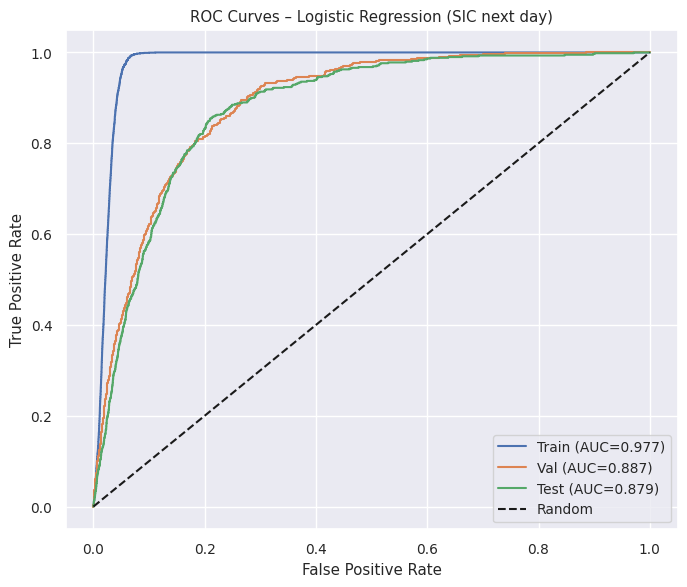

In [ ]:
train_pred = model_logreg.predict_proba(X_train)[:, 1]
val_pred   = model_logreg.predict_proba(X_val)[:, 1]
test_pred  = model_logreg.predict_proba(X_test)[:, 1]

fpr_tr, tpr_tr, _ = roc_curve(y_train, train_pred)
fpr_va, tpr_va, _ = roc_curve(y_val,   val_pred)
fpr_te, tpr_te, _ = roc_curve(y_test,  test_pred)

auc_tr = roc_auc_score(y_train, train_pred)
auc_va = roc_auc_score(y_val,   val_pred)
auc_te = roc_auc_score(y_test,  test_pred)

plt.figure(figsize=(7, 6))
plt.plot(fpr_tr, tpr_tr, label=f"Train (AUC={auc_tr:.3f})")
plt.plot(fpr_va, tpr_va, label=f"Val (AUC={auc_va:.3f})")
plt.plot(fpr_te, tpr_te, label=f"Test (AUC={auc_te:.3f})")
plt.plot([0,1], [0,1], 'k--', label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Logistic Regression (SIC next day)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

This ROC plot compares logistic regression performance across train, validation, and test sets for next-day SIC prediction. The train AUC is very high (0.977), while validation (0.887) and test (0.879) curves overlap closely, indicating good generalization. All curves sit well above the random baseline, showing strong discriminatory power and stable performance on unseen patients.

Plotting the distribution of predicted probabilities for SIC and non-SIC cases in the test set to show how well the model separates the two groups. Adding the chosen decision threshold helps visualize how predictions are classified.

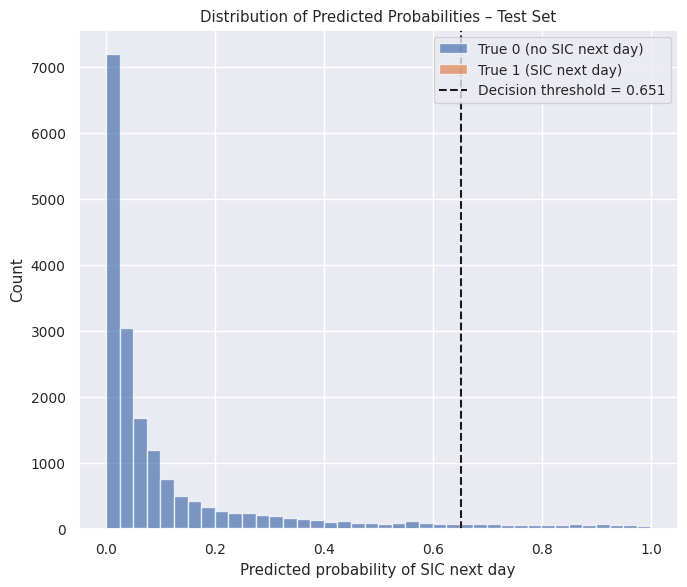

In [ ]:
plt.figure(figsize=(7, 6))

plt.hist(test_pred[y_test == 0],
         bins=40, alpha=0.7, label="True 0 (no SIC next day)")
plt.hist(test_pred[y_test == 1],
         bins=40, alpha=0.7, label="True 1 (SIC next day)")

plt.axvline(best_threshold, color="k", linestyle="--",
            label=f"Decision threshold = {best_threshold:.3f}")

plt.xlabel("Predicted probability of SIC next day")
plt.ylabel("Count")
plt.title("Distribution of Predicted Probabilities – Test Set")
plt.legend()
plt.tight_layout()
plt.show()

This histogram shows the logistic model’s predicted probabilities for SIC and non-SIC patients in the test set. Non-SIC cases cluster near 0, while SIC cases shift toward higher probabilities. The dashed line marks the optimal threshold (≈0.651), with values above it classified as SIC. The separation between the two distributions illustrates how the model distinguishes the groups and how the threshold drives classification.

## XG Boost

In [ ]:
df = pd.read_csv("clean_rework_final_table.csv")

Filtering the dataset to include only rows where SIC has not occurred today but the next-day outcome is known, ensuring valid prediction targets.

In [ ]:
df_model = df[(df["sic_today"] == 0) & df["sic_next_day"].notna()].copy()

label_col = "sic_next_day"
id_cols = ["subject_id", "stay_id", "chart_date"]

y = df_model[label_col].astype(int)

Identifying potential data leakage variables by searching for columns that contain aggregate or score-related terms, then removing them along with ID fields and outcome columns. After filtering, splitting the remaining predictors into numeric and categorical sets to prepare a clean and leakage-free feature list for modeling.

In [ ]:
leakage_keywords = [
    "avg",
    "mean",
    "max",
    "min",
    "_score",
    "score",
]

leakage_cols = []
for c in df_model.columns:
    if any(k in c.lower() for k in leakage_keywords):
        leakage_cols.append(c)

leakage_cols = [c for c in leakage_cols if c not in [label_col, "sic_today"]]

exclude_cols = id_cols + [
    label_col,
    "sic_today",
    "sic_tomorrow",
    "suspected_infection_date",
    "suspected_infection_hour",
] + leakage_cols

feature_cols = [c for c in df_model.columns if c not in exclude_cols]
numeric_cols = df_model[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in feature_cols if c not in numeric_cols]

Splitting the data by unique stay identifiers so that no patient stay appears in more than one dataset, preventing leakage across splits. Then building train, validation, and test sets and separating the feature matrix from the target labels for each split.

In [ ]:
stays = df_model["stay_id"].drop_duplicates()

train_stays, test_stays = train_test_split(stays, test_size=0.2, random_state=42)
train_stays, val_stays  = train_test_split(train_stays, test_size=0.2, random_state=42)

def subset(df, stay_ids):
    return df[df["stay_id"].isin(stay_ids)].copy()

train_df = subset(df_model, train_stays)
val_df   = subset(df_model, val_stays)
test_df  = subset(df_model, test_stays)

X_train = train_df[feature_cols]
X_val   = val_df[feature_cols]
X_test  = test_df[feature_cols]

y_train = train_df[label_col].astype(int)
y_val   = val_df[label_col].astype(int)
y_test  = test_df[label_col].astype(int)

Setting up a preprocessing pipeline that handles numeric and categorical data separately. Numeric features are being median-imputed and standardized, while categorical features are being imputed with the most frequent value and one-hot encoded to prepare everything for model training.

In [ ]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),

        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ]
)

Building an XGBoost classifier inside the preprocessing pipeline and configuring it with moderate depth, sampling, and learning rate settings. Fitting the full pipeline trains both the preprocessing steps and the model in one consistent workflow.

In [ ]:
xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42)

model = Pipeline([
    ("preprocess", preprocess),
    ("xgb", xgb),
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sepsis_day',
                                                   'vasopressor_use', 'mi',
                                                   'chf', 'malignant_cancer',
                                                   'metastatic_solid_tumor',
                                                   'severe_liver_disease',
                                                   'chronic_pulmonary_disease',
                                                   'mild_liver_disease',
                                                   'diabetes_with_cc',
                                                   'diabetes_wi...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None, ...))])

Evaluating the XGBoost model by computing validation AUC and finding the probability threshold that maximizes the F1 score. Using that threshold to binarize test predictions.

In [ ]:
val_pred = model.predict_proba(X_val)[:, 1]
print("Validation AUC:", roc_auc_score(y_val, val_pred))

prec, rec, thresh = precision_recall_curve(y_val, val_pred)

f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
best_threshold = thresh[f1[:-1].argmax()]

print("Best threshold =", best_threshold)

test_pred = model.predict_proba(X_test)[:, 1]
print("Test AUC:", roc_auc_score(y_test, test_pred))

y_test_bin = (test_pred > best_threshold).astype(int)
print(classification_report(y_test, y_test_bin))

Validation AUC: 0.8771248657732149
Best threshold = 0.10524574
Test AUC: 0.8721666250251427
              precision    recall  f1-score   support

           0       0.98      0.93      0.96     18791
           1       0.17      0.42      0.24       590

    accuracy                           0.92     19381
   macro avg       0.58      0.68      0.60     19381
weighted avg       0.96      0.92      0.94     19381



Plotting ROC curves for the XGBoost model on the train, validation, and test sets to assess discrimination performance across splits. Including the random baseline makes it easy to see how much better the model performs than chance.


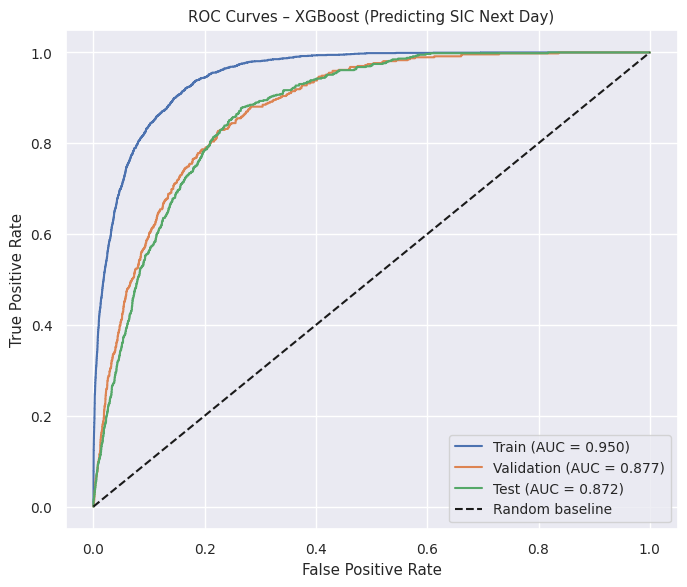

In [ ]:
train_pred = model.predict_proba(X_train)[:, 1]
val_pred   = model.predict_proba(X_val)[:, 1]
test_pred  = model.predict_proba(X_test)[:, 1]

fpr_tr, tpr_tr, _ = roc_curve(y_train, train_pred)
fpr_va, tpr_va, _ = roc_curve(y_val,   val_pred)
fpr_te, tpr_te, _ = roc_curve(y_test,  test_pred)

auc_tr = roc_auc_score(y_train, train_pred)
auc_va = roc_auc_score(y_val,   val_pred)
auc_te = roc_auc_score(y_test,  test_pred)

plt.figure(figsize=(7, 6))
plt.plot(fpr_tr, tpr_tr, label=f"Train (AUC = {auc_tr:.3f})")
plt.plot(fpr_va, tpr_va, label=f"Validation (AUC = {auc_va:.3f})")
plt.plot(fpr_te, tpr_te, label=f"Test (AUC = {auc_te:.3f})")
plt.plot([0,1], [0,1], "k--", label="Random baseline")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – XGBoost (Predicting SIC Next Day)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

This ROC plot compares XGBoost performance across train, validation, and test sets for next-day SIC prediction. The training curve is near perfect, while validation and test curves overlap closely, indicating good generalization with only modest overfitting. All curves sit well above the random baseline, showing strong discriminatory power that remains stable on new patient data.

## Light GBM

In [ ]:
df = pd.read_csv("clean_rework_final_table.csv")

Filtering the dataset to include only rows where today’s SIC is zero and tomorrow’s SIC label is available. Then defining the target column and converting it to integers while keeping ID fields separate for later reference.

In [ ]:
df_model = df[(df["sic_today"] == 0) & df["sic_next_day"].notna()].copy()

label_col = "sic_next_day"
id_cols = ["subject_id", "stay_id", "chart_date"]

y = df_model[label_col].astype(int)

Searching for columns whose names indicate aggregation or scoring to avoid data leakage and adding them to an exclusion list. Removing those along with IDs and outcome fields, then separating the remaining predictors into numeric and categorical groups.

In [ ]:
leakage_keywords = [
    "avg", "mean", "max", "min", "_score", "score"
]

leakage_cols = []
for c in df_model.columns:
    if any(k in c.lower() for k in leakage_keywords):
        leakage_cols.append(c)

leakage_cols = [c for c in leakage_cols if c not in [label_col, "sic_today"]]

exclude_cols = id_cols + [
    label_col,
    "sic_today",
    "sic_tomorrow",
    "suspected_infection_date",
    "suspected_infection_hour",
] + leakage_cols

feature_cols = [c for c in df_model.columns if c not in exclude_cols]
numeric_cols = df_model[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in feature_cols if c not in numeric_cols]

Splitting the dataset by unique stay IDs so that no patient stay appears in more than one partition. Then subsetting the data accordingly and extracting feature matrices and target labels for the train, validation, and test sets.

In [ ]:
stays = df_model["stay_id"].drop_duplicates()

train_stays, test_stays = train_test_split(stays, test_size=0.2, random_state=42)
train_stays, val_stays  = train_test_split(train_stays, test_size=0.2, random_state=42)

def subset(df, stay_ids):`
    return df[df["stay_id"].isin(stay_ids)].copy()

train_df = subset(df_model, train_stays)
val_df   = subset(df_model, val_stays)
test_df  = subset(df_model, test_stays)

X_train = train_df[feature_cols]
X_val   = val_df[feature_cols]
X_test  = test_df[feature_cols]

y_train = train_df[label_col].astype(int)
y_val   = val_df[label_col].astype(int)
y_test  = test_df[label_col].astype(int)

Setting up a preprocessing step that imputes missing numeric values with medians, and for categorical features applies most-frequent imputation followed by one-hot encoding.

In [ ]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ]
)

Building a LightGBM classifier wrapped inside the preprocessing pipeline and configuring it with balanced class weights and moderate regularization settings. Fitting the full pipeline trains both preprocessing and the model together.

In [ ]:
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=-1,
    num_leaves=48,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42
)

model_lgbm = Pipeline([
    ("preprocess", preprocess),
    ("lgbm", lgbm),
])

model_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 2025, number of negative: 60803
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2659
[LightGBM] [Info] Number of data points in the train set: 62828, number of used features: 849
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['sepsis_day',
                                                   'vasopressor_use', 'mi',
                                                   'chf', 'malignant_cancer',
                                                   'metastatic_solid_tumor',
                                                   'severe_liver_disease',
                                                   'chronic_pulmonary_disease',
                                                   'mild_liver_disease',
                                                   'diabetes_with_cc',
                                                   'diabetes_without_cc',
                                                   'renal_disease', 'stroke',
                                                   'sw_respiration', 'sw_li...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['suspected_infection_time',
                                                   'infection_date', 'race',
                                                   'admission_type',
                                                   'gender'])])),
                ('lgbm',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
                                learning_rate=0.03, n_estimators=500,
                                num_leaves=48, random_state=42,
                                subsample=0.8))])

Evaluating the LightGBM model by measuring validation AUC and selecting the probability threshold that yields the highest F1 score. Applying that threshold to test predictions, then reporting the test AUC and full classification metrics to assess model performance.

In [ ]:
val_pred = model_lgbm.predict_proba(X_val)[:, 1]
print("Validation AUC:", roc_auc_score(y_val, val_pred))

prec, rec, thresh = precision_recall_curve(y_val, val_pred)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
best_threshold = thresh[f1[:-1].argmax()]

print("Best threshold =", best_threshold)

test_pred = model_lgbm.predict_proba(X_test)[:, 1]
print("Test AUC:", roc_auc_score(y_test, test_pred))

y_test_bin = (test_pred > best_threshold).astype(int)
print(classification_report(y_test, y_test_bin))

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Validation AUC: 0.8678100810593695
Best threshold = 0.6399373410182744


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test AUC: 0.8591508376260182
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     18791
           1       0.16      0.43      0.23       590

    accuracy                           0.91     19381
   macro avg       0.57      0.68      0.59     19381
weighted avg       0.96      0.91      0.93     19381



Plotting ROC curves for the train, validation, and test sets to compare LightGBM's performance across splits.

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


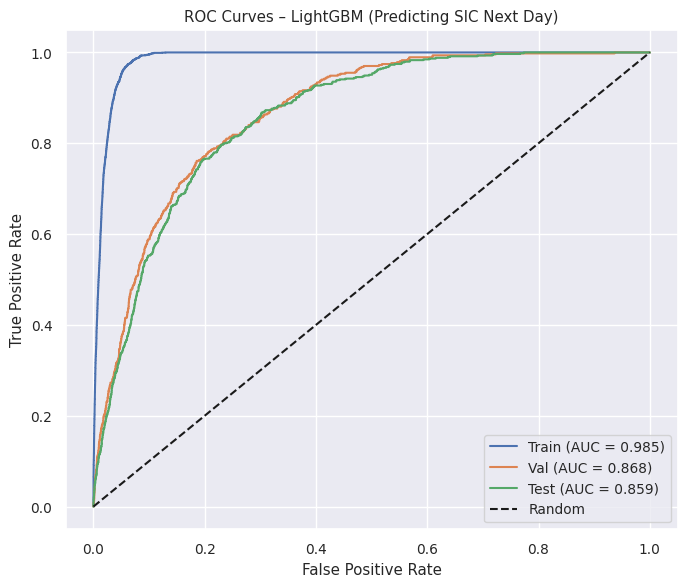

In [ ]:
train_pred = model_lgbm.predict_proba(X_train)[:, 1]
val_pred   = model_lgbm.predict_proba(X_val)[:, 1]
test_pred  = model_lgbm.predict_proba(X_test)[:, 1]

fpr_tr, tpr_tr, _ = roc_curve(y_train, train_pred)
fpr_va, tpr_va, _ = roc_curve(y_val,   val_pred)
fpr_te, tpr_te, _ = roc_curve(y_test,  test_pred)

auc_tr = roc_auc_score(y_train, train_pred)
auc_va = roc_auc_score(y_val,   val_pred)
auc_te = roc_auc_score(y_test,  test_pred)

plt.figure(figsize=(7, 6))
plt.plot(fpr_tr, tpr_tr, label=f"Train (AUC = {auc_tr:.3f})")
plt.plot(fpr_va, tpr_va, label=f"Val (AUC = {auc_va:.3f})")
plt.plot(fpr_te, tpr_te, label=f"Test (AUC = {auc_te:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – LightGBM (Predicting SIC Next Day)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

This ROC plot shows LightGBM performance across train, validation, and test sets for next-day SIC prediction. The model fits the training data very well (AUC ≈ 0.985), while validation (0.868) and test (0.859) curves remain close, indicating stable generalization. All curves lie well above the random baseline, showing strong discriminatory power on both seen and unseen patients.

## CatBoost

In [ ]:
df = pd.read_csv('clean_rework_final_table.csv')

In [ ]:
df.head(2)

subject_id   stay_id  chart_date suspected_infection_time infection_date  \
0    10001843  39698942  2134-12-05      2134-12-05 19:23:00     2134-12-05   
1    10001884  37510196  2131-01-14      2131-01-10 16:36:00     2131-01-10   

   sepsis_day  max_heart_rate  min_mbp  max_resp_rate  min_spo2  ...  \
0           0           155.0     61.0           26.0      88.0  ...   
1           4            79.0     90.0           29.5      96.0  ...   

   pco2_avg_measured  po2_avg_measured  baseexcess_avg_measured  \
0                  1                 1                        1   
1                  1                 1                        1   

   totalco2_avg_measured  min_minute_volume_measured  \
0                      1                           1   
1                      1                           1   

   max_minute_volume_measured  mean_minute_volume_measured  min_peep_measured  \
0                           1                            1                  1   
1                           1                            1                  1   

   max_peep_measured  mean_peep_measured  
0                  1                   1  
1                  1                   1  

[2 rows x 92 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115801 entries, 0 to 115800
Data columns (total 92 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   subject_id                   115801 non-null  int64  
 1   stay_id                      115801 non-null  int64  
 2   chart_date                   115801 non-null  object 
 3   suspected_infection_time     115801 non-null  object 
 4   infection_date               115801 non-null  object 
 5   sepsis_day                   115801 non-null  int64  
 6   max_heart_rate               115801 non-null  float64
 7   min_mbp                      115801 non-null  float64
 8   max_resp_rate                115801 non-null  float64
 9   min_spo2                     115801 non-null  float64
 10  max_temperature              115801 non-null  float64
 11  mean_heart_rate              115801 non-null  float64
 12  mean_mbp                     115801 non-null  float64
 13 

In [ ]:
df.describe()

subject_id       stay_id     sepsis_day  max_heart_rate  \
count  1.158010e+05  1.158010e+05  115801.000000   115801.000000   
mean   1.501781e+07  3.497284e+07       6.178289      105.223464   
std    2.894612e+06  2.879781e+06       7.375147       20.886944   
min    1.000184e+07  3.000048e+07       0.000000       36.000000   
25%    1.250625e+07  3.249268e+07       1.000000       90.000000   
50%    1.503239e+07  3.495857e+07       3.000000      104.000000   
75%    1.752974e+07  3.746634e+07       8.000000      118.000000   
max    1.999944e+07  3.999923e+07      40.000000      238.000000   

             min_mbp  max_resp_rate       min_spo2  max_temperature  \
count  115801.000000  115801.000000  115801.000000    115801.000000   
mean       61.057314      28.944711      92.377069        37.439746   
std        11.455567       6.830423       5.189967         0.763034   
min        21.000000       5.000000      41.000000        30.100000   
25%        54.000000      24.000000      91.000000        36.940000   
50%        60.000000      28.000000      93.000000        37.280000   
75%        67.000000      33.000000      95.000000        37.830000   
max       188.000000      60.000000     100.000000        42.700000   

       mean_heart_rate       mean_mbp  ...  pco2_avg_measured  \
count    115801.000000  115801.000000  ...      115801.000000   
mean         88.475524      77.624187  ...           0.660936   
std          16.335228      11.049349  ...           0.473394   
min          33.500000      30.000000  ...           0.000000   
25%          76.791667      70.034483  ...           0.000000   
50%          87.520000      75.909091  ...           1.000000   
75%          99.333333      83.680000  ...           1.000000   
max         176.791667     188.000000  ...           1.000000   

       po2_avg_measured  baseexcess_avg_measured  totalco2_avg_measured  \
count     115801.000000            115801.000000          115801.000000   
mean           0.661039                 0.660936               0.660936   
std            0.473359                 0.473394               0.473394   
min            0.000000                 0.000000               0.000000   
25%            0.000000                 0.000000               0.000000   
50%            1.000000                 1.000000               1.000000   
75%            1.000000                 1.000000               1.000000   
max            1.000000                 1.000000               1.000000   

       min_minute_volume_measured  max_minute_volume_measured  \
count               115801.000000               115801.000000   
mean                     0.627145                    0.627145   
std                      0.483566                    0.483566   
min                      0.000000                    0.000000   
25%                      0.000000                    0.000000   
50%                      1.000000                    1.000000   
75%                      1.000000                    1.000000   
max                      1.000000                    1.000000   

       mean_minute_volume_measured  min_peep_measured  max_peep_measured  \
count                115801.000000      115801.000000      115801.000000   
mean                      0.627145           0.628138           0.628138   
std                       0.483566           0.483304           0.483304   
min                       0.000000           0.000000           0.000000   
25%                       0.000000           0.000000           0.000000   
50%                       1.000000           1.000000           1.000000   
75%                       1.000000           1.000000           1.000000   
max                       1.000000           1.000000           1.000000   

       mean_peep_measured  
count       115801.000000  
mean             0.628138  
std              0.483304  
min              0.000000  
25%              0.000000  
50%              1.000000  
75%              1.000000  

In [ ]:
df.shape

(115801, 92)

### Checking for Collinearity and Dropping Columns

Looping through numerical features in manageable batches and generating correlation heatmaps for each subset.

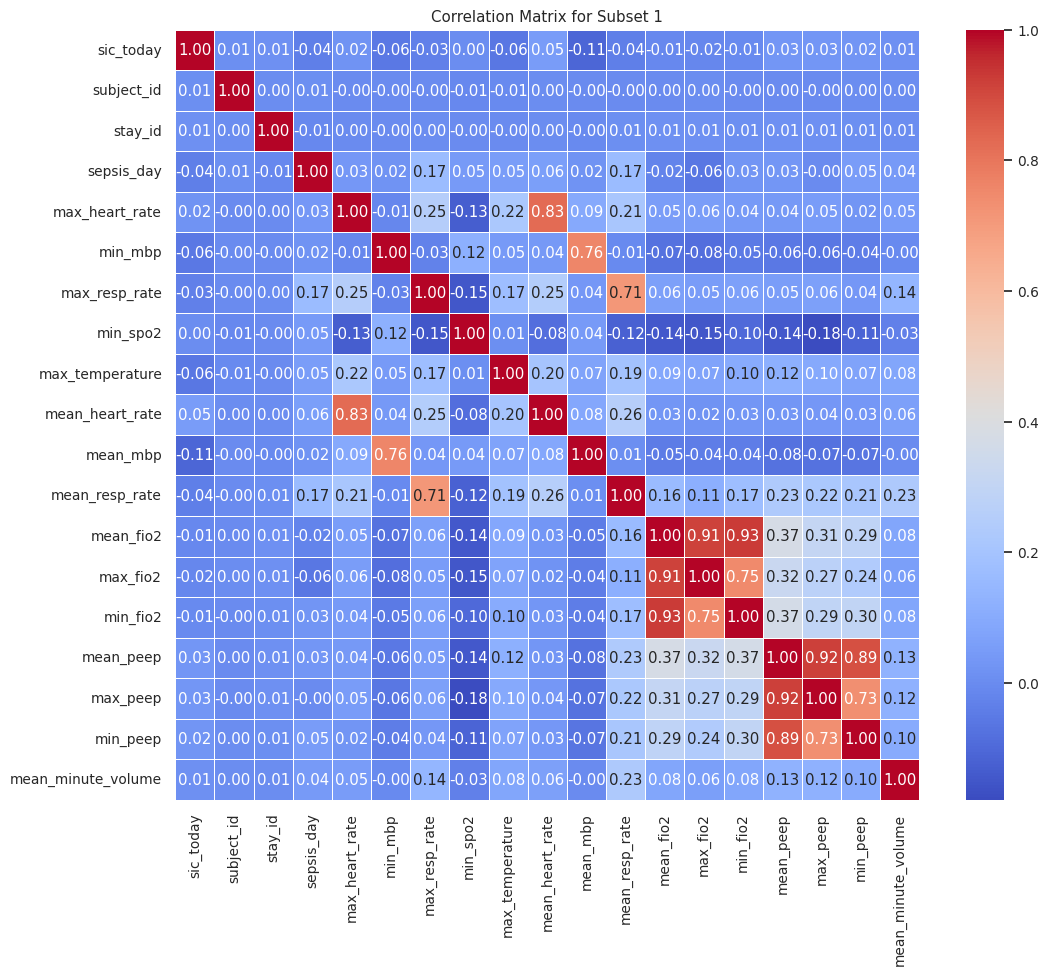

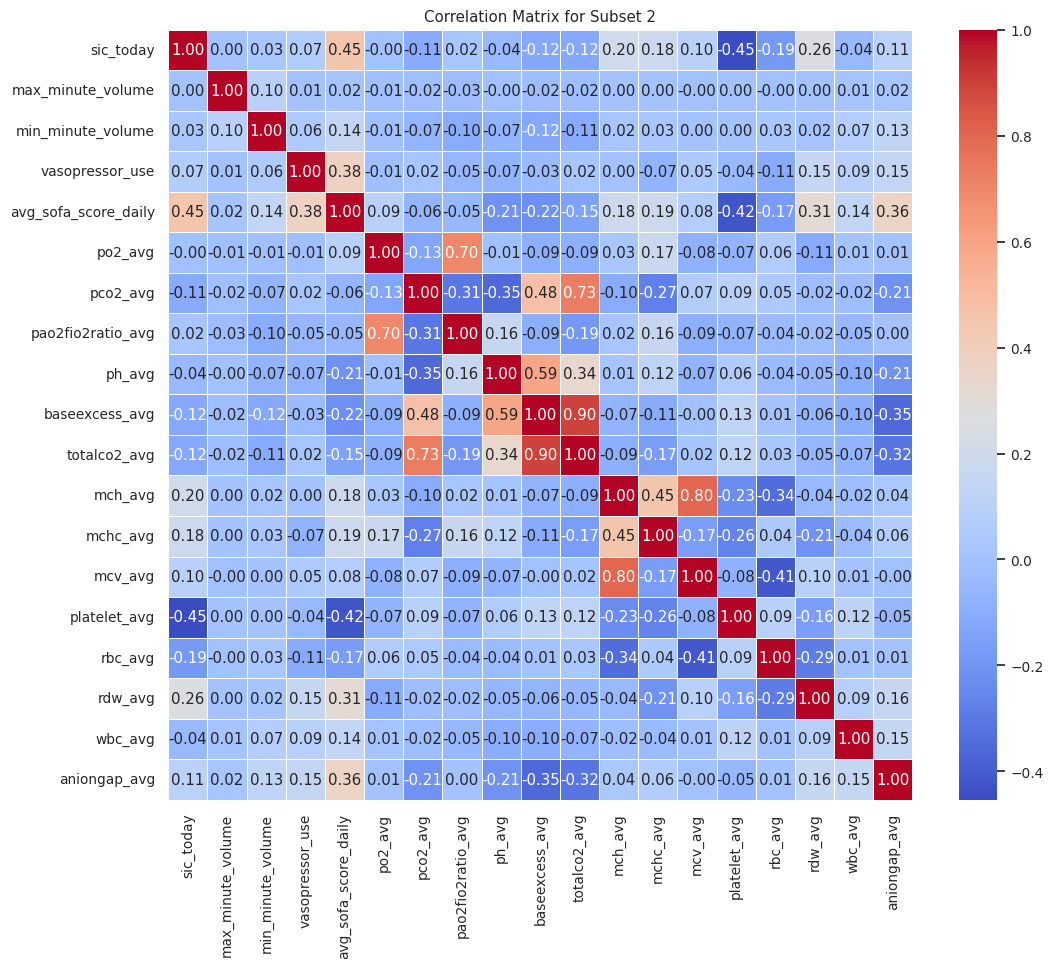

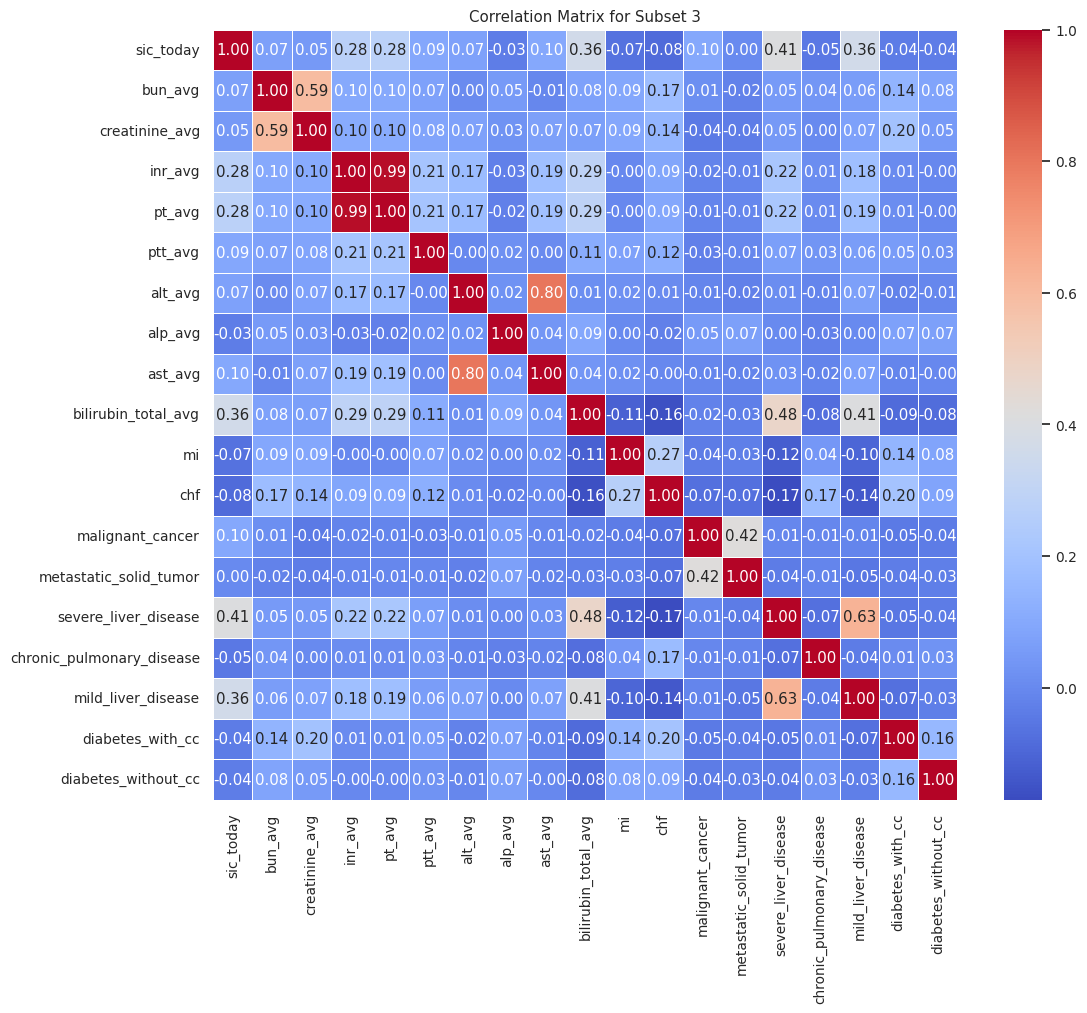

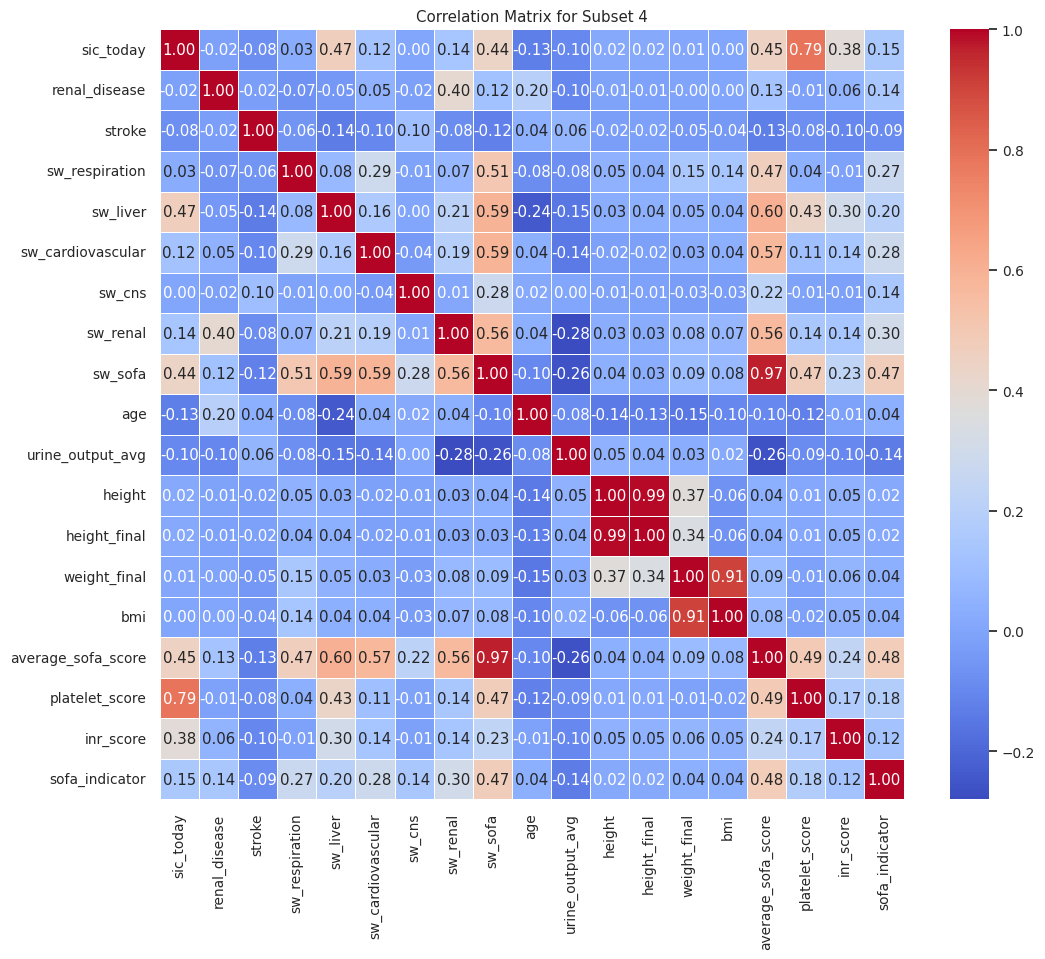

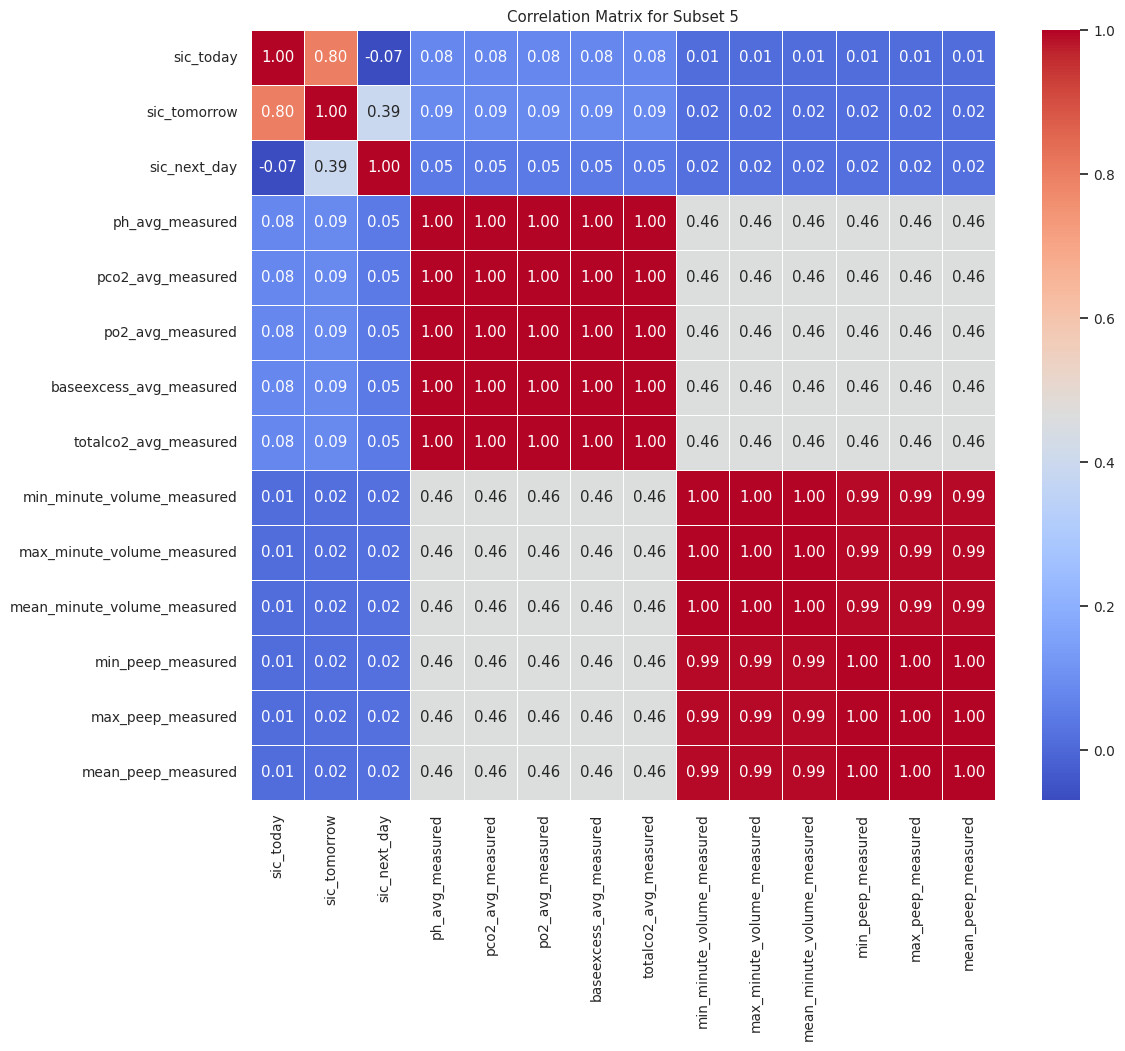

In [ ]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

target_column = 'sic_today'
numerical_columns = [col for col in numerical_columns if col != target_column]  # Remove 'sic_today' for now

subset_size = 18

for i in range(0, len(numerical_columns), subset_size):
    subset = numerical_columns[i:i + subset_size]

    subset = [target_column] + subset

    df_subset = df[subset]

    correlation_matrix = df_subset.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(f"Correlation Matrix for Subset {i//subset_size + 1}")
    plt.show()

These five heatmaps break the numerical features into manageable subsets, making correlation patterns easier to interpret. Vital signs, ABG markers, coagulation labs, SOFA components, and measurement flags each form clear internal clusters. Moderately strong and clinically meaningful correlations with SIC appear mainly in platelet measures, SOFA scores, liver markers, and selected biomarkers, while demographics and measurement indicators show little relationship. Overall, the subset approach clarifies multicollinearity and highlights the features most relevant to SIC.

Computing absolute correlations among all numeric features and identifying pairs with extremely high correlation above 0.95.

In [ ]:
num_df = df.select_dtypes(include=[np.number])

corr_matrix = num_df.corr().abs()

high_corr = np.where(corr_matrix > 0.95)
high_corr_pairs = [
    (num_df.columns[x], num_df.columns[y], corr_matrix.iloc[x, y])
    for x, y in zip(*high_corr)
    if x != y and x < y
]

high_corr_pairs[:40]

[('avg_sofa_score_daily', 'sw_sofa', 0.9703188036860906),
 ('avg_sofa_score_daily', 'average_sofa_score', 0.9998794757235538),
 ('inr_avg', 'pt_avg', 0.98873313605508),
 ('sw_sofa', 'average_sofa_score', 0.9695637252368179),
 ('height', 'height_final', 0.9914182868097117),
 ('ph_avg_measured', 'pco2_avg_measured', 0.9999036652860523),
 ('ph_avg_measured', 'po2_avg_measured', 0.9997495419859356),
 ('ph_avg_measured', 'baseexcess_avg_measured', 0.9998651313262225),
 ('ph_avg_measured', 'totalco2_avg_measured', 0.9998651313262361),
 ('pco2_avg_measured', 'po2_avg_measured', 0.9997688043258551),
 ('pco2_avg_measured', 'baseexcess_avg_measured', 0.9999614658012248),
 ('pco2_avg_measured', 'totalco2_avg_measured', 0.9999614658012186),
 ('po2_avg_measured', 'baseexcess_avg_measured', 0.9997688043258371),
 ('po2_avg_measured', 'totalco2_avg_measured', 0.999768804325855),
 ('baseexcess_avg_measured', 'totalco2_avg_measured', 0.999961465801227),
 ('min_minute_volume_measured', 'max_minute_volume

Selecting all numeric columns and computing their full correlation matrix.


In [ ]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

df_numerical = df[numerical_columns]

correlation_matrix = df_numerical.corr()

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
correlation_matrix

subject_id   stay_id  sepsis_day  max_heart_rate  \
subject_id                     1.000000  0.002123    0.007030       -0.002327   
stay_id                        0.002123  1.000000   -0.009577        0.000249   
sepsis_day                     0.007030 -0.009577    1.000000        0.033554   
max_heart_rate                -0.002327  0.000249    0.033554        1.000000   
min_mbp                       -0.001460 -0.003669    0.021734       -0.014791   
max_resp_rate                 -0.001171  0.002991    0.165454        0.253556   
min_spo2                      -0.008845 -0.003649    0.045843       -0.128291   
max_temperature               -0.007881 -0.001662    0.054358        0.217800   
mean_heart_rate                0.001221  0.001380    0.058092        0.826156   
mean_mbp                      -0.001276 -0.004617    0.022868        0.093200   
mean_resp_rate                -0.000623  0.008731    0.166016        0.209163   
mean_fio2                      0.000629  0.010276   -0.024212        0.054675   
max_fio2                       0.000781  0.011004   -0.062012        0.055421   
min_fio2                      -0.000460  0.007703    0.027036        0.044479   
mean_peep                      0.000247  0.013216    0.029155        0.039887   
max_peep                      -0.000502  0.013923   -0.000902        0.048073   
min_peep                       0.001930  0.008027    0.047827        0.024735   
mean_minute_volume             0.001600  0.005319    0.043077        0.050245   
max_minute_volume              0.000289  0.001092    0.014373        0.011941   
min_minute_volume              0.005484  0.007805    0.038192        0.067722   
vasopressor_use               -0.014188  0.012187    0.194929        0.054604   
avg_sofa_score_daily          -0.003758  0.022607    0.003224        0.033836   
po2_avg                       -0.002202  0.005179   -0.124016       -0.045096   
pco2_avg                      -0.000119  0.010480    0.061897        0.022054   
pao2fio2ratio_avg             -0.001975 -0.007124   -0.022354       -0.052862   
ph_avg                         0.012859 -0.008261    0.108140       -0.050112   
baseexcess_avg                 0.009577  0.002074    0.146994       -0.027438   
totalco2_avg                   0.007280  0.009197    0.118392       -0.007584   
mch_avg                        0.003399  0.006921   -0.000937       -0.016749   
mchc_avg                       0.003119  0.002020   -0.192438       -0.022466   
mcv_avg                        0.000682  0.005905    0.132724       -0.002696   
platelet_avg                  -0.006516 -0.012227    0.187438        0.037359   
rbc_avg                        0.008132 -0.011872   -0.240501        0.003097   
rdw_avg                       -0.005671  0.013353    0.247000        0.038869   
wbc_avg                       -0.008553  0.006467    0.033336        0.079672   
aniongap_avg                  -0.012489  0.009541   -0.011727        0.056787   
bun_avg                       -0.013300  0.005573    0.117073       -0.035270   
creatinine_avg                -0.026111  0.001958   -0.015470       -0.035546   
inr_avg                       -0.004716  0.010343   -0.057138        0.035918   
pt_avg                        -0.004631  0.009747   -0.059161        0.037229   
ptt_avg                        0.004002  0.008402    0.075284        0.037016   
alt_avg                       -0.002037  0.008615   -0.080386        0.021166   
alp_avg                       -0.022653  0.001457    0.205243        0.010710   
ast_avg                        0.008560  0.005428   -0.081307        0.024604   
bilirubin_total_avg            0.014134  0.018452    0.123867       -0.055351   
mi                            -0.010723  0.010651   -0.005161       -0.024083   
chf                           -0.000614 -0.016021   -0.016787       -0.019602   
malignant_cancer              -0.005605  0.020405   -0.039816        0.065002   
metastatic_solid_tumor         0.002599  0.003920   -0.04910

Removing ID fields, outcome variables, scoring fields, and other columns that should not be used as predictors. The remaining columns form the clean feature set to be used for modeling.

In [ ]:
exclude_cols = [
    "subject_id","stay_id","chart_date",
    "sic_today","sic_tomorrow","sic_next_day",
    "platelet_score","inr_score","sofa_indicator",
    "suspected_infection_date","suspected_infection_hour",
    "sofa_bin","avg_sofa_score_daily","enzyme_obs_count","bg_obs_count",'suspected_infection_time',
 'infection_date','height'
]

all_cols = df.columns.tolist()
feature_cols = [c for c in all_cols if c not in exclude_cols]

Filtering the dataset to rows where today's SIC is absent and tomorrow's SIC label is available, ensuring valid prediction targets. Converting key timestamp fields to datetime format for proper handling.


In [ ]:
df_sic = df[(df["sic_today"] == 0) & df["sic_next_day"].notna()].copy()
df_sic["suspected_infection_time"] = pd.to_datetime(df_sic["suspected_infection_time"])
df_sic["infection_date"] = pd.to_datetime(df_sic["infection_date"])
df_sic["chart_date"] = pd.to_datetime(df_sic["chart_date"])
# label="sic_tomorrow"
label = "sic_next_day"

Dropping a curated list of columns that are either redundant, highly correlated, leakage-prone, or not useful for modeling. Filtering the list to keep only columns that actually exist in the dataframe.

In [ ]:
cols_to_drop = [
    "min_peep_measured",
    "max_peep_measured",
    "min_minute_volume_measured",
    "max_minute_volume_measured",
    "totalco2_avg_measured",
    "baseexcess_avg_measured",
    "avg_sofa_score_daily",
    "sw_sofa",
    "min_fio2",
    "max_fio2",
    "min_peep",
    "max_peep",
    "weight_final",
    "max_heart_rate",
    "ast_avg",
    "mcv_avg",
]

cols_to_drop = [c for c in cols_to_drop if c in df_sic.columns]

df_sic = df_sic.drop(columns=cols_to_drop)

print("Dropped columns:")
print(cols_to_drop)

print("\nFinal columns:")
print(df_sic.columns.tolist())

Dropped columns:
['min_peep_measured', 'max_peep_measured', 'min_minute_volume_measured', 'max_minute_volume_measured', 'totalco2_avg_measured', 'baseexcess_avg_measured', 'avg_sofa_score_daily', 'sw_sofa', 'min_fio2', 'max_fio2', 'min_peep', 'max_peep', 'weight_final', 'max_heart_rate', 'ast_avg', 'mcv_avg']

Final columns:
['subject_id', 'stay_id', 'chart_date', 'suspected_infection_time', 'infection_date', 'sepsis_day', 'min_mbp', 'max_resp_rate', 'min_spo2', 'max_temperature', 'mean_heart_rate', 'mean_mbp', 'mean_resp_rate', 'mean_fio2', 'mean_peep', 'mean_minute_volume', 'max_minute_volume', 'min_minute_volume', 'vasopressor_use', 'po2_avg', 'pco2_avg', 'pao2fio2ratio_avg', 'ph_avg', 'baseexcess_avg', 'totalco2_avg', 'mch_avg', 'mchc_avg', 'platelet_avg', 'rbc_avg', 'rdw_avg', 'wbc_avg', 'aniongap_avg', 'bun_avg', 'creatinine_avg', 'inr_avg', 'pt_avg', 'ptt_avg', 'alt_avg', 'alp_avg', 'bilirubin_total_avg', 'mi', 'chf', 'malignant_cancer', 'metastatic_solid_tumor', 'severe_liver_d

In [ ]:
df_sic.shape

(97876, 76)

In [ ]:
df_sic["sic_next_day"].value_counts()

sic_next_day
0    94792
1     3084
Name: count, dtype: int64

In [ ]:
df_sic["sic_today"].value_counts()

sic_today
0.0    97876
Name: count, dtype: int64

In [ ]:
df["sic_today"].value_counts()

sic_today
0.0    97876
1.0    17355
Name: count, dtype: int64

In [ ]:
df["sic_tomorrow"].value_counts()

sic_tomorrow
0    98245
1    17556
Name: count, dtype: int64

### EDA

Calculating the proportion of missing values for each feature and plotting the top ones with the highest missingness. This visual helps identify problematic variables that may need imputation, removal, or special handling.

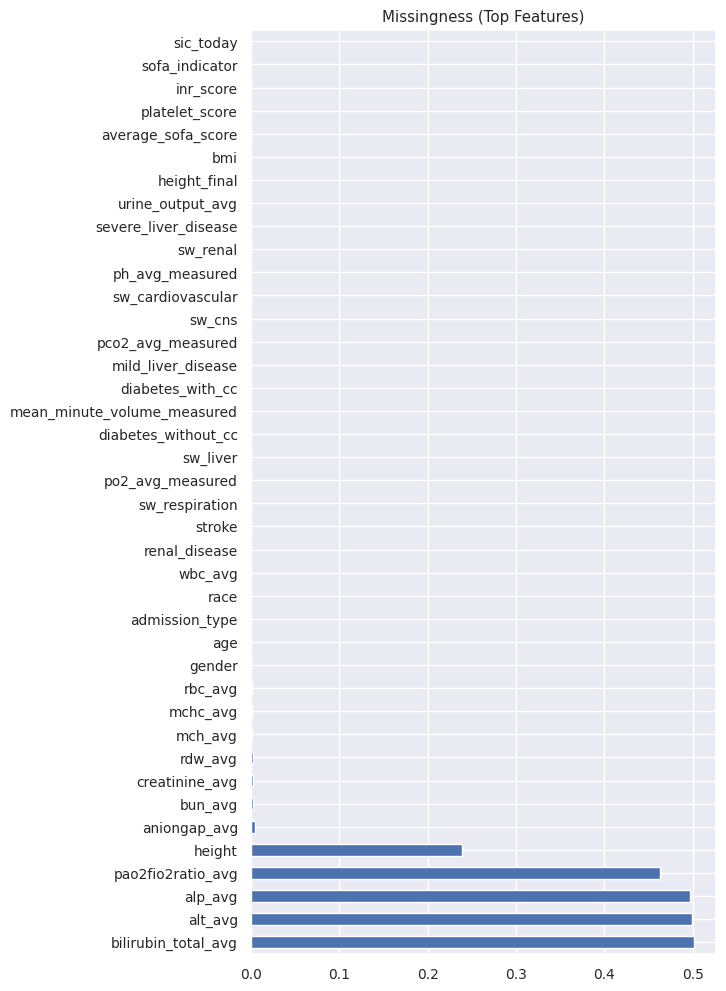

In [ ]:
missing = df_sic.isna().mean().sort_values(ascending=False)
plt.figure(figsize=(6,12))
missing.head(40).plot(kind="barh")
plt.title("Missingness (Top Features)")
plt.show()

This bar plot highlights the features with the highest missing-data rates. Several labs, including bilirubin_total_avg, alt_avg, alp_avg, and pao2fio2ratio_avg, have nearly 50% missingness, and height is also moderately missing, while most other variables are largely complete. The plot helps identify which features need careful imputation or special handling before modeling.

Plotting distributions for several clinically important variables to inspect their shapes and detect skewness, outliers, or unusual patterns.

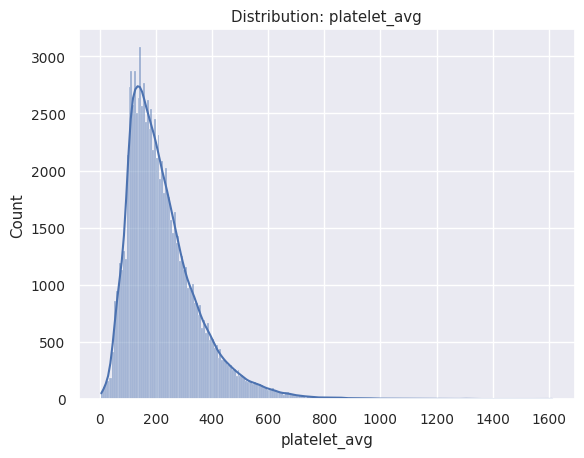

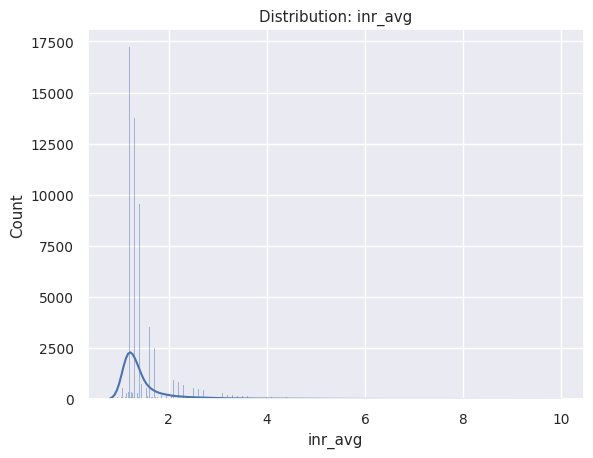

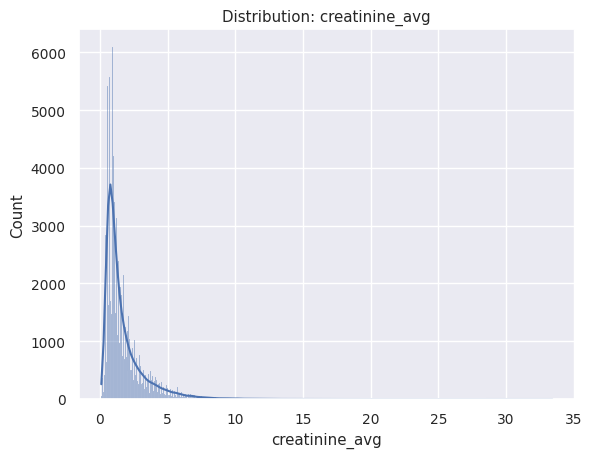

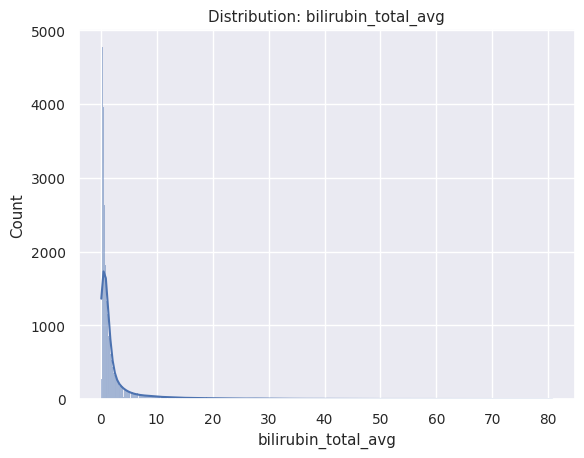

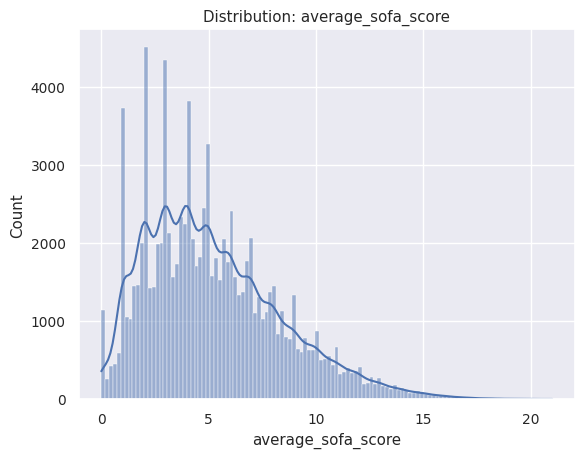

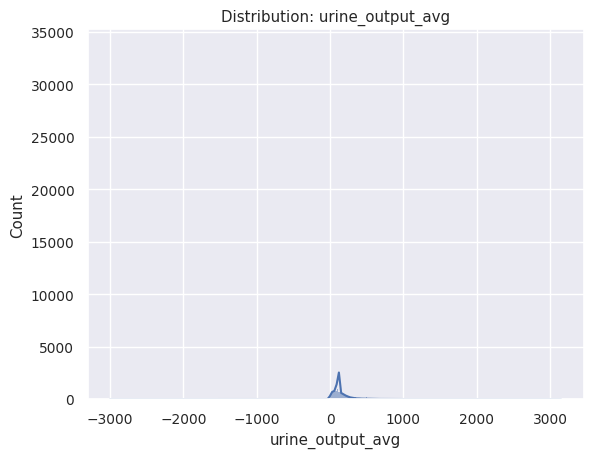

In [ ]:
key_vars = ["platelet_avg","inr_avg","creatinine_avg","bilirubin_total_avg","average_sofa_score","urine_output_avg"]

for var in key_vars:
    sns.histplot(df_sic[var], kde=True)
    plt.title(f"Distribution: {var}")
    plt.show()

These histograms show the distributions of key variables used in SIC prediction. Most features, including platelet_avg, inr_avg, creatinine_avg, bilirubin_total_avg, and urine_output_avg, are strongly right-skewed with notable outliers, while average_sofa_score has a broader spread reflecting varied illness severity. Overall, the plots highlight substantial skewness in many clinical measures, suggesting the need for transformations or robust modeling approaches.

In [ ]:
df['urine_output_avg'].describe()

count    115801.000000
mean        129.904050
std         104.924478
min       -3000.000000
25%          83.214286
50%         110.000000
75%         141.923077
max        3150.000000
Name: urine_output_avg, dtype: float64

In [ ]:
df['platelet_avg'].describe()

count    115231.000000
mean        200.436676
std         133.864503
min           5.000000
25%         104.500000
50%         174.000000
75%         265.000000
max        1611.750000
Name: platelet_avg, dtype: float64

Applying winsorization to the key variables by clipping extreme lower and upper values to the 1st and 99th percentiles.

In [ ]:
def winsorize(s, lower=0.01, upper=0.99):
    return s.clip(s.quantile(lower), s.quantile(upper))

for col in key_vars:
    df_sic[col] = winsorize(df_sic[col])

In [ ]:
df_sic['urine_output_avg'].describe()

count    97876.000000
mean       132.704817
std         97.467270
min          3.712798
25%         88.459790
50%        110.000000
75%        149.122609
max        587.500000
Name: urine_output_avg, dtype: float64

In [ ]:
df_sic['platelet_avg'].describe()

count    97876.000000
mean       224.767539
std        122.411896
min         48.500000
25%        135.250000
50%        197.000000
75%        285.000000
max        656.250000
Name: platelet_avg, dtype: float64

### Data Preparation

Adding temporal features by sorting each stay chronologically and creating lag-1 values along with one-step deltas for selected clinical variables.

In [ ]:
def add_temporal(df, cols):
    df = df.sort_values(["stay_id","chart_date"])
    for c in cols:
        df[f"{c}_lag1"] = df.groupby("stay_id")[c].shift(1)
        df[f"{c}_delta1"] = df[c] - df[f"{c}_lag1"]
    return df

temporal_cols = [
    "platelet_avg","inr_avg","pt_avg","ptt_avg",
    "creatinine_avg","average_sofa_score","urine_output_avg"
]

df_sic = add_temporal(df_sic, temporal_cols)

Building the final feature list by removing excluded columns and the target label, then splitting the remaining predictors into numeric and categorical groups.

In [ ]:
feature_cols = [c for c in df_sic.columns
                if c not in exclude_cols and c != label]

numeric_cols = df_sic[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in feature_cols if c not in numeric_cols]

In [ ]:
len(numeric_cols)

75

### Model Training and Fitting

Splitting the dataset by unique stays so each patient stay appears in only one partition, preventing information leakage. Then creating the train, validation, and test subsets and separating features from labels for each split.


In [ ]:
stays = df_sic["stay_id"].unique()
train_stays, test_stays = train_test_split(stays, test_size=0.2, random_state=42)
train_stays, val_stays = train_test_split(train_stays, test_size=0.2, random_state=42)

def subset(df, ids): return df[df["stay_id"].isin(ids)].copy()

train_df = subset(df_sic, train_stays)
val_df   = subset(df_sic, val_stays)
test_df  = subset(df_sic, test_stays)

X_train, y_train = train_df[feature_cols], train_df[label]
X_val,   y_val   = val_df[feature_cols],   val_df[label]
X_test,  y_test  = test_df[feature_cols],  test_df[label]

Converting all categorical variables to strings and filling missing entries with a placeholder value.

In [ ]:
for c in cat_cols:
    df_sic.loc[:, c] = df_sic[c].astype(str).fillna("NA")

In [ ]:
for c in cat_cols:
    X_train.loc[:, c] = X_train[c].astype(str).fillna("NA")
    X_val.loc[:, c]   = X_val[c].astype(str).fillna("NA")
    X_test.loc[:, c]  = X_test[c].astype(str).fillna("NA")

In [ ]:
cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]

Creating CatBoost Pool objects for the train, validation, and test datasets while specifying which columns are categorical.

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=cat_idx)
val_pool   = Pool(X_val, y_val, cat_features=cat_idx)
test_pool  = Pool(X_test, y_test, cat_features=cat_idx)

Initializing a CatBoost classifier with conservative regularization and early stopping settings, along with class weighting to handle imbalance. Training the model on the training pool while monitoring validation performance and keeping the best iteration based on AUC.

In [ ]:
model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    iterations=1000,
    depth=4,
    learning_rate=0.001,
    l2_leaf_reg=100,
    random_strength=1.0,
    od_type='Iter',
    scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum(),
    od_wait=50,
    random_seed=42,
    verbose=100
)

model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True
)

0:	test: 0.8930178	best: 0.8930178 (0)	total: 86.8ms	remaining: 1m 26s
100:	test: 0.9228836	best: 0.9230109 (50)	total: 2.47s	remaining: 22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9230109401
bestIteration = 50

Shrink model to first 51 iterations.


Computing predicted probabilities for the train and validation sets, then calculating their AUC scores.


In [ ]:
train_pred = model.predict_proba(X_train)[:, 1]
val_pred   = model.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(y_train, train_pred)
val_auc   = roc_auc_score(y_val, val_pred)

print(f"\nTrain AUC: {train_auc:.4f}")
print(f"Validation AUC: {val_auc:.4f}")


Train AUC: 0.9262
Validation AUC: 0.9230


Reporting the model’s best iteration determined during training and listing the top feature importances.

In [ ]:
print("\nBest Iteration:", model.get_best_iteration())
print("\nFeature Importances:")
feature_importances = model.get_feature_importance(train_pool)
for name, score in sorted(zip(X_train.columns, feature_importances), key=lambda x: -x[1])[:20]:
    print(f"{name}: {score:.2f}")


Best Iteration: 50

Feature Importances:
platelet_avg: 76.82
inr_avg: 6.93
pt_avg: 5.69
baseexcess_avg: 2.04
average_sofa_score: 1.93
totalco2_avg: 1.51
platelet_avg_delta1: 1.30
sw_liver: 0.61
ph_avg: 0.36
platelet_avg_lag1: 0.30
alt_avg: 0.27
urine_output_avg: 0.23
average_sofa_score_delta1: 0.20
mild_liver_disease: 0.20
aniongap_avg: 0.19
urine_output_avg_lag1: 0.17
creatinine_avg_delta1: 0.16
sw_cardiovascular: 0.14
pt_avg_delta1: 0.11
sepsis_day: 0.10


Defining an Optuna objective function that trains a CatBoost model with trial-suggested hyperparameters and returns validation AUC.


In [ ]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 800, 2500),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "random_strength": trial.suggest_float("random_strength", 0.0, 2.0),
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "od_type": "Iter",
        "od_wait": 60
    }
    m = CatBoostClassifier(**params, verbose=0)
    m.fit(train_pool, eval_set=val_pool, use_best_model=True)
    pred = m.predict_proba(val_pool)[:,1]
    return roc_auc_score(y_val, pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)
best_params = study.best_params

[I 2025-12-05 21:33:10,969] A new study created in memory with name: no-name-51d6af8a-98dc-41c0-a1fc-2413d4b714ce
[I 2025-12-05 21:34:19,890] Trial 0 finished with value: 0.9464362511459892 and parameters: {'iterations': 2033, 'depth': 7, 'learning_rate': 0.010466201738199737, 'l2_leaf_reg': 2.0025386743235396, 'random_strength': 0.8417386926522099}. Best is trial 0 with value: 0.9464362511459892.
[I 2025-12-05 21:34:33,030] Trial 1 finished with value: 0.9464089641354677 and parameters: {'iterations': 2020, 'depth': 6, 'learning_rate': 0.11671796880480878, 'l2_leaf_reg': 8.91360285526948, 'random_strength': 1.8093355814315717}. Best is trial 0 with value: 0.9464362511459892.
[I 2025-12-05 21:35:05,123] Trial 2 finished with value: 0.9442196058606753 and parameters: {'iterations': 1688, 'depth': 9, 'learning_rate': 0.1487702345113011, 'l2_leaf_reg': 9.215348026525163, 'random_strength': 1.5308955298056508}. Best is trial 0 with value: 0.9464362511459892.
[I 2025-12-05 21:35:29,353] Tri

In [ ]:
best_params

{'iterations': 1662,
 'depth': 7,
 'learning_rate': 0.029818362519256292,
 'l2_leaf_reg': 7.25059597006292,
 'random_strength': 1.6404321464026805}

Computing final performance metrics on the test set by comparing predicted probabilities with true labels.

In [ ]:
pred_test = model.predict_proba(test_pool)[:,1]

auroc = roc_auc_score(y_test, pred_test)
auprc = average_precision_score(y_test, pred_test)
brier = brier_score_loss(y_test, pred_test)

print("AUROC:", auroc)
print("AUPRC:", auprc)
print("Brier:", brier)

AUROC: 0.9286278518102101
AUPRC: 0.31463841181670976
Brier: 0.22840936804054196


Finding the optimal classification threshold using Youden’s J statistic, then converting probabilities to binary predictions.

In [ ]:
fpr, tpr, thr = roc_curve(y_test, pred_test)
J = tpr - fpr
best_thr = thr[np.argmax(J)]

bin_pred = (pred_test >= best_thr).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, bin_pred).ravel()

print("Sensitivity:", tp/(tp+fn))
print("Specificity:", tn/(tn+fp))
print("PPV:", tp/(tp+fp))
print("NPV:", tn/(tn+fn))

Sensitivity: 0.8780487804878049
Specificity: 0.8485070717653221
PPV: 0.15734265734265734
NPV: 0.9953911386959995


Calculating standard classification metrics from the confusion matrix, including accuracy, precision, recall, F1 score, specificity, and NPV.


In [ ]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)  # PPV
recall = tp / (tp + fn)     # Sensitivity
f1 = 2 * (precision * recall) / (precision + recall)
specificity = tn / (tn + fp)
npv = tn / (tn + fn)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Specificity:", specificity)
print("NPV:", npv)

Accuracy: 0.8494290789139812
Precision: 0.15734265734265734
Recall: 0.8780487804878049
F1 Score: 0.26686434395848774
Specificity: 0.8485070717653221
NPV: 0.9953911386959995


### Model Feature Importance

Ensuring all categorical fields in the test set are clean strings with missing values replaced. Then creating a SHAP TreeExplainer for the trained model, sampling rows for efficiency, computing SHAP values, and producing a summary plot to visualize how each feature contributes to predictions.


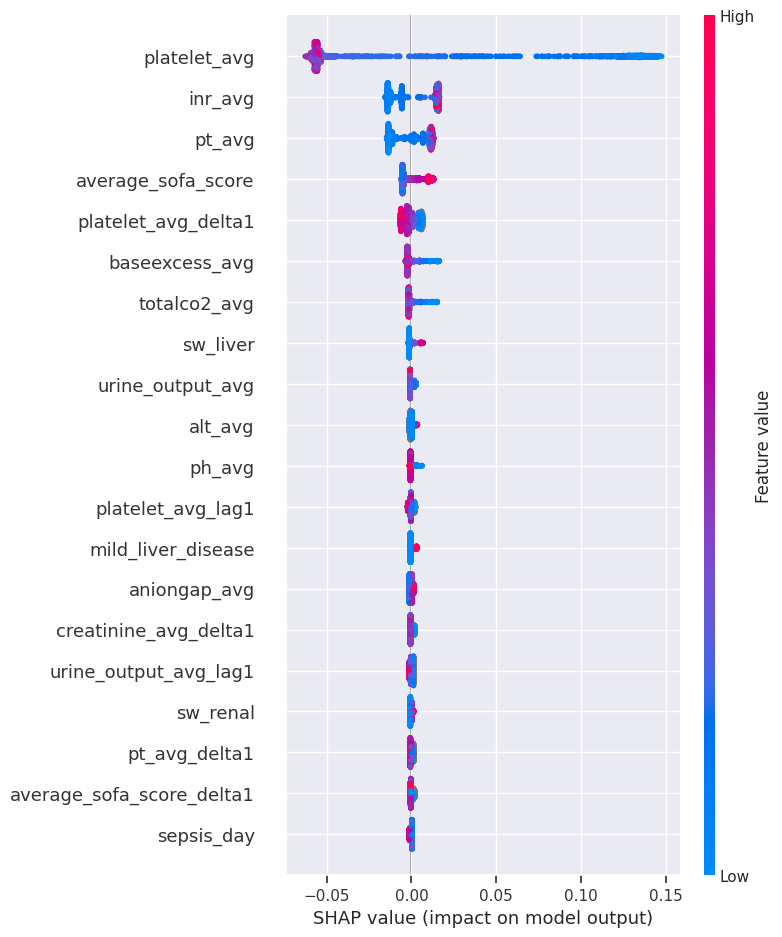

In [ ]:
for c in cat_cols:
    test_df.loc[:, c] = test_df[c].astype(str).fillna("NA")
    test_df.loc[:, c]   = test_df[c].astype(str).fillna("NA")
    test_df.loc[:, c]  = test_df[c].astype(str).fillna("NA")

explainer = shap.TreeExplainer(model)
sample = test_df.sample(2000, random_state=42)
shap_values = explainer.shap_values(sample[feature_cols])

shap.summary_plot(shap_values, sample[feature_cols])

This SHAP summary plot identifies the features most influential in predicting next-day SIC. platelet_avg, inr_avg, pt_avg, and average_sofa_score contribute the most, with low platelets and high INR or SOFA scores pushing risk upward. Red and blue points show how high and low values affect predictions, and temporal features like platelet_avg_delta1 and creatinine_avg_delta1 also have meaningful impact. Overall, the model relies heavily on coagulation markers, organ dysfunction severity, and recent trends.

### Compact Model (Based on SHAP)

Computing mean absolute SHAP values to identify the top 15 most influential features. Rebuilding CatBoost pools using only these key variables and training a more compact model with tuned parameters.


In [ ]:
shap_imp = np.abs(shap_values).mean(axis=0)
top15 = pd.Series(shap_imp, index=feature_cols).sort_values(ascending=False).head(15).index.tolist()

train_pool_c = Pool(train_df[top15], y_train)
val_pool_c   = Pool(val_df[top15], y_val)
test_pool_c  = Pool(test_df[top15], y_test)

compact = CatBoostClassifier(
    loss_function="Logloss",
    scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum(),
    eval_metric="AUC",
    iterations=1000,
    learning_rate=0.04,
    depth=6,
    random_seed=42,
    verbose=200
)

compact.fit(train_pool_c, eval_set=val_pool_c, use_best_model=True)
pred_comp = compact.predict_proba(test_pool_c)[:,1]

print("Compact AUROC:", roc_auc_score(y_test, pred_comp))

0:	test: 0.9091512	best: 0.9091512 (0)	total: 11.2ms	remaining: 11.2s
200:	test: 0.9409153	best: 0.9410698 (155)	total: 1.95s	remaining: 7.76s
400:	test: 0.9398819	best: 0.9410698 (155)	total: 3.97s	remaining: 5.93s
600:	test: 0.9382656	best: 0.9410698 (155)	total: 6.03s	remaining: 4s
800:	test: 0.9359378	best: 0.9410698 (155)	total: 7.97s	remaining: 1.98s
999:	test: 0.9344912	best: 0.9410698 (155)	total: 9.81s	remaining: 0us

bestTest = 0.9410698493
bestIteration = 155

Shrink model to first 156 iterations.
Compact AUROC: 0.9440319070555818


Generating test set probability predictions from the compact model and computing AUROC, AUPRC, and the Brier score.

In [ ]:
pred_test = compact.predict_proba(test_pool)[:,1]

auroc = roc_auc_score(y_test, pred_test)
auprc = average_precision_score(y_test, pred_test)
brier = brier_score_loss(y_test, pred_test)

print("AUROC:", auroc)
print("AUPRC:", auprc)
print("Brier:", brier)

AUROC: 0.9440319070555818
AUPRC: 0.3561119796712303
Brier: 0.09800040646540266


Determining the optimal classification threshold for the compact model using Youden’s J statistic, then producing binary predictions.

In [ ]:
fpr, tpr, thr = roc_curve(y_test, pred_test)
J = tpr - fpr
best_thr = thr[np.argmax(J)]

bin_pred = (pred_test >= best_thr).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, bin_pred).ravel()

print("Sensitivity:", tp/(tp+fn))
print("Specificity:", tn/(tn+fp))
print("PPV:", tp/(tp+fp))
print("NPV:", tn/(tn+fn))

Sensitivity: 0.9544715447154472
Specificity: 0.8135149292823468
PPV: 0.14154810706534846
NPV: 0.9982002828127009


Calculating all key classification metrics for the compact model using the confusion matrix values.


In [ ]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)  # PPV
recall = tp / (tp + fn)     # Sensitivity
f1 = 2 * (precision * recall) / (precision + recall)
specificity = tn / (tn + fp)
npv = tn / (tn + fn)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Specificity:", specificity)
print("NPV:", npv)

Accuracy: 0.8179142349657448
Precision: 0.14154810706534846
Recall: 0.9544715447154472
F1 Score: 0.24653506929861405
Specificity: 0.8135149292823468
NPV: 0.9982002828127009


In [ ]:
importances = model.get_feature_importance(train_pool)

fi = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False)

# Fairness Analysis for SIC

In [ ]:
!pip install fairlearn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Extracting the true labels and test features, then generating predicted probabilities from the trained model. Converting those probabilities into binary predictions using a fixed threshold of 0.5.


In [ ]:
y_true = test_df["sic_next_day"]
X_test = test_df[feature_cols]

y_pred_proba = model.predict_proba(X_test)[:,1]
y_pred = (y_pred_proba > 0.5).astype(int)

## Fairness Analysis - Gender

Filtering to rows with valid gender labels and using them as the sensitive attribute. Computing accuracy, sensitivity, and precision separately for each gender group with MetricFrame.

In [ ]:
valid_mask = test_df['gender'].isin(['M', 'F'])
protected = test_df.loc[valid_mask, 'gender']

metrics = {
    "accuracy": accuracy_score,
    "sensitivity (recall)": recall_score,
    "precision": precision_score
}

mf = MetricFrame(
    metrics=metrics,
    y_true=y_true[valid_mask],
    y_pred=y_pred[valid_mask],
    sensitive_features=protected
)

print("=== Fairness Analysis by Group ===")
print(mf.by_group)

print("\n=== Difference Between Groups ===")
print(mf.difference())

=== Fairness Analysis by Group ===
        accuracy  sensitivity (recall)  precision
gender                                           
F       0.781718              0.905512   0.115869
M       0.752988              0.930556   0.105946

=== Difference Between Groups ===
accuracy                0.028730
sensitivity (recall)    0.025044
precision               0.009923
dtype: float64


Calculating additional fairness metrics such as selection rate, true positive rate, and false positive rate for each gender group using MetricFrame.

In [ ]:
extra_metrics = MetricFrame(
    metrics={
        "selection_rate": selection_rate,
        "TPR (sensitivity)": true_positive_rate,
        "FPR": false_positive_rate,
    },
    y_true=y_true[valid_mask],
    y_pred=y_pred[valid_mask],
    sensitive_features=protected
)

print("=== Statistical Parity / Equalized Odds ===")
print(extra_metrics.by_group)

print("\n=== Group Differences ===")
print(extra_metrics.difference())

=== Statistical Parity / Equalized Odds ===
        selection_rate  TPR (sensitivity)       FPR
gender                                             
F             0.243558           0.905512  0.222264
M             0.273861           0.930556  0.252727

=== Group Differences ===
selection_rate       0.030303
TPR (sensitivity)    0.025044
FPR                  0.030462
dtype: float64


Creating a bar chart of the per-group fairness metrics to visualize how model performance differs between gender groups. This makes disparities easier to spot and interpret.

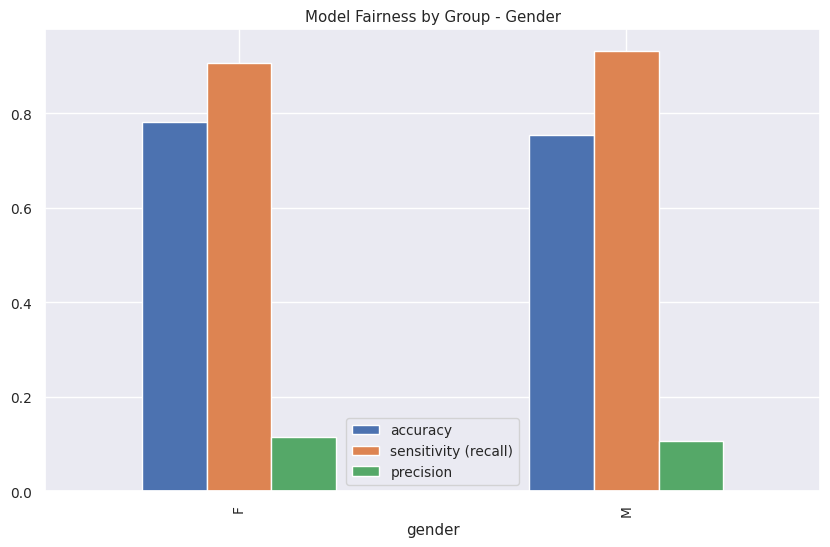

In [ ]:
mf.by_group.plot(kind="bar", figsize=(10,6))
plt.title("Model Fairness by Group - Gender")
plt.show()

This bar chart compares model performance between female and male patients. Accuracy and precision are nearly identical, while sensitivity is slightly higher for males. Overall, the model shows no major performance differences by gender, suggesting good fairness.

## Fairness Analysis - Race

Grouping the raw race categories into broader, cleaner buckets by applying a custom function.

In [ ]:
def collapse_race(value):
    value = str(value).upper()
    if "WHITE" in value:
        return "WHITE"
    if "BLACK" in value:
        return "BLACK"
    if "ASIAN" in value:
        return "ASIAN"
    if "HISPANIC" in value or "LATINO" in value:
        return "HISPANIC"
    if value in ["UNKNOWN", "OTHER", "PATIENT DECLINED TO ANSWER"]:
        return "UNKNOWN"
    return "OTHER"
fairness_race_df=test_df.copy()
fairness_race_df["race_grouped"] = fairness_race_df["race"].apply(collapse_race)

Filtering to valid race entries and using the grouped race labels as the sensitive attribute.

In [ ]:
valid_mask = fairness_race_df['race'].notna() & (fairness_race_df['race'] != 'nan')
protected = fairness_race_df.loc[valid_mask, 'race_grouped']

metrics = {
    "accuracy": accuracy_score,
    "sensitivity (recall)": recall_score,
    "precision": precision_score
}

mf = MetricFrame(
    metrics=metrics,
    y_true=y_true[valid_mask],
    y_pred=y_pred[valid_mask],
    sensitive_features=protected
)

print("=== Fairness Analysis by Group ===")
print(mf.by_group)

print("\n=== Difference Between Groups ===")
print(mf.difference())

=== Fairness Analysis by Group ===
              accuracy  sensitivity (recall)  precision
race_grouped                                           
ASIAN         0.648973              1.000000   0.088889
BLACK         0.774547              0.851852   0.090020
HISPANIC      0.806849              1.000000   0.150602
OTHER         0.785455              0.900000   0.134328
UNKNOWN       0.787600              0.872549   0.115885
WHITE         0.759378              0.933842   0.109782

=== Difference Between Groups ===
accuracy                0.157877
sensitivity (recall)    0.148148
precision               0.061714
dtype: float64


Evaluating fairness metrics across grouped race categories by computing selection rate, true positive rate, and false positive rate for each group.


In [ ]:
extra_metrics = MetricFrame(
    metrics={
        "selection_rate": selection_rate,
        "TPR (sensitivity)": true_positive_rate,
        "FPR": false_positive_rate,
    },
    y_true=y_true[valid_mask],
    y_pred=y_pred[valid_mask],
    sensitive_features=protected
)

print("=== Statistical Parity / Equalized Odds ===")
print(extra_metrics.by_group)

print("\n=== Group Differences ===")
print(extra_metrics.difference())

=== Statistical Parity / Equalized Odds ===
              selection_rate  TPR (sensitivity)       FPR
race_grouped                                             
ASIAN               0.385274           1.000000  0.363475
BLACK               0.243565           0.851852  0.227495
HISPANIC            0.227397           1.000000  0.200000
OTHER               0.243636           0.900000  0.218868
UNKNOWN             0.235727           0.872549  0.215146
WHITE               0.267954           0.933842  0.246296

=== Group Differences ===
selection_rate       0.157877
TPR (sensitivity)    0.148148
FPR                  0.163475
dtype: float64


Plotting the fairness metrics by race group in a bar chart to visualize performance differences across racial categories.

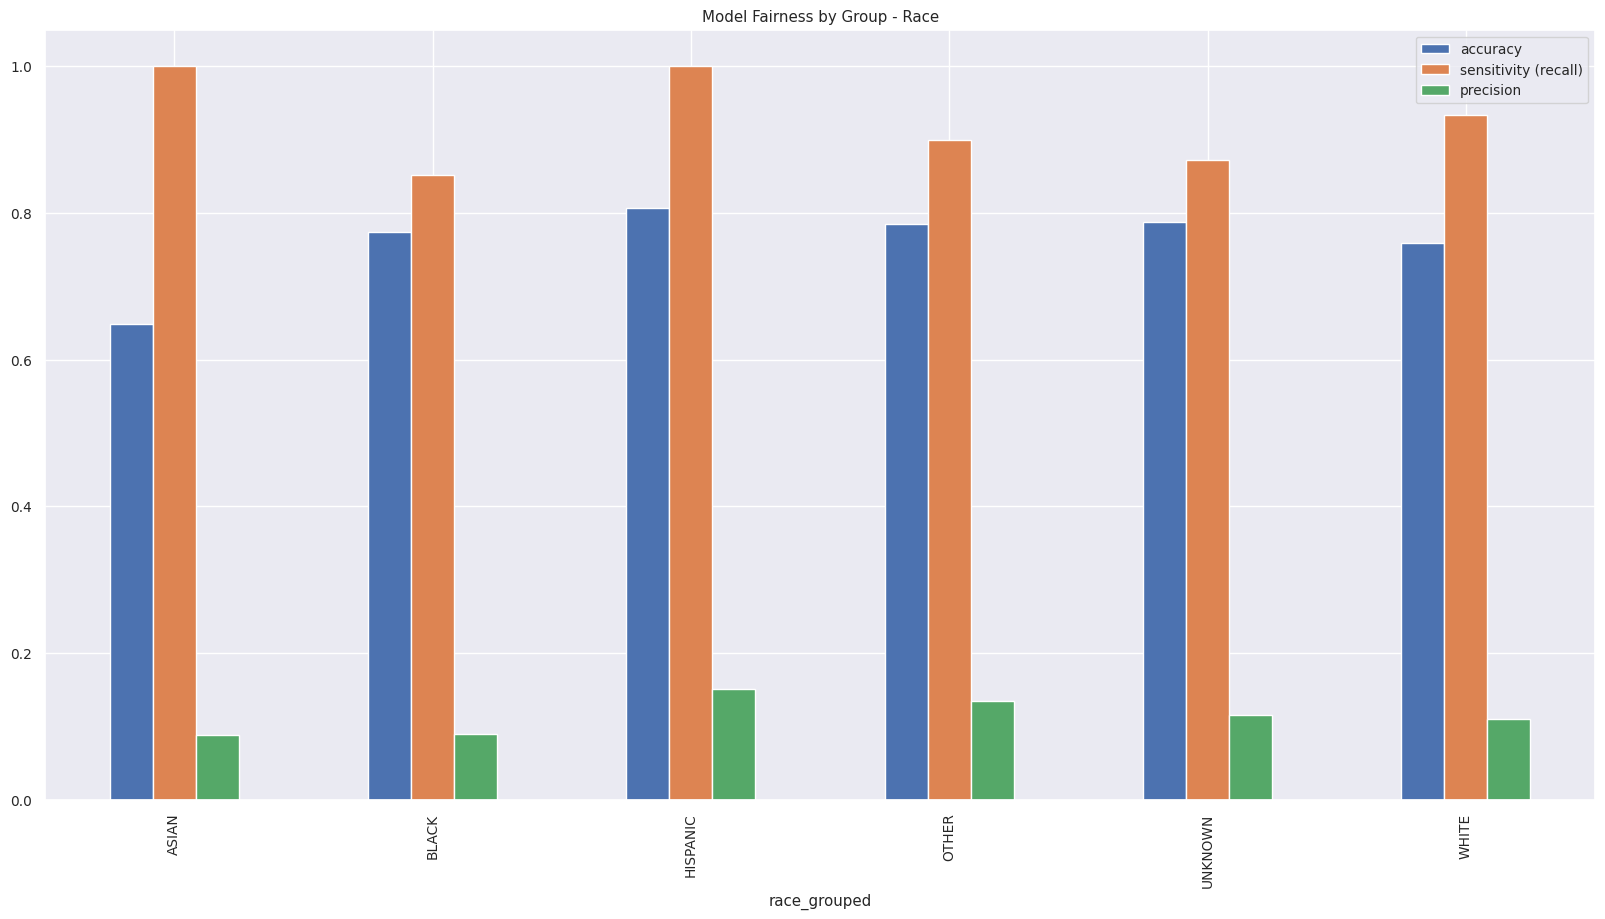

In [ ]:
mf.by_group.plot(kind="bar", figsize=(20,10))
plt.title("Model Fairness by Group - Race")
plt.show()

This bar chart compares model performance across racial groups. Accuracy differs slightly, with Asian patients lowest and Hispanic patients highest, while sensitivity is strong across all groups and peaks for Asian and Hispanic patients. Precision remains relatively consistent. Overall, performance is broadly similar, with only modest differences worth monitoring for fairness.

Summing SIC-next-day cases within each race group, giving a quick look at how often the outcome occurs across the grouped racial categories.

In [ ]:
fairness_race_df.groupby('race_grouped')['sic_next_day'].sum()

race_grouped
ASIAN        20
BLACK        54
HISPANIC     25
OTHER        21
UNKNOWN     102
WHITE       393
Name: sic_next_day, dtype: int64

# **Disseminated Intravascular Coagulopathy (DIC)**

# EDA for DIC

In [ ]:
client = bigquery.Client()
table_id = "mlinhealthcaregroup4.temp.rework_final_table_with_jaam_dic_labels_with_filter"

df = client.list_rows(table_id).to_dataframe()
df.head()

subject_id   stay_id  chart_date suspected_infection_time infection_date  \
0    12106780  37081503  2110-02-04      2110-02-03 17:04:00     2110-02-03   
1    13763968  31613027  2110-02-04      2110-02-04 18:54:00     2110-02-04   
2    13263248  39247539  2110-03-04      2110-02-27 14:02:00     2110-02-27   
3    10404551  33490013  2110-04-06      2110-03-31 22:47:00     2110-03-31   
4    10404551  33490013  2110-04-05      2110-03-31 22:47:00     2110-03-31   

   sepsis_day  max_heart_rate  min_mbp  max_resp_rate  min_spo2  \
0           1            96.0     59.0           23.0      93.0   
1           0            96.0     61.0           31.0      91.0   
2           5            89.0     55.0           33.0      96.0   
3           6            92.0     67.0           28.0      91.0   
4           5           104.0     60.0           27.0      90.0   

  max_temperature  mean_heart_rate   mean_mbp  mean_resp_rate   mean_fio2  \
0    36.720000000        80.263158  73.578947       17.050000  100.000000   
1    37.560000000        93.615385  68.384615       25.928571  100.000000   
2    37.000000000        80.423077  67.538462       23.703704   40.000000   
3    37.440000000        80.583333  84.166667       25.500000   68.888889   
4    37.390000000        77.804878  76.048780       22.162500   64.000000   

   max_fio2  min_fio2  mean_peep  max_peep  min_peep  mean_tidal_volume  \
0     100.0     100.0   5.600000       5.6       5.6              500.0   
1     100.0     100.0  11.000000      13.0      10.0              500.0   
2      40.0      40.0   7.250000       8.0       5.0                NaN   
3      80.0      60.0  10.233333      10.7      10.0              300.0   
4     100.0      50.0  11.590000      15.0      10.0              342.5   

   max_tidal_volume  min_tidal_volume  mean_minute_volume  max_minute_volume  \
0             500.0             500.0            6.490000               6.49   
1             500.0             500.0           17.300000              17.50   
2               NaN               NaN           12.871429              14.60   
3             300.0             300.0            7.783333               7.80   
4             350.0             320.0            8.314286               8.50   

   min_minute_volume  aado2_avg  globulin  total_protein  vasopressor_use  \
0               6.49        NaN       NaN            NaN                0   
1              17.10     506.75       1.8          4.925                1   
2              12.00        NaN       NaN          6.500                1   
3               7.70     447.00       NaN            NaN                1   
4               7.70     447.00       NaN            NaN                1   

    rrt  avg_sofa_score_daily  so2_avg     po2_avg   pco2_avg    fio2_avg  \
0  <NA>              6.583333     97.5  281.000000  36.666667         NaN   
1     1             10.333333      NaN   89.000000  33.000000  100.000000   
2     1             10.920000      NaN  111.000000  39.250000   40.000000   
3  <NA>             13.440000      NaN   89.666667  60.500000   66.666667   
4  <NA>             14.320000      NaN   85.000000  57.000000         NaN   

   bg_aado2_avg  pao2fio2ratio_avg    ph_avg  baseexcess_avg  bicarbonate_avg  \
0           NaN         242.000000  7.420000       -0.333333              NaN   
1         591.0          89.000000  7.320000       -8.000000              NaN   
2           NaN         277.500000  7.430000        1.500000              NaN   
3         431.0         134.236111  7.351667        6.500000              NaN   
4           NaN         115.333333  7.400000        9.000000              NaN   

   totalco2_avg  bg_hematocrit_avg  bg_hemoglobin_avg  bg_chloride_avg  \
0     24.000000               38.0               12.7            103.0   
1     18.000000                NaN                NaN              NaN   
2     26.750000                NaN                NaN              NaN   
3     32.666667      

In [ ]:
print("Shape:", df.shape)

print("\nFirst 5 rows:")
display(df.head())

print("\nColumns:")
print(list(df.columns))

target_col = "jaam_dic_tomorrow"

print(f"\nValue counts for {target_col} (including NaNs):")
print(df[target_col].value_counts(dropna=False))

Shape: (14004, 123)

First 5 rows:


subject_id   stay_id  chart_date suspected_infection_time infection_date  \
0    12106780  37081503  2110-02-04      2110-02-03 17:04:00     2110-02-03   
1    13763968  31613027  2110-02-04      2110-02-04 18:54:00     2110-02-04   
2    13263248  39247539  2110-03-04      2110-02-27 14:02:00     2110-02-27   
3    10404551  33490013  2110-04-06      2110-03-31 22:47:00     2110-03-31   
4    10404551  33490013  2110-04-05      2110-03-31 22:47:00     2110-03-31   

   sepsis_day  max_heart_rate  min_mbp  max_resp_rate  min_spo2  \
0           1            96.0     59.0           23.0      93.0   
1           0            96.0     61.0           31.0      91.0   
2           5            89.0     55.0           33.0      96.0   
3           6            92.0     67.0           28.0      91.0   
4           5           104.0     60.0           27.0      90.0   

  max_temperature  mean_heart_rate   mean_mbp  mean_resp_rate   mean_fio2  \
0    36.720000000        80.263158  73.578947       17.050000  100.000000   
1    37.560000000        93.615385  68.384615       25.928571  100.000000   
2    37.000000000        80.423077  67.538462       23.703704   40.000000   
3    37.440000000        80.583333  84.166667       25.500000   68.888889   
4    37.390000000        77.804878  76.048780       22.162500   64.000000   

   max_fio2  min_fio2  mean_peep  max_peep  min_peep  mean_tidal_volume  \
0     100.0     100.0   5.600000       5.6       5.6              500.0   
1     100.0     100.0  11.000000      13.0      10.0              500.0   
2      40.0      40.0   7.250000       8.0       5.0                NaN   
3      80.0      60.0  10.233333      10.7      10.0              300.0   
4     100.0      50.0  11.590000      15.0      10.0              342.5   

   max_tidal_volume  min_tidal_volume  mean_minute_volume  max_minute_volume  \
0             500.0             500.0            6.490000               6.49   
1             500.0             500.0           17.300000              17.50   
2               NaN               NaN           12.871429              14.60   
3             300.0             300.0            7.783333               7.80   
4             350.0             320.0            8.314286               8.50   

   min_minute_volume  aado2_avg  globulin  total_protein  vasopressor_use  \
0               6.49        NaN       NaN            NaN                0   
1              17.10     506.75       1.8          4.925                1   
2              12.00        NaN       NaN          6.500                1   
3               7.70     447.00       NaN            NaN                1   
4               7.70     447.00       NaN            NaN                1   

    rrt  avg_sofa_score_daily  so2_avg     po2_avg   pco2_avg    fio2_avg  \
0  <NA>              6.583333     97.5  281.000000  36.666667         NaN   
1     1             10.333333      NaN   89.000000  33.000000  100.000000   
2     1             10.920000      NaN  111.000000  39.250000   40.000000   
3  <NA>             13.440000      NaN   89.666667  60.500000   66.666667   
4  <NA>             14.320000      NaN   85.000000  57.000000         NaN   

   bg_aado2_avg  pao2fio2ratio_avg    ph_avg  baseexcess_avg  bicarbonate_avg  \
0           NaN         242.000000  7.420000       -0.333333              NaN   
1         591.0          89.000000  7.320000       -8.000000              NaN   
2           NaN         277.500000  7.430000        1.500000              NaN   
3         431.0         134.236111  7.351667        6.500000              NaN   
4           NaN         115.333333  7.400000        9.000000              NaN   

   totalco2_avg  bg_hematocrit_avg  bg_hemoglobin_avg  bg_chloride_avg  \
0     24.000000               38.0               12.7            103.0   
1     18.000000                NaN                NaN              NaN   
2     26.750000                NaN                NaN              NaN   
3     32.666667      


Columns:
['subject_id', 'stay_id', 'chart_date', 'suspected_infection_time', 'infection_date', 'sepsis_day', 'max_heart_rate', 'min_mbp', 'max_resp_rate', 'min_spo2', 'max_temperature', 'mean_heart_rate', 'mean_mbp', 'mean_resp_rate', 'mean_fio2', 'max_fio2', 'min_fio2', 'mean_peep', 'max_peep', 'min_peep', 'mean_tidal_volume', 'max_tidal_volume', 'min_tidal_volume', 'mean_minute_volume', 'max_minute_volume', 'min_minute_volume', 'aado2_avg', 'globulin', 'total_protein', 'vasopressor_use', 'rrt', 'avg_sofa_score_daily', 'so2_avg', 'po2_avg', 'pco2_avg', 'fio2_avg', 'bg_aado2_avg', 'pao2fio2ratio_avg', 'ph_avg', 'baseexcess_avg', 'bicarbonate_avg', 'totalco2_avg', 'bg_hematocrit_avg', 'bg_hemoglobin_avg', 'bg_chloride_avg', 'bg_calcium_avg', 'bg_temperature_avg', 'bg_potassium_avg', 'bg_sodium_avg', 'bg_lactate_avg', 'bg_glucose_avg', 'mch_avg', 'mchc_avg', 'mcv_avg', 'platelet_avg', 'rbc_avg', 'rdw_avg', 'rdwsd_avg', 'wbc_avg', 'albumin_avg', 'globulin_avg', 'total_protein_avg', 'anio

In [ ]:
missing_pct = df.isna().mean().sort_values(ascending=False)

print("\nTop 50 columns by missingness (%):")
print((missing_pct.head(50) * 100).round(1))


Top 50 columns by missingness (%):
rdwsd_avg               100.0
thrombin_avg             99.6
globulin_avg             99.3
d_dimer_avg              98.6
total_protein_avg        98.6
bicarbonate_avg          98.4
bg_aado2_avg             96.7
bg_chloride_avg          90.4
globulin                 88.6
bg_hematocrit_avg        88.3
bg_hemoglobin_avg        88.3
bg_sodium_avg            87.2
vasopressin_use          80.2
rrt                      77.7
total_protein            77.6
fio2_avg                 76.7
so2_avg                  71.9
aado2_avg                70.1
bg_temperature_avg       68.7
bg_potassium_avg         67.7
bg_glucose_avg           66.5
plateau_pressure_avg     60.8
albumin_avg              53.6
fibrinogen_avg           53.5
mean_tidal_volume        50.9
min_tidal_volume         50.9
max_tidal_volume         50.9
bg_calcium_avg           41.8
weight_daily             39.2
sw_weight                39.2
urine_output_avg         35.4
pao2fio2ratio_avg        35.2
bg_l

In [ ]:
n_total = len(df)
n_missing_target = df[target_col].isna().sum()

print(f"\nTotal rows: {n_total}")
print(f"Rows with missing {target_col}: {n_missing_target}")
print(f"Usable rows (non-missing {target_col}): {n_total - n_missing_target}")


Total rows: 14004
Rows with missing jaam_dic_tomorrow: 0
Usable rows (non-missing jaam_dic_tomorrow): 14004


Removing ID, time, future-label, and fully missing columns to prevent leakage, converting a few variables to float, and creating clean feature (X) and target (y) datasets for modeling.

In [ ]:
data = df.copy()

target_col = "jaam_dic_tomorrow"

id_cols = ["subject_id", "stay_id"]
time_cols = ["chart_date", "suspected_infection_time", "infection_date"]
future_label_cols = [
    "jaam_dic_tomorrow",
    "jaam_dic_progression",
    "sic_tomorrow",
    "sic_next_day",
]

cols_to_drop = id_cols + time_cols + future_label_cols

missing_pct = df.isna().mean()
always_missing_cols = missing_pct[missing_pct == 1.0].index.tolist()

print("Columns with 100% missing:", always_missing_cols)

cols_to_drop += always_missing_cols

cols_to_drop = [c for c in cols_to_drop if c in df.columns]

print("\nDropping these columns from features:")
print(cols_to_drop)
df['max_temperature']=df['max_temperature'].astype(float)
df['height']=df['height'].astype(float)
df['height_final']=df['height_final'].astype(float)

X = df.drop(columns=cols_to_drop)
y = df[target_col]

print("\nX shape after dropping leakage/ID/time columns:", X.shape)
print("y shape:", y.shape)

print("\nCheck that target is not in X:", "jaam_dic_tomorrow" in X.columns)

Columns with 100% missing: ['rdwsd_avg']

Dropping these columns from features:
['subject_id', 'stay_id', 'chart_date', 'suspected_infection_time', 'infection_date', 'jaam_dic_tomorrow', 'jaam_dic_progression', 'sic_tomorrow', 'sic_next_day', 'rdwsd_avg']

X shape after dropping leakage/ID/time columns: (14004, 113)
y shape: (14004,)

Check that target is not in X: False


In [ ]:
key_features = [
    "platelet_avg", "inr_avg", "pt_avg", "ptt_avg",
    "d_dimer_avg", "fibrinogen_avg",
    "creatinine_avg", "bun_avg",
    "bilirubin_total_avg", "albumin_avg",
    "wbc_avg", "rdw_avg",
    "avg_sofa_score_daily", "sw_sofa", "sofa_indicator",
    "urine_output_avg", "age"
]

available_features = [f for f in key_features if f in X.columns]

print("Key features found in dataset:")
print(available_features)

print("\nMissingness:")
print(X[available_features].isna().mean().sort_values(ascending=False))

print("\nSummary stats:")
display(X[available_features].describe())

Key features found in dataset:
['platelet_avg', 'inr_avg', 'pt_avg', 'ptt_avg', 'd_dimer_avg', 'fibrinogen_avg', 'creatinine_avg', 'bun_avg', 'bilirubin_total_avg', 'albumin_avg', 'wbc_avg', 'rdw_avg', 'avg_sofa_score_daily', 'sw_sofa', 'sofa_indicator', 'urine_output_avg', 'age']

Missingness:
d_dimer_avg             0.986361
albumin_avg             0.535633
fibrinogen_avg          0.535347
urine_output_avg        0.353542
bilirubin_total_avg     0.147672
ptt_avg                 0.018495
rdw_avg                 0.003999
wbc_avg                 0.002499
bun_avg                 0.002356
creatinine_avg          0.002285
age                     0.000143
inr_avg                 0.000000
avg_sofa_score_daily    0.000000
sw_sofa                 0.000000
sofa_indicator          0.000000
pt_avg                  0.000000
platelet_avg            0.000000
dtype: float64

Summary stats:


platelet_avg       inr_avg        pt_avg       ptt_avg   d_dimer_avg  \
count  14004.000000  14004.000000  14004.000000  13745.000000    191.000000   
mean      56.463724      2.096799     22.624916     48.209424   6561.013962   
std       23.461351      0.841585      8.723722     20.691501   5210.076094   
min        5.000000      1.200000     12.500000     19.200000    417.000000   
25%       38.000000      1.550000     16.900000     34.000000   2467.500000   
50%       55.333333      1.850000     20.150000     42.300000   4952.000000   
75%       76.000000      2.400000     25.700000     56.500000   8274.750000   
max       99.900000     16.500000    143.483333    150.000000  21328.000000   

       fibrinogen_avg  creatinine_avg       bun_avg  bilirubin_total_avg  \
count     6507.000000    13972.000000  13971.000000         11936.000000   
mean       245.052841        1.901311     41.410118             9.547061   
std        172.255315        1.444509     29.387992            10.705033   
min         26.000000        0.100000      1.000000             0.100000   
25%        135.000000        0.925000     20.000000             1.850000   
50%        178.000000        1.475000     33.500000             5.250000   
75%        295.000000        2.400000     55.000000            13.200000   
max       1216.000000       14.720000    249.500000            78.300000   

       albumin_avg       wbc_avg       rdw_avg  avg_sofa_score_daily  \
count  6503.000000  13969.000000  13948.000000          14004.000000   
mean      2.905730     12.871608     18.609702             10.084274   
std       0.695214     11.474888      3.350508              3.541750   
min       0.500000      0.100000     11.433333              0.428571   
25%       2.400000      6.466667     16.100000              7.480000   
50%       2.850000     10.500000     17.966667              9.960000   
75%       3.350000     16.100000     20.550000             12.527090   
max       5.900000    296.150000     36.050000             21.920000   

         sw_sofa  sofa_indicator  urine_output_avg        age  
count    14004.0         14004.0       9053.000000    14002.0  
mean   11.229791        0.999857        101.195159   59.15005  
std     3.730423         0.01195        109.657326  14.592221  
min          2.0             0.0      -1166.250000       19.0  
25%          8.0             1.0         25.000000       50.0  
50%         11.0             1.0         67.523810       60.0  
75%         14.0             1.0        142.777778       69.0  
max         23.0             1.0       1116.666667       97.0

Visualizing the correlations using a heatmap for key features.

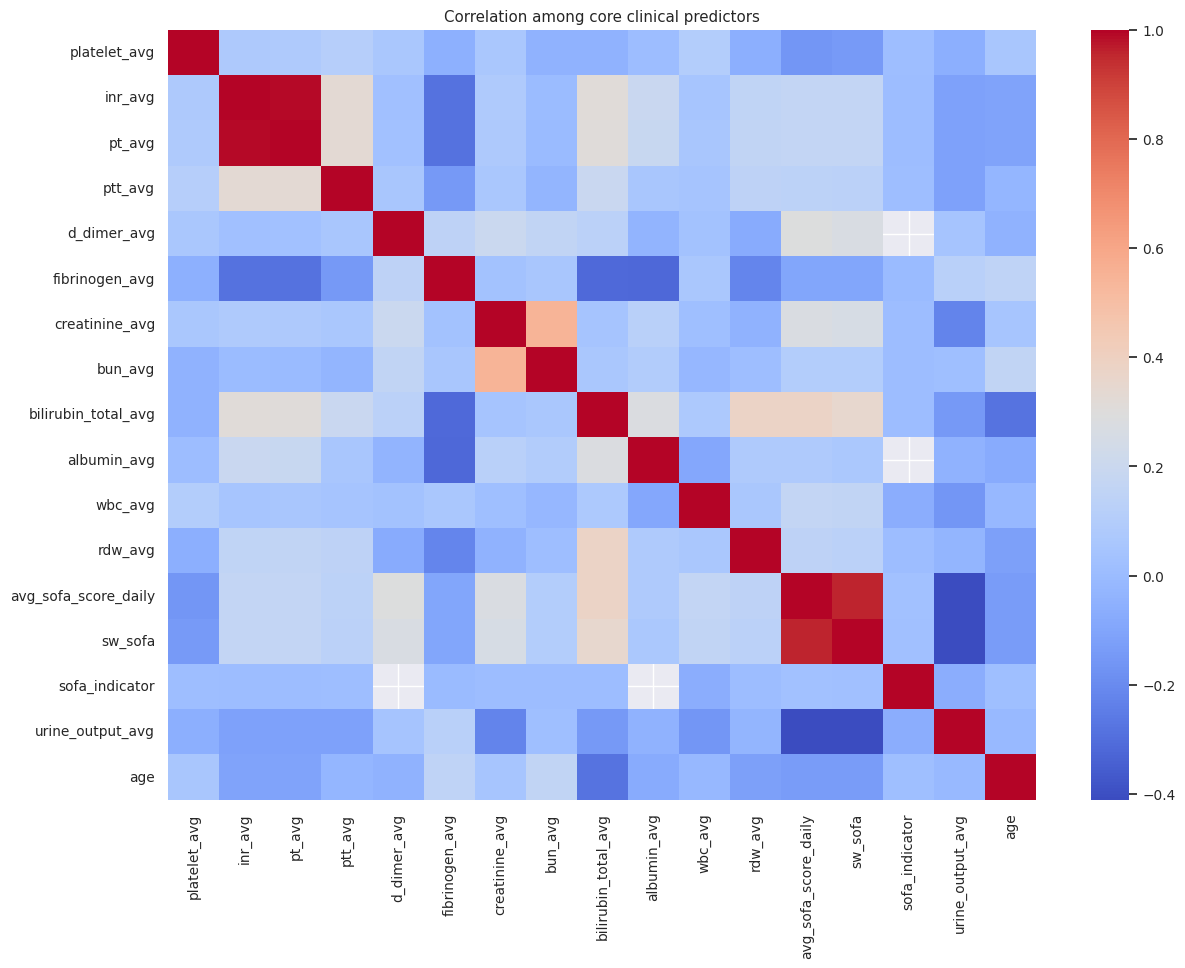

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    X[available_features].corr(numeric_only=True),
    cmap="coolwarm",
    annot=False
)
plt.title("Correlation among core clinical predictors")
plt.show()

The heatmap shows only a few strong correlation clusters, most notably among coagulation markers (INR, PT, PTT) and SOFA-related severity scores, while most other predictors are only weakly related, suggesting they capture distinct physiological information.

In [ ]:
client = bigquery.Client()
table_id = "mlinhealthcaregroup4.temp.rework_final_table_with_jaam_dic_labels_with_filter"
df = client.list_rows(table_id).to_dataframe()
df.head()
print("DIC progression value counts:")
print(df['jaam_dic_progression'].value_counts())
print("\nProgression rate (%):")
print(df['jaam_dic_progression'].mean() * 100)

DIC progression value counts:
jaam_dic_progression
0    13545
1      459
Name: count, dtype: Int64

Progression rate (%):
3.2776349614395883


Filtering the dataset to patients without DIC today and creating a binary label indicating whether they progress to DIC tomorrow.

In [ ]:
df_model = df.copy()

df_model = df_model[df_model["jaam_dic_today"] == 0].copy()

df_model["dic_progression"] = (
    (df_model["jaam_dic_today"] == 0) &
    (df_model["jaam_dic_tomorrow"] == 1)
).astype(int)

print(df_model.shape)
print(df_model["dic_progression"].value_counts())

(813, 124)
dic_progression
1    459
0    354
Name: count, dtype: int64


Removing ID columns, time columns, and any variables that would leak future information into the model.

In [ ]:
df_model_clean = df_model.copy()

cols_to_drop = [
    "subject_id", "stay_id",
    "chart_date", "suspected_infection_time", "infection_date",
    "jaam_dic_tomorrow", "jaam_dic_progression",
    "sic_tomorrow", "sic_next_day",
    "jaam_score", "jaam_platelet_score", "jaam_inr_score",
    "jaam_dic_today",
    "sw_sofa", "average_sofa_score", "sofa_indicator"
]

cols_to_drop = [c for c in cols_to_drop if c in df_model_clean.columns]

print("Dropping columns:", cols_to_drop)

df_model_clean = df_model_clean.drop(columns=cols_to_drop)

print("Final dataset shape after removing leakage & IDs:", df_model_clean.shape)

Dropping columns: ['subject_id', 'stay_id', 'chart_date', 'suspected_infection_time', 'infection_date', 'jaam_dic_tomorrow', 'jaam_dic_progression', 'sic_tomorrow', 'sic_next_day', 'jaam_score', 'jaam_platelet_score', 'jaam_inr_score', 'jaam_dic_today', 'sw_sofa', 'average_sofa_score', 'sofa_indicator']
Final dataset shape after removing leakage & IDs: (813, 108)


Separating the cleaned dataset into features (X) and target (y) for modeling and printing their shapes along with the target distribution.

In [ ]:
print("Current df_model_clean shape:", df_model_clean.shape)

target_col = "dic_progression"

X = df_model_clean.drop(columns=[target_col])
y = df_model_clean[target_col]

print("X shape:", X.shape)
print("y shape:", y.shape)

print("\nTarget value counts:")
print(y.value_counts())

Current df_model_clean shape: (813, 108)
X shape: (813, 107)
y shape: (813,)

Target value counts:
dic_progression
1    459
0    354
Name: count, dtype: int64


Spliting the data into training and testing sets with class stratification.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("\nTrain class proportions:")
print(y_train.value_counts(normalize=True))

print("\nTest class proportions:")
print(y_test.value_counts(normalize=True))

Train shape: (650, 107)
Test shape: (163, 107)

Train class proportions:
dic_progression
1    0.564615
0    0.435385
Name: proportion, dtype: float64

Test class proportions:
dic_progression
1    0.564417
0    0.435583
Name: proportion, dtype: float64


# Statistical Analysis for DIC

In [ ]:
from google.cloud import bigquery
import pandas as pd

client = bigquery.Client()
table_id = "mlinhealthcaregroup4.temp.rework_final_table_with_jaam_dic_labels_with_filter"

df = client.list_rows(table_id).to_dataframe()

Filtering the dataset to patients without DIC today and creating a binary variable indicating whether they develop DIC the next day.

In [ ]:
df_model = df.copy()

df_model = df_model[df_model['jaam_dic_today'] == 0].copy()

df_model['dic_progression'] = ((df_model['jaam_dic_today'] == 0)
                               & (df_model['jaam_dic_tomorrow'] == 1)).astype(int)

print(df_model.shape)
print(df_model['dic_progression'].value_counts())

(813, 124)
dic_progression
1    459
0    354
Name: count, dtype: int64


Removing ID columns and all variables that leak future or derived information.

In [ ]:
df_model_clean = df_model.copy()

cols_to_drop = [
    'subject_id', 'stay_id',
    'chart_date', 'suspected_infection_time', 'infection_date',
    'jaam_dic_tomorrow', 'jaam_dic_progression',
    'sic_tomorrow', 'sic_next_day',
    'jaam_score', 'jaam_platelet_score', 'jaam_inr_score',
    'jaam_dic_today',
    'sw_sofa', 'average_sofa_score', 'sofa_indicator'
]

cols_to_drop = [c for c in cols_to_drop if c in df_model_clean.columns]

print("Dropping columns:", cols_to_drop)

df_model_clean = df_model_clean.drop(columns=cols_to_drop)

print("Final dataset shape after removing leakage & IDs:", df_model_clean.shape)

Dropping columns: ['subject_id', 'stay_id', 'chart_date', 'suspected_infection_time', 'infection_date', 'jaam_dic_tomorrow', 'jaam_dic_progression', 'sic_tomorrow', 'sic_next_day', 'jaam_score', 'jaam_platelet_score', 'jaam_inr_score', 'jaam_dic_today', 'sw_sofa', 'average_sofa_score', 'sofa_indicator']
Final dataset shape after removing leakage & IDs: (813, 108)


Defining the outcome variable for analysis and ensuring the outcome column is stored as an integer/binary variable.

In [ ]:
df_or = df_model_clean.copy()

outcome = 'dic_progression'

df_or[outcome] = df_or[outcome].astype(int)

Runing univariate logistic regression for each predictor against the outcome and extracting odds ratios, confidence intervals, and p-values for each variable.

In [ ]:
univariate_results = []

predictor_vars = [col for col in df_or.columns if col != outcome]

for var in predictor_vars:
    try:
        formula = f"{outcome} ~ {var}"
        model = smf.logit(formula=formula, data=df_or).fit(disp=0)

        OR = np.exp(model.params[var])
        CI_lower = np.exp(model.conf_int().loc[var][0])
        CI_upper = np.exp(model.conf_int().loc[var][1])
        p_value = model.pvalues[var]

        univariate_results.append({
            "Variable": var,
            "Odds Ratio": OR,
            "CI Lower": CI_lower,
            "CI Upper": CI_upper,
            "p-value": p_value
        })
    except Exception as e:
        pass

univariate_or_df = pd.DataFrame(univariate_results)
univariate_or_df.sort_values("p-value", inplace=True)
univariate_or_df

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/conda/lib/python3.10/site-packages/statsmodels/dis

Variable  Odds Ratio  CI Lower  CI Upper   p-value
47               platelet_avg    0.946152  0.922893  0.969998  0.000013
50                    wbc_avg    1.041336  1.020235  1.062874  0.000105
24       avg_sofa_score_daily    1.085735  1.039848  1.133648  0.000189
77             sw_respiration    1.183759  1.064073  1.316908  0.001923
54               aniongap_avg    1.055240  1.019777  1.091936  0.002050
72         mild_liver_disease    1.468027  1.110554  1.940565  0.007009
78                   sw_liver    1.130176  1.033578  1.235802  0.007265
35          bg_hematocrit_avg    0.904980  0.838506  0.976723  0.010316
36          bg_hemoglobin_avg    0.743725  0.592678  0.933267  0.010582
70       severe_liver_disease    1.424837  1.074838  1.888805  0.013826
1              max_heart_rate    1.011580  1.002310  1.020935  0.014239
42             bg_lactate_avg    1.172257  1.030976  1.332898  0.015286
88                        bmi    1.025677  1.003338  1.048514  0.024035
7              mean_resp_rate    1.073384  1.008057  1.142945  0.027073
19          min_minute_volume    1.107611  1.011604  1.212731  0.027150
55                    bun_avg    1.005657  1.000581  1.010760  0.028904
87               weight_final    1.007170  1.000635  1.013747  0.031470
17         mean_minute_volume    1.099604  1.008101  1.199412  0.032196
5             mean_heart_rate    1.016289  1.000534  1.032291  0.042667
79          sw_cardiovascular    1.105213  1.003294  1.217486  0.042705
32             baseexcess_avg    0.959949  0.922673  0.998731  0.043092
83                        age    0.990303  0.980973  0.999722  0.043633
34               totalco2_avg    0.964031  0.929865  0.999451  0.046615
82                  sw_weight    1.007631  0.999734  1.015590  0.058254
86               weight_daily    1.007405  0.999472  1.015401  0.067402
73           diabetes_with_cc    0.694776  0.469238  1.028719  0.068977
25                    so2_avg    0.972431  0.943028  1.002750  0.074317
0                  sepsis_day    0.980698  0.959326  1.002547  0.082970
30          pao2fio2ratio_avg    1.001236  0.999823  1.002652  0.086544
81                   sw_renal    1.080562  0.985923  1.184285  0.097556
64                    ast_avg    1.000142  0.999974  1.000311  0.098103
61                    ptt_avg    1.005399  0.998782  1.012059  0.110018
59                    inr_avg    1.157797  0.965178  1.388857  0.114520
85       plateau_pressure_avg    1.043224  0.988984  1.100439  0.120342
23            vasopressor_use    1.253047  0.939328  1.671542  0.124967
43             bg_glucose_avg    1.004301  0.998721  1.009912  0.131074
53          total_protein_avg    2.585125  0.708301  9.435081  0.150478
18          max_minute_volume    1.043239  0.984104  1.105928  0.155094
38             bg_calcium_avg    0.238114  0.031942  1.775051  0.161485
49                    rdw_avg    1.031708  0.987441  1.077960  0.162985
62                    alt_avg    1.000167  0.999929  1.000404  0.169572
60                     pt_avg    1.012132  0.994382  1.030199  0.181589
75              renal_disease    0.828100  0.622534  1.101547  0.195104
31                     ph_avg    0.208270  0.018780  2.309691  0.201232
21                   globulin    0.673397  0.366675  1.236689  0.202315
74        diabetes_without_cc    1.225715  0.894012  1.680488  0.206193
44                    mch_avg    1.033668  0.981753  1.088329  0.207839
71  chronic_pulmonary_disease    1.245535  0.873721  1.775575  0.224851
12                   max_peep    1.030911  0.973448  1.091766  0.298191
16           min_tidal_volume    1.001042  0.999066  1.003022  0.301609
4                    min_spo2    0.986258  0.960349  1.012865  0.308301
33            bicarbonate_avg    1.136354  0.887460  1.455051  0.310864
20                  aado2_avg    1.001418  0.998607  1.004237  0.323075
41              bg_sodium_avg    1.030204  0.970639  1.093424  0.327457
3               max_resp_rate    1.013736  0.984585  1.043750

In [ ]:
selected_vars = [
    'platelet_avg',
    'wbc_avg',
    'bun_avg',
    'bg_lactate_avg',
    'pt_avg',
    'inr_avg',
    'mean_resp_rate',
    'fio2_avg',
    'aado2_avg',
    'age',
]

Building and fitting a multivariable logistic regression model using the selected predictors and displaying the full model summary.

In [ ]:
formula = outcome + " ~ " + " + ".join(selected_vars)

multi_model = smf.logit(formula=formula, data=df_or).fit()
multi_model.summary()

Optimization terminated successfully.
         Current function value: 0.509016
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        dic_progression   No. Observations:                   38
Model:                          Logit   Df Residuals:                       27
Method:                           MLE   Df Model:                           10
Date:                Fri, 05 Dec 2025   Pseudo R-squ.:                  0.2077
Time:                        21:53:06   Log-Likelihood:                -19.343
converged:                       True   LL-Null:                       -24.412
Covariance Type:            nonrobust   LLR p-value:                    0.4284
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.7803     10.860      0.624      0.532     -14.506      28.066
platelet_avg       0.0198      0.088      0.225      0.822      -0.153       0.192
wbc_avg            0.0197      0.039      0.504      0.614      -0.057       0.096
bun_avg            0.0371      0.023      1.595      0.111      -0.008       0.083
bg_lactate_avg     0.0007      0.306      0.002      0.998      -0.599       0.600
pt_avg            -0.1373      0.157     -0.877      0.381      -0.444       0.170
inr_avg            0.8165      1.283      0.637      0.524      -1.698       3.331
mean_resp_rate    -0.2972      0.222     -1.338      0.181      -0.732       0.138
fio2_avg          -0.0247      0.019     -1.297      0.195      -0.062       0.013
aado2_avg         -0.0011      0.005     -0.210      0.834      -0.012       0.009
age               -0.0161      0.034     -0.472      0.637      -0.083       0.051
==================================================================================
"""

Generating an odds ratio table by extracting model coefficients, converting them and their confidence intervals to odds ratios, and appending p-values for interpretation.

In [ ]:
params = multi_model.params
conf = multi_model.conf_int()
conf['OR'] = params
conf.columns = ['CI Lower', 'CI Upper', 'OR']

conf = np.exp(conf)

conf['p-value'] = multi_model.pvalues
conf

CI Lower      CI Upper          OR   p-value
Intercept       5.015174e-07  1.545242e+12  880.321427  0.532421
platelet_avg    8.584053e-01  1.211980e+00    1.019985  0.822073
wbc_avg         9.446736e-01  1.101090e+00    1.019888  0.614390
bun_avg         9.915529e-01  1.086160e+00    1.037779  0.110695
bg_lactate_avg  5.495116e-01  1.822275e+00    1.000680  0.998225
pt_avg          6.414349e-01  1.184735e+00    0.871740  0.380516
inr_avg         1.831380e-01  2.795482e+01    2.262651  0.524402
mean_resp_rate  4.807073e-01  1.148015e+00    0.742872  0.180764
fio2_avg        9.398435e-01  1.012708e+00    0.975596  0.194617
aado2_avg       9.885401e-01  1.009340e+00    0.998886  0.833761
age             9.203462e-01  1.052073e+00    0.984008  0.636621

## Univariate Analysis

Standardizing race categories by mapping detailed entries into broader groups and storing the result in a new race_grouped column.

In [ ]:
def collapse_race(value):
    value = str(value).upper()
    if "WHITE" in value: return "WHITE"
    if "BLACK" in value: return "BLACK"
    if "ASIAN" in value: return "ASIAN"
    if "HISPANIC" in value or "LATINO" in value: return "HISPANIC"
    if value in ["UNKNOWN", "OTHER", "PATIENT DECLINED TO ANSWER"]:
        return "UNKNOWN"
    return "OTHER"

df_or["race_grouped"] = df_or["race"].apply(collapse_race)

In [ ]:
selected_vars = [

    'platelet_avg', 'inr_avg', 'pt_avg', 'fibrinogen_avg', 'd_dimer_avg',

    'bun_avg', 'creatinine_avg',
    'bilirubin_total_avg', 'alt_avg', 'ast_avg', 'albumin_avg',

    'wbc_avg', 'rbc_avg', 'rdw_avg', 'bg_hemoglobin_avg',

    'bg_lactate_avg', 'aniongap_avg', 'bicarbonate_avg',
    'fio2_avg', 'aado2_avg',

    'avg_sofa_score_daily',

    'vasopressor_use', 'rrt',

    'age', 'gender', 'race_grouped', 'admission_type'
]

Spliting selected variable list into those present in the dataset and those missing.

In [ ]:
existing_vars = [v for v in selected_vars if v in df_or.columns]
missing_vars = [v for v in selected_vars if v not in df_or.columns]

print("Using variables:", existing_vars)
print("Missing variables:", missing_vars)

Using variables: ['platelet_avg', 'inr_avg', 'pt_avg', 'fibrinogen_avg', 'd_dimer_avg', 'bun_avg', 'creatinine_avg', 'bilirubin_total_avg', 'alt_avg', 'ast_avg', 'albumin_avg', 'wbc_avg', 'rbc_avg', 'rdw_avg', 'bg_hemoglobin_avg', 'bg_lactate_avg', 'aniongap_avg', 'bicarbonate_avg', 'fio2_avg', 'aado2_avg', 'avg_sofa_score_daily', 'vasopressor_use', 'rrt', 'age', 'gender', 'race_grouped', 'admission_type']
Missing variables: []


Splitting the dataset into positive and negative outcome groups and identifying which selected predictors are numeric versus categorical.

In [ ]:
outcome = "dic_progression"

group_pos = df_or[df_or[outcome] == 1]
group_neg = df_or[df_or[outcome] == 0]

numeric_vars = [v for v in selected_vars if v in df_or.columns and df_or[v].dtype != 'object']
categorical_vars = [v for v in selected_vars if v in df_or.columns and df_or[v].dtype == 'object']

Comparing each numeric variable between the two outcome groups by testing for normality and then applying either a t-test or Mann–Whitney U test to compute p-values.

In [ ]:
results_numeric = []

for var in numeric_vars:
    x1 = group_pos[var].dropna()
    x0 = group_neg[var].dropna()

    if len(x1) < 5 or len(x0) < 5:
        continue

    p_norm1 = shapiro(x1)[1]
    p_norm0 = shapiro(x0)[1]

    normal = (p_norm1 > 0.05 and p_norm0 > 0.05)

    if normal:
        stat, p_val = ttest_ind(x1, x0, equal_var=False)
        test_used = "t-test"
    else:
        stat, p_val = mannwhitneyu(x1, x0, alternative="two-sided")
        test_used = "Mann–Whitney U"

    results_numeric.append([var, test_used, p_val])

/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Converting the statistical test results into a DataFrame, sorts variables by p-value, and displays the ranked results.

In [ ]:
results_numeric_df = pd.DataFrame(results_numeric,
                                   columns=["Variable", "Test Used", "p-value"]
                                   ).sort_values("p-value")
results_numeric_df

Variable       Test Used       p-value
10               wbc_avg  Mann–Whitney U  6.709546e-08
0           platelet_avg  Mann–Whitney U  1.008903e-05
19  avg_sofa_score_daily  Mann–Whitney U  2.610641e-04
1                inr_avg  Mann–Whitney U  2.188588e-03
15          aniongap_avg  Mann–Whitney U  2.672767e-03
2                 pt_avg  Mann–Whitney U  3.992694e-03
14        bg_lactate_avg  Mann–Whitney U  4.766670e-03
4                bun_avg  Mann–Whitney U  5.275562e-03
7                alt_avg  Mann–Whitney U  2.643313e-02
13     bg_hemoglobin_avg  Mann–Whitney U  3.047532e-02
8                ast_avg  Mann–Whitney U  3.804660e-02
22                   age  Mann–Whitney U  5.082443e-02
5         creatinine_avg  Mann–Whitney U  1.200174e-01
20       vasopressor_use  Mann–Whitney U  1.249915e-01
12               rdw_avg  Mann–Whitney U  1.860009e-01
3         fibrinogen_avg  Mann–Whitney U  2.922457e-01
16       bicarbonate_avg          t-test  3.456151e-01
17              fio2_avg  Mann–Whitney U  4.066421e-01
11               rbc_avg  Mann–Whitney U  6.045038e-01
18             aado2_avg  Mann–Whitney U  7.271424e-01
6    bilirubin_total_avg  Mann–Whitney U  8.665863e-01
9            albumin_avg  Mann–Whitney U  9.667483e-01
21                   rrt          t-test           NaN

Evaluating each categorical predictor by building contingency tables and applying either Fisher’s Exact test or a Chi-square test to compute p-values based on cell counts.

In [ ]:
results_categorical = []

for var in categorical_vars:
    contingency = pd.crosstab(df_or[var], df_or[outcome])

    if contingency.shape[0] < 2:
        continue

    if contingency.values.min() < 5:
        test_used = "Fisher's Exact"
        try:
            stat, p_val = fisher_exact(contingency)
        except:
            stat, p_val, _, _ = chi2_contingency(contingency)
    else:
        test_used = "Chi-square"
        stat, p_val, _, _ = chi2_contingency(contingency)

    results_categorical.append([var, test_used, p_val])

Converting the categorical test results into a DataFrame, sorts them by p-value.

In [ ]:
results_categorical_df = pd.DataFrame(results_categorical,
                                       columns=["Variable", "Test Used", "p-value"]
                                       ).sort_values("p-value")
results_categorical_df

Variable   Test Used   p-value
0          gender  Chi-square  0.277597
1    race_grouped  Chi-square  0.525782
2  admission_type  Chi-square  0.764977

Combining numeric and categorical univariate test results into a single table, labeling each type, sorting by p-value, and displaying the unified results.

In [ ]:
univariate_results = pd.concat([
    results_numeric_df.assign(Type="Numeric"),
    results_categorical_df.assign(Type="Categorical")
])

univariate_results = univariate_results.sort_values("p-value")
univariate_results

Variable       Test Used       p-value         Type
10               wbc_avg  Mann–Whitney U  6.709546e-08      Numeric
0           platelet_avg  Mann–Whitney U  1.008903e-05      Numeric
19  avg_sofa_score_daily  Mann–Whitney U  2.610641e-04      Numeric
1                inr_avg  Mann–Whitney U  2.188588e-03      Numeric
15          aniongap_avg  Mann–Whitney U  2.672767e-03      Numeric
2                 pt_avg  Mann–Whitney U  3.992694e-03      Numeric
14        bg_lactate_avg  Mann–Whitney U  4.766670e-03      Numeric
4                bun_avg  Mann–Whitney U  5.275562e-03      Numeric
7                alt_avg  Mann–Whitney U  2.643313e-02      Numeric
13     bg_hemoglobin_avg  Mann–Whitney U  3.047532e-02      Numeric
8                ast_avg  Mann–Whitney U  3.804660e-02      Numeric
22                   age  Mann–Whitney U  5.082443e-02      Numeric
5         creatinine_avg  Mann–Whitney U  1.200174e-01      Numeric
20       vasopressor_use  Mann–Whitney U  1.249915e-01      Numeric
12               rdw_avg  Mann–Whitney U  1.860009e-01      Numeric
0                 gender      Chi-square  2.775972e-01  Categorical
3         fibrinogen_avg  Mann–Whitney U  2.922457e-01      Numeric
16       bicarbonate_avg          t-test  3.456151e-01      Numeric
17              fio2_avg  Mann–Whitney U  4.066421e-01      Numeric
1           race_grouped      Chi-square  5.257824e-01  Categorical
11               rbc_avg  Mann–Whitney U  6.045038e-01      Numeric
18             aado2_avg  Mann–Whitney U  7.271424e-01      Numeric
2         admission_type      Chi-square  7.649769e-01  Categorical
6    bilirubin_total_avg  Mann–Whitney U  8.665863e-01      Numeric
9            albumin_avg  Mann–Whitney U  9.667483e-01      Numeric
21                   rrt          t-test           NaN      Numeric

Performing univariate statistical comparisons for each numeric predictor, choosing between a t-test or Mann-Whitney U test based on normality and recording each variable’s p-value.

In [ ]:
results_numeric = []

for var in numeric_vars:
    x1 = group_pos[var].dropna()
    x0 = group_neg[var].dropna()

    if len(x1) < 5 or len(x0) < 5:
        continue

    p1 = shapiro(x1)[1]
    p0 = shapiro(x0)[1]
    normal = (p1 > 0.05 and p0 > 0.05)

    if normal:
        stat, p_val = ttest_ind(x1, x0, equal_var=False)
        test_used = "t-test"
    else:
        stat, p_val = mannwhitneyu(x1, x0, alternative="two-sided")
        test_used = "Mann–Whitney U"

    results_numeric.append([var, test_used, p_val])

/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Evaluating each categorical variable by constructing contingency tables and applying either Fisher’s Exact test or a Chi-square test depending on cell counts, storing each variable’s p-value.

In [ ]:
results_categorical = []

for var in categorical_vars:
    contingency = pd.crosstab(df_or[var], df_or[outcome])

    if contingency.shape[0] < 2:
        continue

    if contingency.values.min() < 5:
        try:
            stat, p_val = fisher_exact(contingency)
            test_used = "Fisher's Exact"
        except:
            stat, p_val, _, _ = chi2_contingency(contingency)
            test_used = "Chi-square"
    else:
        stat, p_val, _, _ = chi2_contingency(contingency)
        test_used = "Chi-square"

    results_categorical.append([var, test_used, p_val])

Converting numeric and categorical test outputs into DataFrames, labels their types, concatenating them into one unified results table, sorting by p-value, and displaying the final ranking.

In [ ]:
results_numeric_df = pd.DataFrame(results_numeric,
                                  columns=["Variable", "Test Used", "p-value"])
results_numeric_df["Type"] = "Numeric"

results_categorical_df = pd.DataFrame(results_categorical,
                                      columns=["Variable", "Test Used", "p-value"])
results_categorical_df["Type"] = "Categorical"

univariate_results = pd.concat([results_numeric_df, results_categorical_df])
univariate_results = univariate_results.sort_values("p-value")

univariate_results

Variable       Test Used       p-value         Type
10               wbc_avg  Mann–Whitney U  6.709546e-08      Numeric
0           platelet_avg  Mann–Whitney U  1.008903e-05      Numeric
19  avg_sofa_score_daily  Mann–Whitney U  2.610641e-04      Numeric
1                inr_avg  Mann–Whitney U  2.188588e-03      Numeric
15          aniongap_avg  Mann–Whitney U  2.672767e-03      Numeric
2                 pt_avg  Mann–Whitney U  3.992694e-03      Numeric
14        bg_lactate_avg  Mann–Whitney U  4.766670e-03      Numeric
4                bun_avg  Mann–Whitney U  5.275562e-03      Numeric
7                alt_avg  Mann–Whitney U  2.643313e-02      Numeric
13     bg_hemoglobin_avg  Mann–Whitney U  3.047532e-02      Numeric
8                ast_avg  Mann–Whitney U  3.804660e-02      Numeric
22                   age  Mann–Whitney U  5.082443e-02      Numeric
5         creatinine_avg  Mann–Whitney U  1.200174e-01      Numeric
20       vasopressor_use  Mann–Whitney U  1.249915e-01      Numeric
12               rdw_avg  Mann–Whitney U  1.860009e-01      Numeric
0                 gender      Chi-square  2.775972e-01  Categorical
3         fibrinogen_avg  Mann–Whitney U  2.922457e-01      Numeric
16       bicarbonate_avg          t-test  3.456151e-01      Numeric
17              fio2_avg  Mann–Whitney U  4.066421e-01      Numeric
1           race_grouped      Chi-square  5.257824e-01  Categorical
11               rbc_avg  Mann–Whitney U  6.045038e-01      Numeric
18             aado2_avg  Mann–Whitney U  7.271424e-01      Numeric
2         admission_type      Chi-square  7.649769e-01  Categorical
6    bilirubin_total_avg  Mann–Whitney U  8.665863e-01      Numeric
9            albumin_avg  Mann–Whitney U  9.667483e-01      Numeric
21                   rrt          t-test           NaN      Numeric

## Calibration Tests

Computing the Brier Score for the CatBoost model by comparing true test labels with predicted probabilities and then printing the resulting calibration error.

In [ ]:
brier_cb = brier_score_loss(y_test_cb, y_pred_proba_cb)
print("Brier Score (CatBoost):", brier_cb)

Brier Score (CatBoost): 0.233649368881824


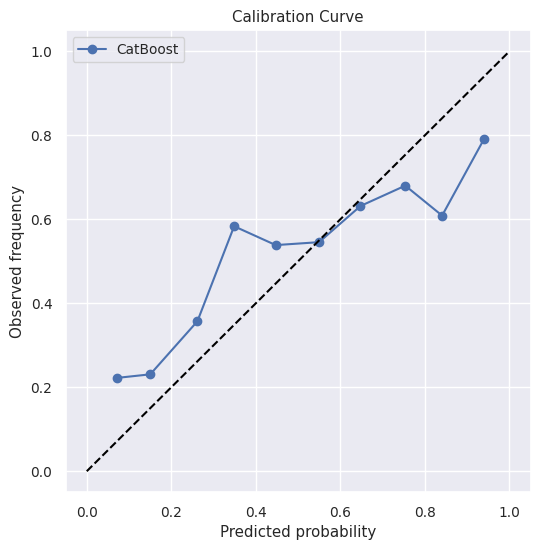

In [ ]:
prob_true, prob_pred = calibration_curve(y_test_cb, y_pred_proba_cb, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label="CatBoost")
plt.plot([0,1],[0,1], linestyle="--", color="black")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)
plt.show()

The calibration curve shows that CatBoost’s predicted risks generally align with observed outcomes but tend to underpredict risk at mid-range probabilities and slightly overpredict at the high end, indicating moderate calibration with some room for refinement.

Performing a Hosmer–Lemeshow calibration test by binning predicted probabilities, comparing observed vs. expected outcomes across bins, computing the test statistic, and printing its p-value.

In [ ]:
def hosmer_lemeshow_test(y_true, y_prob, g=10):
    df = pd.DataFrame({"y": y_true, "p": y_prob})
    df["bin"] = pd.qcut(df["p"], q=g, duplicates="drop")

    obs = df.groupby("bin")["y"].sum()
    exp = df.groupby("bin")["p"].sum()
    n = df.groupby("bin")["y"].count()

    hl_stat = (((obs - exp)**2) / (exp * (1 - exp/n))).sum()
    p_value = 1 - chi2.cdf(hl_stat, g-2)
    return hl_stat, p_value

hl_stat, hl_p = hosmer_lemeshow_test(y_test_cb, y_pred_proba_cb)

print("Hosmer–Lemeshow Statistic:", hl_stat)
print("Hosmer–Lemeshow p-value:", hl_p)

Hosmer–Lemeshow Statistic: 27.524148887148247
Hosmer–Lemeshow p-value: 0.0005737228738407207


/var/tmp/ipykernel_6574/3256482703.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs = df.groupby("bin")["y"].sum()
/var/tmp/ipykernel_6574/3256482703.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  exp = df.groupby("bin")["p"].sum()
/var/tmp/ipykernel_6574/3256482703.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  n = df.groupby("bin")["y"].count()


Computing Cohen’s d effect sizes for all numeric variables by comparing means between progression and non-progression groups, then ranking variables by the magnitude of their effect.

In [ ]:
df_or = df_model_clean.copy()

def cohens_d(x_pos, x_neg):
    """Compute Cohen's d for two groups."""
    n1, n2 = len(x_pos), len(x_neg)
    s1, s2 = np.var(x_pos, ddof=1), np.var(x_neg, ddof=1)
    s_pooled = np.sqrt(((n1 - 1)*s1 + (n2 - 1)*s2) / (n1 + n2 - 2))
    return (np.mean(x_pos) - np.mean(x_neg)) / s_pooled

group_pos = df_or[df_or['dic_progression'] == 1]
group_neg = df_or[df_or['dic_progression'] == 0]

numeric_vars = df_or.select_dtypes(include='number').columns
numeric_vars = [v for v in numeric_vars if v != 'dic_progression']

cohen_results = []

for var in numeric_vars:
    x1 = group_pos[var].dropna()
    x0 = group_neg[var].dropna()
    if len(x1) < 5 or len(x0) < 5:
        continue

    d = cohens_d(x1, x0)
    cohen_results.append([var, d])

cohen_df = pd.DataFrame(cohen_results, columns=["Variable", "Cohen_d"]) \
                    .sort_values("Cohen_d", key=abs, ascending=False)
cohen_df

/var/tmp/ipykernel_6574/3894575510.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return (np.mean(x_pos) - np.mean(x_neg)) / s_pooled
/var/tmp/ipykernel_6574/3894575510.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return (np.mean(x_pos) - np.mean(x_neg)) / s_pooled
/var/tmp/ipykernel_6574/3894575510.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return (np.mean(x_pos) - np.mean(x_neg)) / s_pooled
/var/tmp/ipykernel_6574/3894575510.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return (np.mean(x_pos) - np.mean(x_neg)) / s_pooled
/var/tmp/ipykernel_6574/3894575510.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return (np.mean(x_pos) - np.mean(x_neg)) / s_pooled
/var/tmp/ipykernel_6574/3894575510.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return (np.mean(x_pos) - np.mean(x_neg)) / s_pooled
/var/tmp/ipykernel_6574/3894575510.py:8: RuntimeWarning: invalid value encou

Variable   Cohen_d
33            bicarbonate_avg  0.507235
35          bg_hematocrit_avg -0.424467
36          bg_hemoglobin_avg -0.421695
21                   globulin -0.321132
47               platelet_avg -0.314044
50                    wbc_avg  0.282702
25       avg_sofa_score_daily  0.267975
26                    so2_avg -0.227218
74             sw_respiration  0.221219
52               aniongap_avg  0.220878
42             bg_lactate_avg  0.219819
19          min_minute_volume  0.195124
69         mild_liver_disease  0.191671
75                   sw_liver  0.190957
17         mean_minute_volume  0.189779
41              bg_sodium_avg  0.181415
1              max_heart_rate  0.176212
82       plateau_pressure_avg  0.176007
67       severe_liver_disease  0.174829
43             bg_glucose_avg  0.171888
86                        bmi  0.171523
79                  sw_weight  0.167772
32             baseexcess_avg -0.166671
34               totalco2_avg -0.164125
84               weight_daily  0.161866
20                  aado2_avg  0.159890
30          pao2fio2ratio_avg  0.158803
7              mean_resp_rate  0.157507
53                    bun_avg  0.156149
85               weight_final  0.154400
5             mean_heart_rate  0.144256
76          sw_cardiovascular  0.143717
80                        age -0.143219
61                    ast_avg  0.142982
29                   fio2_avg -0.135425
38             bg_calcium_avg -0.130057
70           diabetes_with_cc -0.129190
18          max_minute_volume  0.128065
0                  sepsis_day -0.123695
78                   sw_renal  0.117355
59                    alt_avg  0.116319
58                    ptt_avg  0.114226
56                    inr_avg  0.112728
23            vasopressor_use  0.108623
31                     ph_avg -0.104678
16           min_tidal_volume  0.104524
49                    rdw_avg  0.099193
39         bg_temperature_avg  0.097371
57                     pt_avg  0.094901
72              renal_disease -0.091670
14          mean_tidal_volume  0.091403
12                   max_peep  0.091273
71        diabetes_without_cc  0.089461
44                    mch_avg  0.089191
68  chronic_pulmonary_disease  0.085920
15           max_tidal_volume  0.074792
4                    min_spo2 -0.072522
28                   pco2_avg -0.072451
62        bilirubin_total_avg -0.066850
3               max_resp_rate  0.065023
45                   mchc_avg  0.063979
66     metastatic_solid_tumor -0.063964
60                    alp_avg -0.062409
55             fibrinogen_avg -0.057856
46                    mcv_avg  0.057223
81           urine_output_avg -0.057162
64                        chf -0.048054
63                         mi -0.046080
77                     sw_cns  0.039965
6                    mean_mbp -0.039830
27                    po2_avg -0.035947
13                   min_peep -0.035190
37            bg_chloride_avg  0.034145
11                  mean_peep  0.032683
10                   min_fio2  0.032032
40           bg_potassium_avg  0.027939
54             creatinine_avg  0.022156
48                    rbc_avg -0.021828
65           malignant_cancer -0.019565
2                     min_mbp -0.013414
9                    max_fio2  0.008420
73                     stroke  0.007764
22              total_protein -0.006169
51                albumin_avg -0.003927
8                   mean_fio2 -0.003756
24                        rrt       NaN
83            vasopressin_use       NaN
87             platelet_score       NaN
88                  inr_score       NaN
89                  sic_today       NaN
90                    sirs_hr       NaN
91                    sirs_rr       NaN
92                  sirs_temp       NaN
93                   sirs_wbc       NaN
94                 sirs_score       NaN

Calculating Cramér’s V effect sizes for all categorical variables by creating contingency tables with the outcome and ranking them by association strength.

In [ ]:
def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r-1, k-1))))

categorical_vars = df_or.select_dtypes(exclude='number').columns

cramer_results = []

for var in categorical_vars:
    table = pd.crosstab(df_or[var], df_or['dic_progression'])

    if table.shape[0] < 2 or table.shape[1] < 2:
        continue

    v = cramers_v(table.values)
    cramer_results.append([var, v])

cramer_df = pd.DataFrame(cramer_results, columns=["Variable", "Cramers_V"]) \
                      .sort_values("Cramers_V", ascending=False)
cramer_df

Variable  Cramers_V
5     height_final   0.361697
0  max_temperature   0.289227
4           height   0.197105
1             race   0.163659
2   admission_type   0.056292
3           gender   0.038078

Combining top numeric and categorical effect sizes into one dataset, ranking them by magnitude, and ploting a horizontal bar chart showing Cohen’s d and Cramér’s V side-by-side.

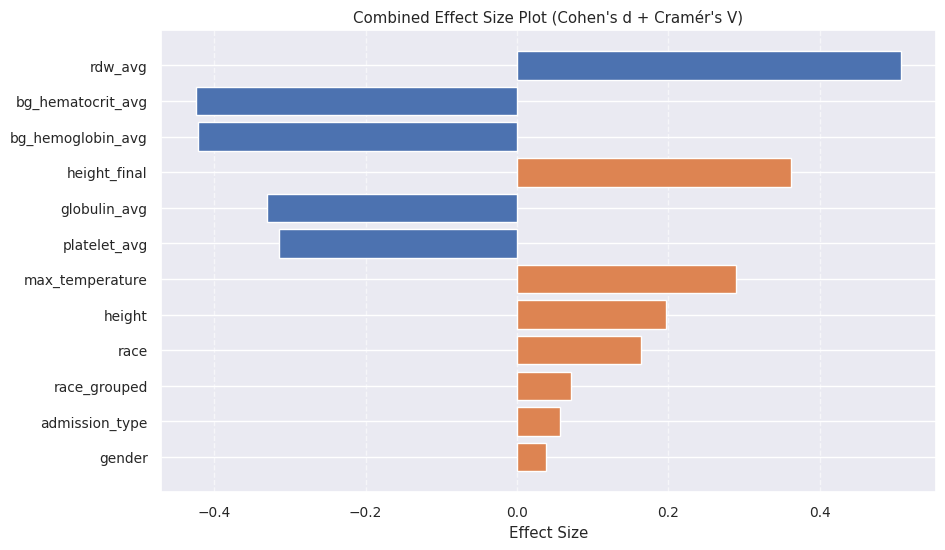

In [ ]:
cohen_d_data = {
    "Variable": ["rdw_avg", "bg_hematocrit_avg", "bg_hemoglobin_avg", "globulin_avg", "platelet_avg"],
    "Effect_Size": [0.507, -0.424, -0.421, -0.331, -0.314],
    "Type": "Cohen_d"
}

cramers_v_data = {
    "Variable": ["height_final", "max_temperature", "height", "race", "race_grouped", "admission_type", "gender"],
    "Effect_Size": [0.361697, 0.289227, 0.197105, 0.163659, 0.071583, 0.056292, 0.038078],
    "Type": "Cramers_V"
}

df = pd.concat([pd.DataFrame(cohen_d_data), pd.DataFrame(cramers_v_data)], ignore_index=True)

df["abs_effect"] = df["Effect_Size"].abs()
df = df.sort_values("abs_effect", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(df["Variable"], df["Effect_Size"], color=["#4c72b0" if t=="Cohen_d" else "#dd8452" for t in df["Type"]])
plt.xlabel("Effect Size")
plt.title("Combined Effect Size Plot (Cohen's d + Cramér's V)")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

This effect size plot highlights which variables differ most between patients who progress to DIC and those who do not. Strong numeric effects, such as higher RDW and lower hemoglobin and hematocrit, indicate meaningful physiological separation between groups, while categorical effects like height, temperature, and race show smaller but still notable associations.

# Modeling for DIC

## Logistic Regression

Loading the dataset, removing ID, time, future-label, and fully missing columns to prevent leakage, converting a few fields to numeric, and then constructing clean feature (X) and target (y) matrices for modeling.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from google.cloud import bigquery
import pandas as pd

client = bigquery.Client()
table_id = "mlinhealthcaregroup4.temp.rework_final_table_with_jaam_dic_labels_with_filter"

df = client.list_rows(table_id).to_dataframe()

df.head()
data = df.copy()

target_col = "jaam_dic_tomorrow"

id_cols = ["subject_id", "stay_id"]
time_cols = ["chart_date", "suspected_infection_time", "infection_date"]
future_label_cols = [
    "jaam_dic_tomorrow",
    "jaam_dic_progression",
    "sic_tomorrow",
    "sic_next_day",
]

cols_to_drop = id_cols + time_cols + future_label_cols

missing_pct = df.isna().mean()
always_missing_cols = missing_pct[missing_pct == 1.0].index.tolist()

print("Columns with 100% missing:", always_missing_cols)

cols_to_drop += always_missing_cols

cols_to_drop = [c for c in cols_to_drop if c in df.columns]

print("\nDropping these columns from features:")
print(cols_to_drop)
df['max_temperature']=df['max_temperature'].astype(float)
df['height']=df['height'].astype(float)
df['height_final']=df['height_final'].astype(float)

X = df.drop(columns=cols_to_drop)
y = df[target_col]

print("\nX shape after dropping leakage/ID/time columns:", X.shape)
print("y shape:", y.shape)

print("\nCheck that target is not in X:", "jaam_dic_tomorrow" in X.columns)


Columns with 100% missing: ['rdwsd_avg']

Dropping these columns from features:
['subject_id', 'stay_id', 'chart_date', 'suspected_infection_time', 'infection_date', 'jaam_dic_tomorrow', 'jaam_dic_progression', 'sic_tomorrow', 'sic_next_day', 'rdwsd_avg']

X shape after dropping leakage/ID/time columns: (14004, 113)
y shape: (14004,)

Check that target is not in X: False


In [ ]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=cols_to_drop)
y = df[target_col]

X_train_final, X_test_final, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train_final shape:", X_train_final.shape)
print("X_test_final shape:", X_test_final.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train_final shape: (11203, 113)
X_test_final shape: (2801, 113)
y_train shape: (11203,)
y_test shape: (2801,)


In [ ]:
cols_to_drop_logreg = [

    "platelet_score", "inr_score",

    "sw_respiration", "sw_liver", "sw_cardiovascular",
    "sw_cns", "sw_renal", "sw_weight",

    "d_dimer_avg", "fibrinogen_avg", "thrombin_avg",

    "so2_avg", "po2_avg", "pco2_avg", "fio2_avg",
    "aado2_avg", "bg_aado2_avg",

    "bg_hematocrit_avg", "bg_hemoglobin_avg", "bg_chloride_avg",
    "bg_calcium_avg", "bg_temperature_avg", "bg_potassium_avg",
    "bg_sodium_avg", "bg_lactate_avg", "bg_glucose_avg",

    "max_peep", "min_peep",
    "max_tidal_volume", "min_tidal_volume",
    "max_minute_volume", "min_minute_volume",

    "max_fio2", "min_fio2",
]

cols_to_drop_logreg = [c for c in cols_to_drop_logreg if c in X_train_final.columns]

print("Columns to drop for logistic regression:")
print(cols_to_drop_logreg)

Columns to drop for logistic regression:
['platelet_score', 'inr_score', 'sw_respiration', 'sw_liver', 'sw_cardiovascular', 'sw_cns', 'sw_renal', 'sw_weight', 'd_dimer_avg', 'fibrinogen_avg', 'thrombin_avg', 'so2_avg', 'po2_avg', 'pco2_avg', 'fio2_avg', 'aado2_avg', 'bg_aado2_avg', 'bg_hematocrit_avg', 'bg_hemoglobin_avg', 'bg_chloride_avg', 'bg_calcium_avg', 'bg_temperature_avg', 'bg_potassium_avg', 'bg_sodium_avg', 'bg_lactate_avg', 'bg_glucose_avg', 'max_peep', 'min_peep', 'max_tidal_volume', 'min_tidal_volume', 'max_minute_volume', 'min_minute_volume', 'max_fio2', 'min_fio2']


In [ ]:
X_train_lr = X_train_final.drop(columns=cols_to_drop_logreg)
X_test_lr = X_test_final.drop(columns=cols_to_drop_logreg)

print("Final logistic regression feature count:", X_train_lr.shape[1])

categorical_cols = ['race', 'admission_type', 'gender']

numerical_cols = [c for c in X_train_lr.columns if c not in categorical_cols]

print("Numerical feature count:", len(numerical_cols))
print("Categorical feature count:", len(categorical_cols))

Final logistic regression feature count: 79
Numerical feature count: 76
Categorical feature count: 3


Building a preprocessing and logistic regression pipeline (imputing, scaling, and one-hot encoding features), fitting it on the training data, and evaluating model performance on the test set using AUROC and AUPRC.

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
    ]
)

logreg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500))
])

logreg_model.fit(X_train_lr, y_train)

y_pred_proba = logreg_model.predict_proba(X_test_lr)[:, 1]

lr_auroc = roc_auc_score(y_test, y_pred_proba)
lr_auprc = average_precision_score(y_test, y_pred_proba)

print("Logistic Regression AUROC:", lr_auroc)
print("Logistic Regression AUPRC:", lr_auprc)

Logistic Regression AUROC: 0.9133147390320294
Logistic Regression AUPRC: 0.993834909708851


Selecting clinically relevant logistic regression features present in the dataset, building X and y, and spliting them into stratified train/test sets for modeling.

In [ ]:
df_model_clean

lr_features = [

    'sepsis_day',
    'mean_heart_rate', 'mean_mbp', 'mean_resp_rate', 'min_spo2',
    'mean_fio2', 'mean_peep', 'mean_tidal_volume', 'mean_minute_volume',

    'platelet_avg', 'inr_avg', 'pt_avg', 'ptt_avg',
    'fibrinogen_avg', 'd_dimer_avg', 'thrombin_avg',

    'bun_avg', 'creatinine_avg',
    'totalco2_avg', 'bicarbonate_avg', 'aniongap_avg',

    'bilirubin_total_avg', 'alt_avg', 'alp_avg', 'ast_avg',

    'wbc_avg', 'rdw_avg', 'albumin_avg', 'rbc_avg',

    'sirs_hr', 'sirs_rr', 'sirs_temp', 'sirs_wbc',

    'avg_sofa_score_daily',

    'vasopressor_use', 'vasopressin_use', 'rrt',

    'urine_output_avg',

    'age', 'gender', 'race', 'admission_type',

    'weight_final', 'bmi'
]

lr_features = [c for c in lr_features if c in df_model_clean.columns]

print("Final LR feature count:", len(lr_features))
print(lr_features)

X_lr = df_model_clean[lr_features].copy()
y_lr = df_model_clean['dic_progression'].copy()

print("X_lr shape:", X_lr.shape)
print("y_lr shape:", y_lr.shape)

from sklearn.model_selection import train_test_split

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_lr, y_lr,
    test_size=0.2,
    stratify=y_lr,
    random_state=42
)

print("Train LR shape:", X_train_lr.shape)
print("Test LR shape:", X_test_lr.shape)

Final LR feature count: 44
['sepsis_day', 'mean_heart_rate', 'mean_mbp', 'mean_resp_rate', 'min_spo2', 'mean_fio2', 'mean_peep', 'mean_tidal_volume', 'mean_minute_volume', 'platelet_avg', 'inr_avg', 'pt_avg', 'ptt_avg', 'fibrinogen_avg', 'd_dimer_avg', 'thrombin_avg', 'bun_avg', 'creatinine_avg', 'totalco2_avg', 'bicarbonate_avg', 'aniongap_avg', 'bilirubin_total_avg', 'alt_avg', 'alp_avg', 'ast_avg', 'wbc_avg', 'rdw_avg', 'albumin_avg', 'rbc_avg', 'sirs_hr', 'sirs_rr', 'sirs_temp', 'sirs_wbc', 'avg_sofa_score_daily', 'vasopressor_use', 'vasopressin_use', 'rrt', 'urine_output_avg', 'age', 'gender', 'race', 'admission_type', 'weight_final', 'bmi']
X_lr shape: (813, 44)
y_lr shape: (813,)
Train LR shape: (650, 44)
Test LR shape: (163, 44)


Defining separate preprocessing steps for numeric and categorical features, imputing and scaling numeric variables and imputing and one-hot encoding categorical variables, and combining them into a unified ColumnTransformer for logistic regression.

In [ ]:
categorical_features_lr = ['gender', 'race', 'admission_type']
categorical_features_lr = [c for c in categorical_features_lr if c in X_lr.columns]

numeric_features_lr = [c for c in X_lr.columns if c not in categorical_features_lr]

preprocessor_lr = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features_lr),

        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features_lr)
    ]
)

Training a full logistic regression pipeline, generating predictions, computing classification and probability-based metrics (including AUROC/AUPRC), printing the confusion matrix, and calculating sensitivity and specificity.

In [ ]:
logreg_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor_lr),
        ("classifier", LogisticRegression(
            max_iter=3000,
            solver='lbfgs',
            class_weight=None
        ))
    ]
)

logreg_model.fit(X_train_lr, y_train_lr)

y_pred_proba_lr = logreg_model.predict_proba(X_test_lr)[:, 1]

y_pred_lr = (y_pred_proba_lr >= 0.5).astype(int)

acc = accuracy_score(y_test_lr, y_pred_lr)
prec = precision_score(y_test_lr, y_pred_lr, zero_division=0)
rec = recall_score(y_test_lr, y_pred_lr)
f1 = f1_score(y_test_lr, y_pred_lr)
cm = confusion_matrix(y_test_lr, y_pred_lr)

lr_auroc = roc_auc_score(y_test_lr, y_pred_proba_lr)
lr_auprc = average_precision_score(y_test_lr, y_pred_proba_lr)

print("=== LOGISTIC REGRESSION METRICS ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUROC:     {lr_auroc:.4f}")
print(f"AUPRC:     {lr_auprc:.4f}")

print("\nConfusion Matrix (rows: true, cols: predicted):")
print(cm)


tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"\nSensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity:          {specificity:.4f}")

=== LOGISTIC REGRESSION METRICS ===
Accuracy:  0.6012
Precision: 0.6392
Recall:    0.6739
F1 Score:  0.6561
AUROC:     0.6361
AUPRC:     0.7026

Confusion Matrix (rows: true, cols: predicted):
[[36 35]
 [30 62]]

Sensitivity (Recall): 0.6739
Specificity:          0.5070


## XG Boost

In [ ]:
categorical_features = ['race', 'gender', 'admission_type']
categorical_features = [c for c in categorical_features if c in X_cb.columns]

numeric_features = [c for c in X_cb.columns if c not in categorical_features]

for col in X_cb.columns:
    if str(X_cb[col].dtype) == "Int64":
        X_cb[col] = X_cb[col].astype("float")

xgb_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

Converting nullable integer columns to floats, applying the preprocessing pipeline to transform train and test data, and prinitng the resulting matrix shapes.

In [ ]:
for df_temp in [X_train_cb, X_test_cb]:
    for col in df_temp.columns:
        if str(df_temp[col].dtype) == "Int64":
            df_temp[col] = df_temp[col].astype("float")
X_train_xgb = xgb_preprocessor.fit_transform(X_train_cb)
X_test_xgb = xgb_preprocessor.transform(X_test_cb)

X_train_xgb.shape, X_test_xgb.shape

((650, 134), (163, 134))

In [ ]:
xgb_model = XGBClassifier(
    n_estimators=800,
    learning_rate=0.02,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    tree_method='hist'
)

xgb_model.fit(X_train_xgb, y_train_cb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, ...)

Evaluating the XGBoost model by generating class predictions, computing full performance metrics (AUROC, AUPRC, accuracy, precision, recall, F1, sensitivity, specificity), and printing the confusion matrix.

In [ ]:
y_pred_proba_xgb = xgb_model.predict_proba(X_test_xgb)[:, 1]
y_pred_xgb = (y_pred_proba_xgb >= 0.5).astype(int)

xgb_auroc = roc_auc_score(y_test_cb, y_pred_proba_xgb)
xgb_auprc = average_precision_score(y_test_cb, y_pred_proba_xgb)
xgb_acc = accuracy_score(y_test_cb, y_pred_xgb)
xgb_prec = precision_score(y_test_cb, y_pred_xgb)
xgb_rec = recall_score(y_test_cb, y_pred_xgb)
xgb_f1 = f1_score(y_test_cb, y_pred_xgb)
cm_xgb = confusion_matrix(y_test_cb, y_pred_xgb)
tn, fp, fn, tp = cm_xgb.ravel()

xgb_sens = tp / (tp + fn)
xgb_spec = tn / (tn + fp)

print("=== XGBOOST RESULTS (threshold = 0.5) ===")
print("AUROC:", xgb_auroc)
print("AUPRC:", xgb_auprc)
print("Accuracy:", xgb_acc)
print("Precision:", xgb_prec)
print("Recall:", xgb_rec)
print("F1 Score:", xgb_f1)
print("Sensitivity:", xgb_sens)
print("Specificity:", xgb_spec)
print("\nConfusion Matrix:")
print(cm_xgb)

=== XGBOOST RESULTS (threshold = 0.5) ===
AUROC: 0.674219228413962
AUPRC: 0.6884423956140935
Accuracy: 0.6625766871165644
Precision: 0.6728971962616822
Recall: 0.782608695652174
F1 Score: 0.7236180904522613
Sensitivity: 0.782608695652174
Specificity: 0.5070422535211268

Confusion Matrix:
[[36 35]
 [20 72]]


## CatBoost

Building the CatBoost feature matrix and target vector, printing the feature shape, and identifying which categorical variables should be treated as categorical features in the model.

In [ ]:
X_cb = df_model_clean.drop(columns=['dic_progression'])
y_cb = df_model_clean['dic_progression']

print("CatBoost full feature set shape:", X_cb.shape)

cat_features = ['race', 'gender', 'admission_type']
cat_features = [c for c in cat_features if c in X_cb.columns]

cat_features

CatBoost full feature set shape: (813, 107)


['race', 'gender', 'admission_type']

In [ ]:
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(
    X_cb, y_cb,
    test_size=0.2,
    stratify=y_cb,
    random_state=42
)

print("Train CB shape:", X_train_cb.shape)
print("Test CB shape:", X_test_cb.shape)

Train CB shape: (650, 107)
Test CB shape: (163, 107)


In [ ]:
cat_model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.02,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    class_weights=None
)

cat_model.fit(
    X_train_cb, y_train_cb,
    cat_features=cat_features,
    eval_set=(X_test_cb, y_test_cb),
    use_best_model=True
)

0:	test: 0.6139773	best: 0.6139773 (0)	total: 9.47ms	remaining: 14.2s
100:	test: 0.6566136	best: 0.6656461 (8)	total: 531ms	remaining: 7.36s
200:	test: 0.6596754	best: 0.6656461 (8)	total: 999ms	remaining: 6.46s
300:	test: 0.6661053	best: 0.6722290 (289)	total: 1.43s	remaining: 5.69s
400:	test: 0.6656461	best: 0.6722290 (289)	total: 1.84s	remaining: 5.05s
500:	test: 0.6714636	best: 0.6722290 (289)	total: 2.27s	remaining: 4.53s
600:	test: 0.6794244	best: 0.6795775 (599)	total: 2.68s	remaining: 4.01s
700:	test: 0.6797306	best: 0.6834048 (639)	total: 3.1s	remaining: 3.54s
800:	test: 0.6808022	best: 0.6834048 (639)	total: 3.53s	remaining: 3.08s
900:	test: 0.6795775	best: 0.6834048 (639)	total: 3.96s	remaining: 2.63s
1000:	test: 0.6791182	best: 0.6834048 (639)	total: 4.38s	remaining: 2.18s
1100:	test: 0.6815677	best: 0.6834048 (639)	total: 4.8s	remaining: 1.74s
1200:	test: 0.6817208	best: 0.6835579 (1181)	total: 5.2s	remaining: 1.29s
1300:	test: 0.6814146	best: 0.6835579 (1181)	total: 5.6s	

Evaluating CatBoost’s predictions by calculating probability-based and classification metrics, deriving sensitivity and specificity, and displaying the confusion matrix.

In [ ]:
y_pred_proba_cb = cat_model.predict_proba(X_test_cb)[:, 1]

y_pred_cb = (y_pred_proba_cb >= 0.5).astype(int)

cb_auroc = roc_auc_score(y_test_cb, y_pred_proba_cb)
cb_auprc = average_precision_score(y_test_cb, y_pred_proba_cb)
cb_acc = accuracy_score(y_test_cb, y_pred_cb)
cb_prec = precision_score(y_test_cb, y_pred_cb)
cb_rec = recall_score(y_test_cb, y_pred_cb)
cb_f1 = f1_score(y_test_cb, y_pred_cb)

cm = confusion_matrix(y_test_cb, y_pred_cb)
tn, fp, fn, tp = cm.ravel()

cb_sens = tp / (tp + fn)
cb_spec = tn / (tn + fp)

print("=== CATBOOST RESULTS ===")
print("AUROC:", cb_auroc)
print("AUPRC:", cb_auprc)
print("Accuracy:", cb_acc)
print("Precision:", cb_prec)
print("Recall:", cb_rec)
print("F1:", cb_f1)
print("Sensitivity:", cb_sens)
print("Specificity:", cb_spec)
print("\nConfusion Matrix:")
print(cm)

=== CATBOOST RESULTS ===
AUROC: 0.6835578689528475
AUPRC: 0.7230008107084056
Accuracy: 0.6441717791411042
Precision: 0.6666666666666666
Recall: 0.7391304347826086
F1: 0.7010309278350515
Sensitivity: 0.7391304347826086
Specificity: 0.5211267605633803

Confusion Matrix:
[[37 34]
 [24 68]]


Computing SHAP values for the CatBoost model using a TreeExplainer and visualizing feature importance with a SHAP summary dot plot.

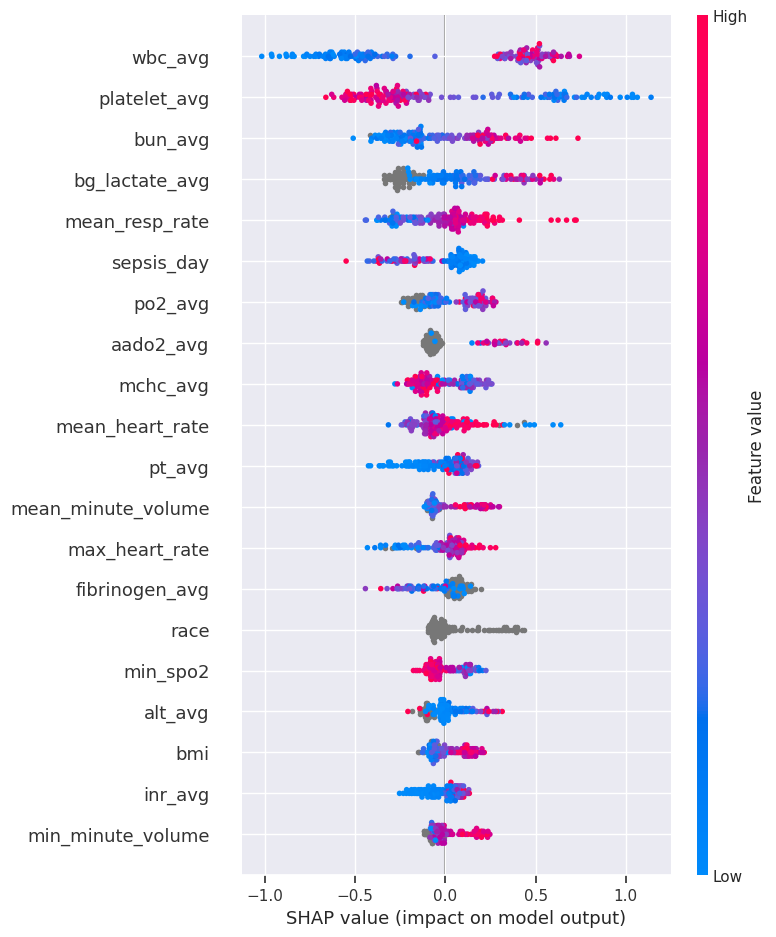

In [ ]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test_cb)

shap.summary_plot(shap_values, X_test_cb, plot_type="dot")

The SHAP summary plot shows how each feature influences the model’s predictions, with high values (red) often pushing risk upward and low values (blue) reducing predicted risk. Inflammatory markers (WBC), platelet counts, renal markers (BUN), and lactate levels have the strongest directional effects, demonstrating their central role in driving the model's assessment of DIC progression.

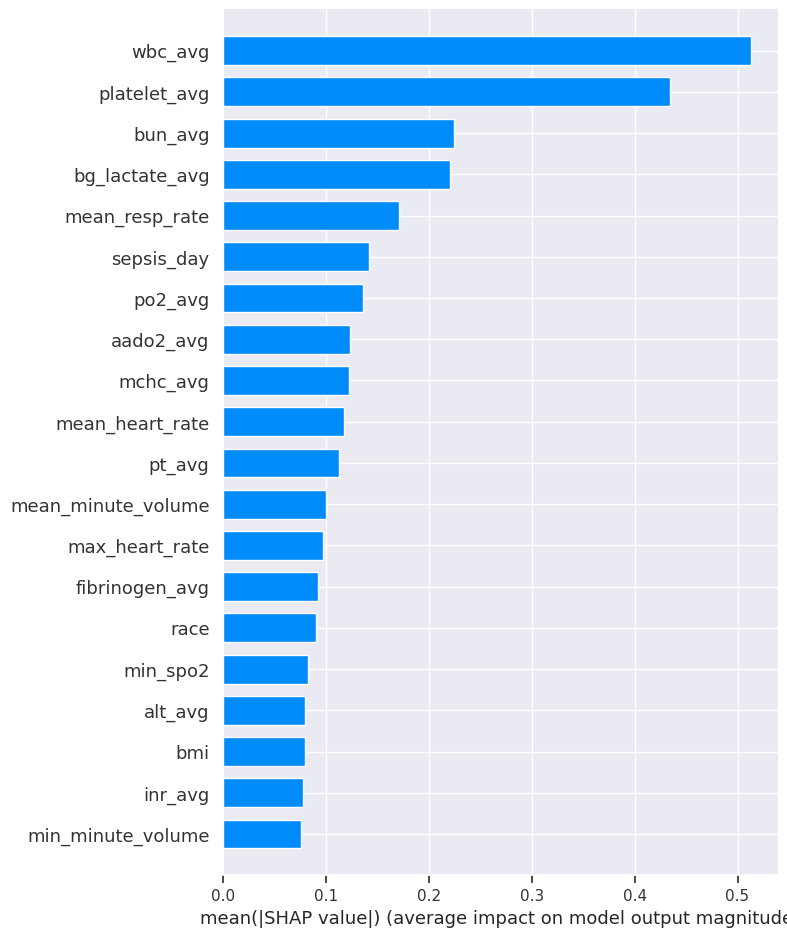

In [ ]:
shap.summary_plot(shap_values, X_test_cb, plot_type="bar")

The SHAP importance plot shows that wbc_avg, platelet_avg, bun_avg, and bg_lactate_avg are the most influential predictors driving the model’s decisions, highlighting inflammation, coagulation, renal function, and metabolic stress as key signals of DIC progression.

Calculating the mean absolute SHAP value for each feature, building a ranked importance table, and displaying the top contributing features.

In [ ]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)

shap_importance = (
    pd.DataFrame({
        'feature': X_test_cb.columns,
        'mean_abs_shap': mean_abs_shap
    })
    .sort_values(by='mean_abs_shap', ascending=False)
)

shap_importance.head(20)

feature  mean_abs_shap
53             wbc_avg       0.513241
49        platelet_avg       0.434050
58             bun_avg       0.224336
44      bg_lactate_avg       0.220690
8       mean_resp_rate       0.170887
0           sepsis_day       0.142219
28             po2_avg       0.135825
21           aado2_avg       0.123431
47            mchc_avg       0.122121
6      mean_heart_rate       0.117509
64              pt_avg       0.112997
18  mean_minute_volume       0.100586
1       max_heart_rate       0.097157
61      fibrinogen_avg       0.092585
87                race       0.090536
4             min_spo2       0.082731
66             alt_avg       0.079415
98                 bmi       0.079375
63             inr_avg       0.077432
20   min_minute_volume       0.076088

Testing probability thresholds, computing sensitivity, specificity, F1, Youden’s J, and balanced accuracy for each, and identifying the threshold that optimizes each metric.

In [ ]:
thresholds = np.linspace(0.01, 0.99, 200)

f1_list = []
youden_list = []
balanced_acc_list = []
sens_list = []
spec_list = []

tn, fp, fn, tp = 0, 0, 0, 0

for t in thresholds:
    y_pred_t = (y_pred_proba_cb >= t).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test_cb, y_pred_t).ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    sens_list.append(sensitivity)
    spec_list.append(specificity)

    f1_list.append(f1_score(y_test_cb, y_pred_t))

    youden_list.append(sensitivity + specificity - 1)

    balanced_acc_list.append((sensitivity + specificity) / 2)

best_f1_threshold = thresholds[np.argmax(f1_list)]
best_j_threshold = thresholds[np.argmax(youden_list)]
best_balanced_acc_threshold = thresholds[np.argmax(balanced_acc_list)]

print("Best F1 threshold:", best_f1_threshold)
print("Best Youden J threshold:", best_j_threshold)
print("Best Balanced Accuracy threshold:", best_balanced_acc_threshold)

Best F1 threshold: 0.2562311557788945
Best Youden J threshold: 0.31040201005025125
Best Balanced Accuracy threshold: 0.31040201005025125


Defining a function to compute and print full evaluation metrics for any chosen threshold, then applying it to the thresholds that optimize F1, Youden’s J, and balanced accuracy.

In [ ]:
def evaluate_threshold(t):
    y_pred_t = (y_pred_proba_cb >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test_cb, y_pred_t).ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_test_cb, y_pred_t)
    balanced_acc = (recall + specificity) / 2

    print(f"\n=== Threshold = {t:.3f} ===")
    print("Precision:", precision)
    print("Recall (Sensitivity):", recall)
    print("Specificity:", specificity)
    print("F1 Score:", f1)
    print("Balanced Accuracy:", balanced_acc)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_cb, y_pred_t))

evaluate_threshold(best_f1_threshold)
evaluate_threshold(best_j_threshold)
evaluate_threshold(best_balanced_acc_threshold)


=== Threshold = 0.256 ===
Precision: 0.635036496350365
Recall (Sensitivity): 0.9456521739130435
Specificity: 0.29577464788732394
F1 Score: 0.759825327510917
Balanced Accuracy: 0.6207134109001837
Confusion Matrix:
[[21 50]
 [ 5 87]]

=== Threshold = 0.310 ===
Precision: 0.656
Recall (Sensitivity): 0.8913043478260869
Specificity: 0.39436619718309857
F1 Score: 0.7557603686635944
Balanced Accuracy: 0.6428352725045927
Confusion Matrix:
[[28 43]
 [10 82]]

=== Threshold = 0.310 ===
Precision: 0.656
Recall (Sensitivity): 0.8913043478260869
Specificity: 0.39436619718309857
F1 Score: 0.7557603686635944
Balanced Accuracy: 0.6428352725045927
Confusion Matrix:
[[28 43]
 [10 82]]


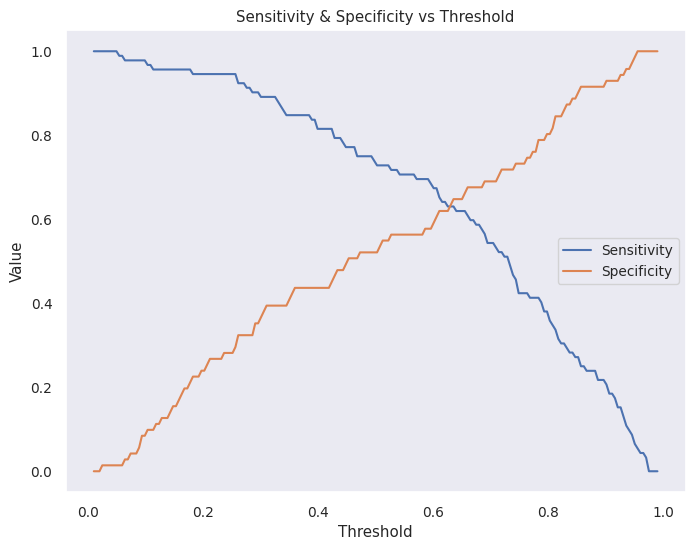

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(thresholds, sens_list, label="Sensitivity")
plt.plot(thresholds, spec_list, label="Specificity")
plt.xlabel("Threshold")
plt.ylabel("Value")
plt.title("Sensitivity & Specificity vs Threshold")
plt.legend()
plt.grid()
plt.show()

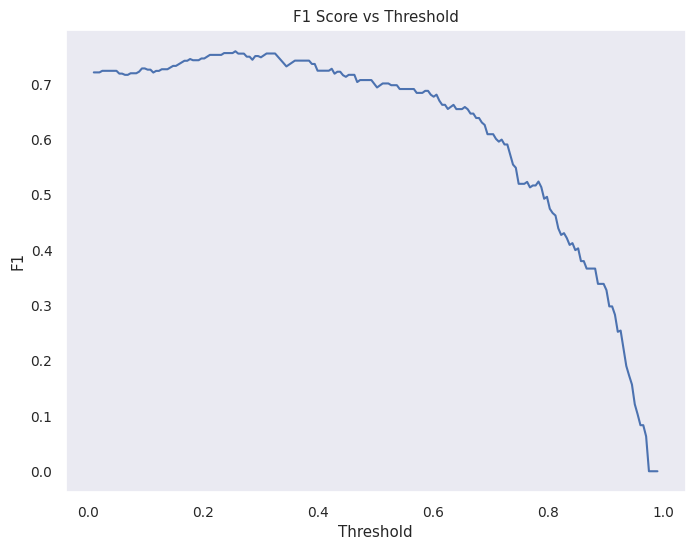

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(thresholds, f1_list, label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("F1 Score vs Threshold")
plt.grid()
plt.show()

Defining optimal threshold values, creating a function that evaluates model predictions at any threshold, and returning key classification metrics such as accuracy, precision, recall, specificity, and F1 score.

In [ ]:
t_f1 = 0.2562311557788945
t_j = 0.31040201005025125
best_f1_threshold = t_f1
best_j_threshold = t_j

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, auc, roc_auc_score, average_precision_score, confusion_matrix
)

def evaluate_model(y_true, y_proba, threshold):
    y_pred = (y_proba >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) else 0
    specificity = tn / (tn + fp) if (tn + fp) else 0
    precision = tp / (tp + fp) if (tp + fp) else 0
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    return {
        "Accuracy": acc,
        "Precision": precision,
        "Recall (Sensitivity)": sensitivity,
        "Specificity": specificity,
        "F1 Score": f1
    }

Evaluating Logistic Regression, CatBoost (default and optimized thresholds), and XGBoost, adding AUROC and AUPRC for each, and compiling all metrics into a clean, rounded comparison table.

In [ ]:
results = {}

results["Logistic Regression (0.5)"] = evaluate_model(y_test_lr, y_pred_proba_lr, 0.5)

results["CatBoost (0.5)"] = evaluate_model(y_test_cb, y_pred_proba_cb, 0.5)

results[f"CatBoost (F1-optimal {best_f1_threshold:.3f})"] = evaluate_model(
    y_test_cb, y_pred_proba_cb, best_f1_threshold
)

results[f"CatBoost (YoudenJ-optimal {best_j_threshold:.3f})"] = evaluate_model(
    y_test_cb, y_pred_proba_cb, best_j_threshold
)

results["XGBoost (0.5)"] = evaluate_model(
    y_test_cb, y_pred_proba_xgb, 0.5
)

results_df = pd.DataFrame(results).T

results_df["AUROC"] = [
    roc_auc_score(y_test_lr, y_pred_proba_lr),
    roc_auc_score(y_test_cb, y_pred_proba_cb),
    roc_auc_score(y_test_cb, y_pred_proba_cb),
    roc_auc_score(y_test_cb, y_pred_proba_cb),
    roc_auc_score(y_test_cb, y_pred_proba_xgb),
]

results_df["AUPRC"] = [
    average_precision_score(y_test_lr, y_pred_proba_lr),
    average_precision_score(y_test_cb, y_pred_proba_cb),
    average_precision_score(y_test_cb, y_pred_proba_cb),
    average_precision_score(y_test_cb, y_pred_proba_cb),
    average_precision_score(y_test_cb, y_pred_proba_xgb),
]

results_df = results_df[
    ["Accuracy", "Precision", "Recall (Sensitivity)", "Specificity",
     "F1 Score", "AUROC", "AUPRC"]
].round(3)

results_df

Accuracy  Precision  Recall (Sensitivity)  \
Logistic Regression (0.5)            0.601      0.639                 0.674   
CatBoost (0.5)                       0.644      0.667                 0.739   
CatBoost (F1-optimal 0.256)          0.663      0.635                 0.946   
CatBoost (YoudenJ-optimal 0.310)     0.675      0.656                 0.891   
XGBoost (0.5)                        0.663      0.673                 0.783   

                                  Specificity  F1 Score  AUROC  AUPRC  
Logistic Regression (0.5)               0.507     0.656  0.636  0.703  
CatBoost (0.5)                          0.521     0.701  0.684  0.723  
CatBoost (F1-optimal 0.256)             0.296     0.760  0.684  0.723  
CatBoost (YoudenJ-optimal 0.310)        0.394     0.756  0.684  0.723  
XGBoost (0.5)                           0.507     0.724  0.674  0.688

# Fairness Analysis for DIC

In [ ]:
fair_threshold = best_j_threshold

y_pred = (y_pred_proba_cb >= fair_threshold).astype(int)
y_true = y_test_cb.copy()

## Fairness Analysis - Gender

In [ ]:
test_df_cb = df_model_clean.loc[X_test_cb.index].copy()

test_df_cb["y_true"] = y_true
test_df_cb["y_pred"] = y_pred

Building a fairness evaluation dataset, filtering valid gender groups, and using MetricFrame to compute accuracy, sensitivity, and precision for each gender along with their group differences.

In [ ]:
fairness_df = test_df_cb.copy()
fairness_df["y_true"] = y_true
fairness_df["y_pred"] = y_pred

valid_mask = fairness_df['gender'].isin(['M','F'])
protected = fairness_df.loc[valid_mask, 'gender']

metrics = {
    "accuracy": accuracy_score,
    "sensitivity (recall)": recall_score,
    "precision": precision_score
}

mf_gender = MetricFrame(
    metrics=metrics,
    y_true=fairness_df.loc[valid_mask, "y_true"],
    y_pred=fairness_df.loc[valid_mask, "y_pred"],
    sensitive_features=protected
)

print("=== Gender Fairness: Metrics by Group ===")
print(mf_gender.by_group)
print("\n=== Gender Group Differences ===")
print(mf_gender.difference())

=== Gender Fairness: Metrics by Group ===
        accuracy  sensitivity (recall)  precision
gender                                           
F       0.681818              0.972222   0.636364
M       0.670103              0.839286   0.671429

=== Gender Group Differences ===
accuracy                0.011715
sensitivity (recall)    0.132937
precision               0.035065
dtype: float64


Computing fairness metrics, selection rate, true positive rate, and false positive rate for each gender group, and printing both per-group values and their differences to assess statistical parity and equalized odds.

In [ ]:
extra_metrics_gender = MetricFrame(
    metrics={
        "selection_rate": selection_rate,
        "TPR (sensitivity)": true_positive_rate,
        "FPR": false_positive_rate
    },
    y_true=fairness_df.loc[valid_mask, "y_true"],
    y_pred=fairness_df.loc[valid_mask, "y_pred"],
    sensitive_features=protected
)

print("=== Gender: Statistical Parity / Equalized Odds ===")
print(extra_metrics_gender.by_group)

print("\n=== Gender: Group Differences ===")
print(extra_metrics_gender.difference())

=== Gender: Statistical Parity / Equalized Odds ===
        selection_rate  TPR (sensitivity)       FPR
gender                                             
F             0.833333           0.972222  0.666667
M             0.721649           0.839286  0.560976

=== Gender: Group Differences ===
selection_rate       0.111684
TPR (sensitivity)    0.132937
FPR                  0.105691
dtype: float64


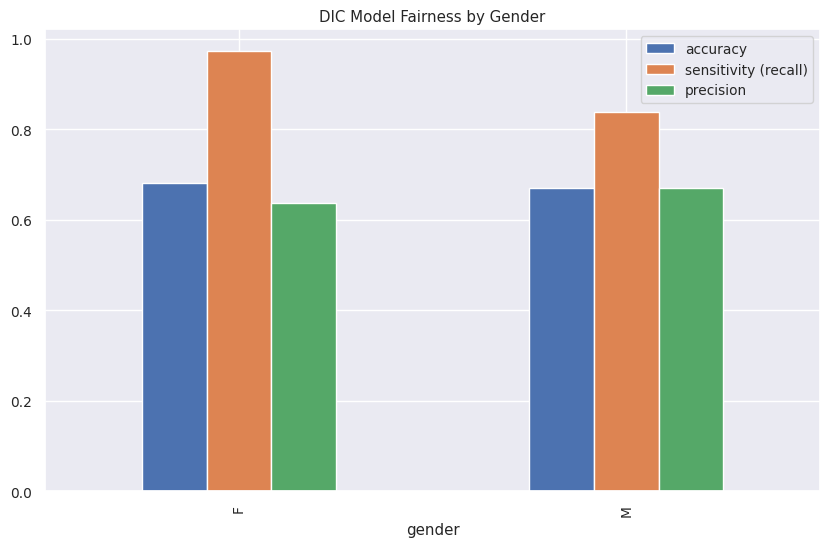

In [ ]:
mf_gender.by_group.plot(kind="bar", figsize=(10,6))
plt.title("DIC Model Fairness by Gender")
plt.show()

The model performs similarly for males and females, with comparable accuracy and precision across genders. Sensitivity is slightly higher for females, suggesting the model is marginally better at identifying true positive cases for that gender group.

## Fairness Analysis - Race

Standardizing race values by mapping detailed categories into broader groups and adding the result as a new race_grouped column for fairness analysis.

In [ ]:
def collapse_race(value):
    value = str(value).upper()
    if "WHITE" in value: return "WHITE"
    if "BLACK" in value: return "BLACK"
    if "ASIAN" in value: return "ASIAN"
    if "HISPANIC" in value or "LATINO" in value: return "HISPANIC"
    if value in ["UNKNOWN", "OTHER", "PATIENT DECLINED TO ANSWER"]:
        return "UNKNOWN"
    return "OTHER"

fairness_df["race_grouped"] = fairness_df["race"].apply(collapse_race)

Evaluating fairness across race groups by computing accuracy, sensitivity, and precision for each group using MetricFrame, and then reporting both group-specific metrics and their differences.

In [ ]:
valid_mask_race = fairness_df['race_grouped'].notna()
protected_race = fairness_df.loc[valid_mask_race, "race_grouped"]

metrics = {
    "accuracy": accuracy_score,
    "sensitivity (recall)": recall_score,
    "precision": precision_score
}

mf_race = MetricFrame(
    metrics=metrics,
    y_true=fairness_df.loc[valid_mask_race, "y_true"],
    y_pred=fairness_df.loc[valid_mask_race, "y_pred"],
    sensitive_features=protected_race
)

print("=== Race Fairness: Metrics by Group ===")
print(mf_race.by_group)

print("\n=== Race Group Differences ===")
print(mf_race.difference())

=== Race Fairness: Metrics by Group ===
              accuracy  sensitivity (recall)  precision
race_grouped                                           
ASIAN         1.000000              0.000000   0.000000
BLACK         0.473684              0.875000   0.437500
HISPANIC      0.500000              1.000000   0.444444
OTHER         0.750000              1.000000   0.750000
UNKNOWN       0.826087              1.000000   0.789474
WHITE         0.683168              0.847458   0.684932

=== Race Group Differences ===
accuracy                0.526316
sensitivity (recall)    1.000000
precision               0.789474
dtype: float64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Computing race-based fairness metrics, including selection rate, true positive rate, and false positive rate for each race group, and displaying both per-group values and their disparities.”

In [ ]:
extra_metrics_race = MetricFrame(
    metrics={
        "selection_rate": selection_rate,
        "TPR (sensitivity)": true_positive_rate,
        "FPR": false_positive_rate,
    },
    y_true=fairness_df.loc[valid_mask_race, "y_true"],
    y_pred=fairness_df.loc[valid_mask_race, "y_pred"],
    sensitive_features=protected_race
)

print("=== Race: Statistical Parity / Equalized Odds ===")
print(extra_metrics_race.by_group)

print("\n=== Race: Group Differences ===")
print(extra_metrics_race.difference())

=== Race: Statistical Parity / Equalized Odds ===
              selection_rate  TPR (sensitivity)       FPR
race_grouped                                             
ASIAN               0.000000           0.000000  0.000000
BLACK               0.842105           0.875000  0.818182
HISPANIC            0.900000           1.000000  0.833333
OTHER               1.000000           1.000000  1.000000
UNKNOWN             0.826087           1.000000  0.500000
WHITE               0.722772           0.847458  0.547619

=== Race: Group Differences ===
selection_rate       1.0
TPR (sensitivity)    1.0
FPR                  1.0
dtype: float64


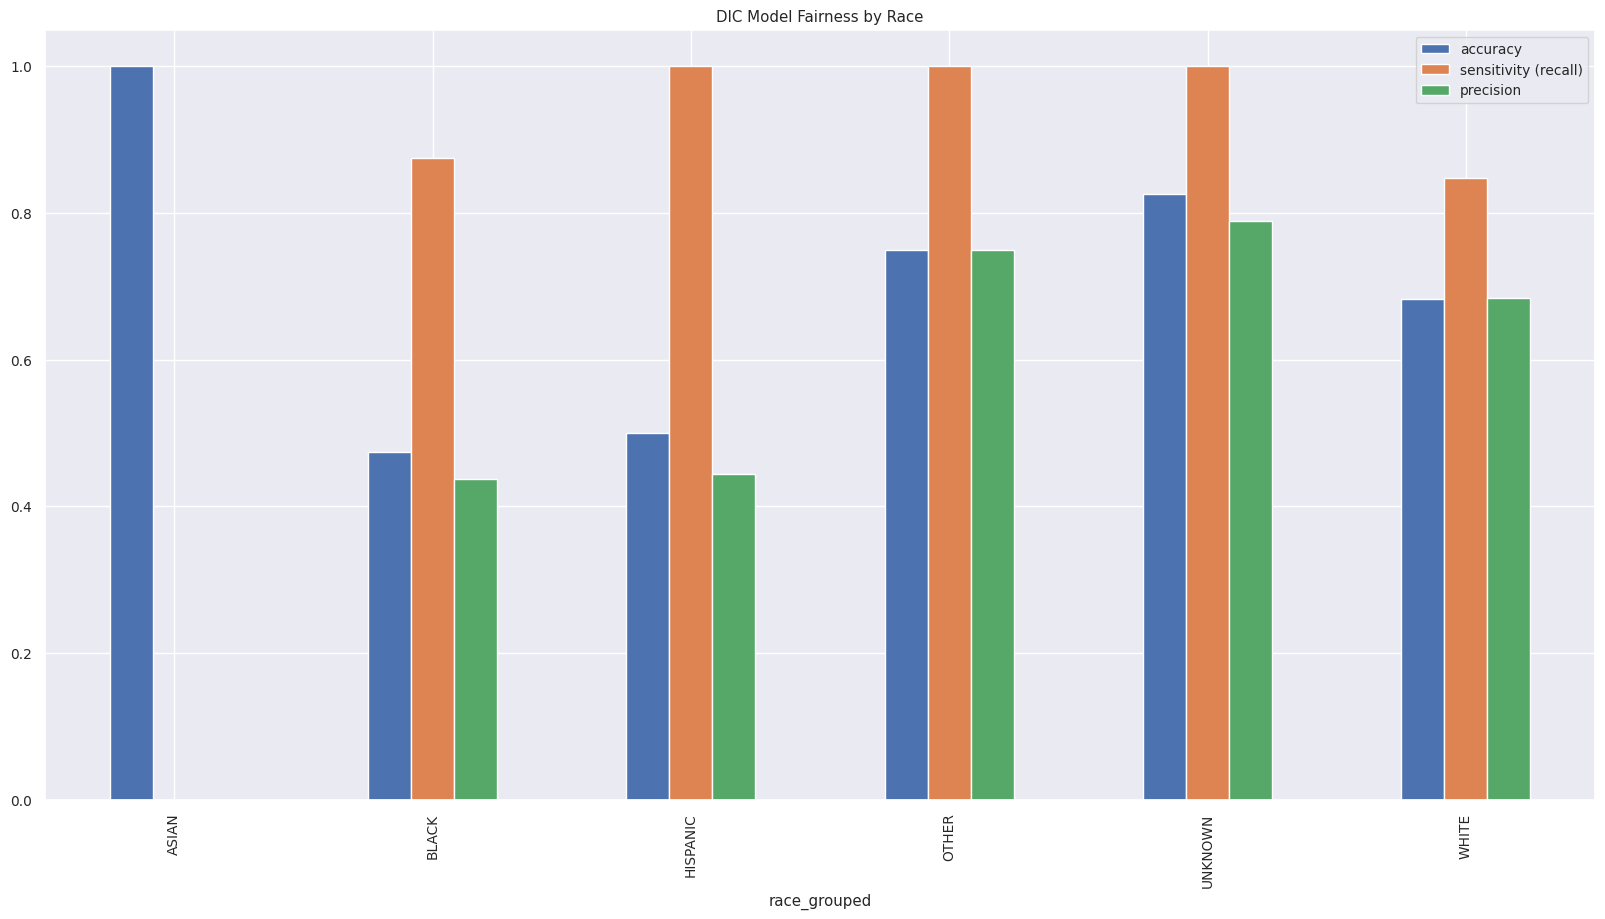

In [ ]:
mf_race.by_group.plot(kind="bar", figsize=(20,10))
plt.title("DIC Model Fairness by Race")
plt.show()

Model performance varies across racial groups, with some groups (e.g., Asian, Unknown) displaying higher accuracy and precision than others, and indicating that sensitivity is consistently high across groups, while lower precision in Black and Hispanic groups reflects a higher rate of false positives.